In [1]:
## ---- config----|

start  <- Sys.time()

set.seed(123456)
options(repr.plot.width = 20, repr.plot.height = 12)
options(encoding = 'UTF-8')

list.of.packages <- c("ggwordcloud")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)

end  <- Sys.time()
mem  <- pryr::mem_used()

WriteLog <- function(TaskName, StartTime, EndTime, AdditionalInfo) {

  TotalTime <- difftime(EndTime, StartTime, tz, 
                        units = c("auto", "secs", "mins", "hours",
                                  "days", "weeks"))
  
  log  <- paste('[', Sys.time(), '] ',
                'Task: ', TaskName, ' | ', 
                'Time elapsed: ', format(round(TotalTime, 3), format = '%H:%M:%S'), ' | ',
                'Memory used: ', round(pryr::mem_used() / 1000 / 1000, 0), ' MB | ',
                'Top Memory used: ', round(AdditionalInfo / 1000 / 1000, 0), ' MB | ',
                sep = "")

  write(log, file = "log.txt", append = TRUE)
  #print(log)
}

WriteLog('config', start, end, mem)

## ---- end-of-config----|


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Registered S3 method overwritten by 'pryr':
  method      from
  print.bytes Rcpp



# Trabalho em Grupo
(até 4 integrantes)

- **Curso:** FGV MBA - Business Analytics and Big Data
- **Disciplina:** Análise de Mídias Sociais e Mineração de Texto
- **Professor:** Gustavo Mirapalheta

## Alunos
|Github|Nome|Matricula|E-mail|
|---|---|---|---|
|<a href="https://github.com/DanielFCampos"><img src="https://avatars2.githubusercontent.com/u/31582602?s=460&v=4" title="DanielFCampos" width="40" height="40"></a>|Daniel Campos|A57635769|[daniel.ferraz.campos@gmail.com](daniel.ferraz.campos@gmail.com)|
|<a href="https://github.com/ldaniel"><img src="https://avatars2.githubusercontent.com/u/205534?s=460&v=4" title="ldaniel" width="40" height="40"></a>|Leandro Daniel|A57622988|[contato@leandrodaniel.com](contato@leandrodaniel.com)|
|<a href="https://github.com/RodriGonca"><img src="https://avatars2.githubusercontent.com/u/50252438?s=460&v=4" title="RodriGonca" width="40" height="40"></a>|Rodrigo Goncalves|A57566093|[rodrigo.goncalves@me.com](rodrigo.goncalves@me.com)|
|<a href="https://github.com/ygorlima1"><img src="https://avatars2.githubusercontent.com/u/52429828?s=460&v=4" title="ygorlima1" width="40" height="40"></a>|Ygor Lima|A57549661|[ygor_redesocial@hotmail.com](ygor_redesocial@hotmail.com)|

# Enunciado

Apresente uma análise exploratória de dados utilizando as técnicas de Text Mining desenvolvidas na disciplina Análise de Mídias Sociais e Mineração de Texto.

Para esta tarefa iremos utilizar um dataset extraído do Kaggle. Nele, encontram-se disponíveis cerca de 380 mil letras de músicas de uma grande variedade de artistas e gêneros.

# Libraries

Aqui estão todas as bibliotecas necessárias para este exercício.

In [2]:
## ---- load_libraries----|

start = Sys.time()

#data_wrangling

library(dplyr, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(readr)
library(stringr)
library(tidytext)
library(ggplot2)
library(forcats)

#wordcloud

library(ggwordcloud)

#network_visuallization

library(visNetwork)
library(IRdisplay)
library(igraph, warn.conflicts = FALSE)

#topic_modeling

library(topicmodels)

end = Sys.time()
mem = pryr::mem_used()

WriteLog('load library', start, end, mem)

## ---- end-of-load_libraries----|


# Importar e efetuar a limpeza dos dados

In [3]:
## ---- data_ingestion----|

start = Sys.time()

lyrics <- read_csv('../input/380000-lyrics-from-metrolyrics/lyrics.csv',
                   col_types = cols(
                       index = col_integer(),
                       song = col_character(),
                       year = col_integer(),
                       artist = col_factor(),
                       genre = col_factor(),
                       lyrics = col_character()),
                   locale = locale(encoding = 'UTF-8'))

print(paste('Número de observações: ', length(lyrics$index)))

end   = Sys.time()
mem   = pryr::mem_used()

WriteLog('import lyrics', start, end, mem)

## ---- end-of-data_ingestion----|


[1] "Número de observações:  362237"


Após uma primeira exploração dos dados, notamos a neccessidade de retirar todas as inconsistências e aplicar os seguintes filtros no dataset:

* Valores faltantes;
* Gêneros não definidos;
* Ano anterior a 1970 (poucas observações).

In [4]:
## ---- data_filter----|

start = Sys.time()

lyrics <- filter(lyrics, 
                 !is.na(lyrics), 
                 !(genre %in% c('Not Available', 'Other')),
                 as.integer(year) >= 1970)

# uncomment for fast prototyping
# lyrics  <- sample_n(lyrics, size = 1000)
# invisible(gc())

print(paste('Número de observações: ', length(lyrics$index)))

end = Sys.time()
mem = pryr::mem_used()

WriteLog('filter missing values', start, end, mem)

## ---- en-of-data_filter----|


[1] "Número de observações:  237420"


Vamos também incluir a identificação da década de lançamento da música para enriquescer os dados disponíveis.

In [5]:
## ---- data_enhance----|

start  <- Sys.time()

lyrics$decade <- paste(str_sub(lyrics$year, 1, 3), '0', sep = '')
lyrics$genre  <- trimws(lyrics$genre)

saveRDS(lyrics, 'lyrics.rds')

end  <- Sys.time()
mem = pryr::mem_used()

WriteLog('data enhance', start, end, mem)

## ---- end-of-data_enhance----|


Podemos visualizar uma amostra do dataset que iremos trabalhar.

In [6]:
## ---- view_sample----|

start = Sys.time()

sample_n(lyrics, 25) %>% 
    mutate(lyrics_preview = str_sub(lyrics, 1, 140)) %>% 
    select(-lyrics)

end = Sys.time()
mem = pryr::mem_used()

WriteLog('view sample', start, end, mem)

## ---- end-of-view_sample----|


index  song                                 year artist            genre  
1  134669 three-bells                          2008 the-browns        Pop    
2  122608 faction                              2007 candiria          Metal  
3   10220 m1-a1                                2006 gorillaz          Rock   
4  316661 twist-and-shout                      2006 deacon-blue       Rock   
5  160186 adonde-iran-los-besos-victor-manuel  1999 ana-belasn        Pop    
6  288845 rebellion                            2007 aina              Metal  
7   91610 too-much-too-soon                    2007 celestial-season  Rock   
8  221407 just-can-t-get-enough                2010 black-eyed-peas   Hip-Hop
9  278824 in-this-son                          2009 charice           Pop    
10 309142 when-the-time-s-right                2004 akon              Pop    
11 120233 loving-me-back-to-life               2005 geri-halliwell    Pop    
12  89955 cash                                 2007 big-moe           Hip-Hop
13 316558 freedom-train                        2006 deacon-blue       Rock   
14 187644 you-gotta-burn                       2007 dwarves           Rock   
15 115104 pepe-botika-donde-estan-mis-amigos   1997 extremoduro       Rock   
16 208775 once-upon-my-nightstand              2006 finch             Rock   
17 287898 darlin-dear                          2006 chicago           Rock   
18 360901 purity-throught-fire                 2006 belphegor         Metal  
19 174497 wake-you-with-a-kiss                 2015 aaron-pritchett   Country
20 230514 please-set-the-date                  2007 b-b-king          Rock   
21 245030 romeos                               2006 alphaville        Pop    
22 275242 a-little-death-around-the-eyes       2007 babyshambles      Rock   
23  37323 remembering-britt                    2007 a-day-at-the-fair Rock   
24 175377 whatever-hurts-you-through-the-night 2011 glasvegas         Rock   
25 186961 johnny-grey                          2006 eiffel-65         Pop    
   decade
1  2000  
2  2000  
3  2000  
4  2000  
5  1990  
6  2000  
7  2000  
8  2010  
9  2000  
10 2000  
11 2000  
12 2000  
13 2000  
14 2000  
15 1990  
16 2000  
17 2000  
18 2000  
19 2010  
20 2000  
21 2000  
22 2000  
23 2000  
24 2010  
25 2000  
   lyrics_preview                                                                                                                                      
1  There's a village hidden deep in the valley\nAmong the pine trees half forlorn\nAnd there on a sunny morning\nLittle Jimmy Brown was born\n(Bung    
2  Kill\nThis death is comfortable\nBeggar's life intolerable\nRunning with the madmen\nLowest of fears can't fathom\nMeasure your breath in fractio   
3  Hello, hello, is anyone there?\nHello, hello, is anyone there?\nHello, is anyone there?\nHello, is anyone there?\nHello, is anyone there?\nHello,   
4  You`ve got a lot of\nTings to say about the\nBig world and the\nHigh skies so you\nWalk a little in a\nLong mile to be\nSure your eyes can see the  
5  Tu beso tembloroso y programa doble, cinco pesetas\nen el momento justo nos enchufaban con la linterna.\nCuntos atardeceres por las callejas s      
6  [Talon: Glenn Hughes]\n[Backing vox: Tobias Sammet]\n[Talon:]\nThe mountains are calling\nThe heavens, they beckon her home\nOur sadness is falli   
7  Even the words came back, but I cannot rely on what they became to me\neven the sounds came back, but it's hard to hear the vibes when you aw       
8  Boy I think about it every night and day\nI'm addicted wanna jump inside your love\nI wouldn't wanna have it any other way\nI'm addicted and I      
9  I may not know\nWhere I'm going now\nThis broken road\nIs trying to tear me down\nBut deep inside I found\nA sacred place\nThat I never knew\nWhere 
10 Yeah, what up, I go by the name of Divine, I got my boy Akon in the back\nBut before I bring him out, I want all the ladies\nCome on, ok, ok,       
11 I've been looking for love in all the wr

# Análise Exploratória dos Dados Inicial

Ficamos com cerca de 237 mil letras de músicas que utilizaremos para analisar diversos aspectos utilizando técnicas de mineração de texto e análise de rede tais como:

* Identificar as palavras e bigramas que são mais utilizadas por gênero musical.
* Apresentar os bigramas mais utilizados por gênero e artista.
* Segregação das palavras mais utilizadas por sentimento.
* Aplicar a técnica de TF-IDF para emilinação de stop words.
* Aplicar a técnica de topic modeling para segmentação das canções.

Abaixo uma pequena exploração do dataset selecionado.

* Quantidade de músicas e artistas por gênero musical.

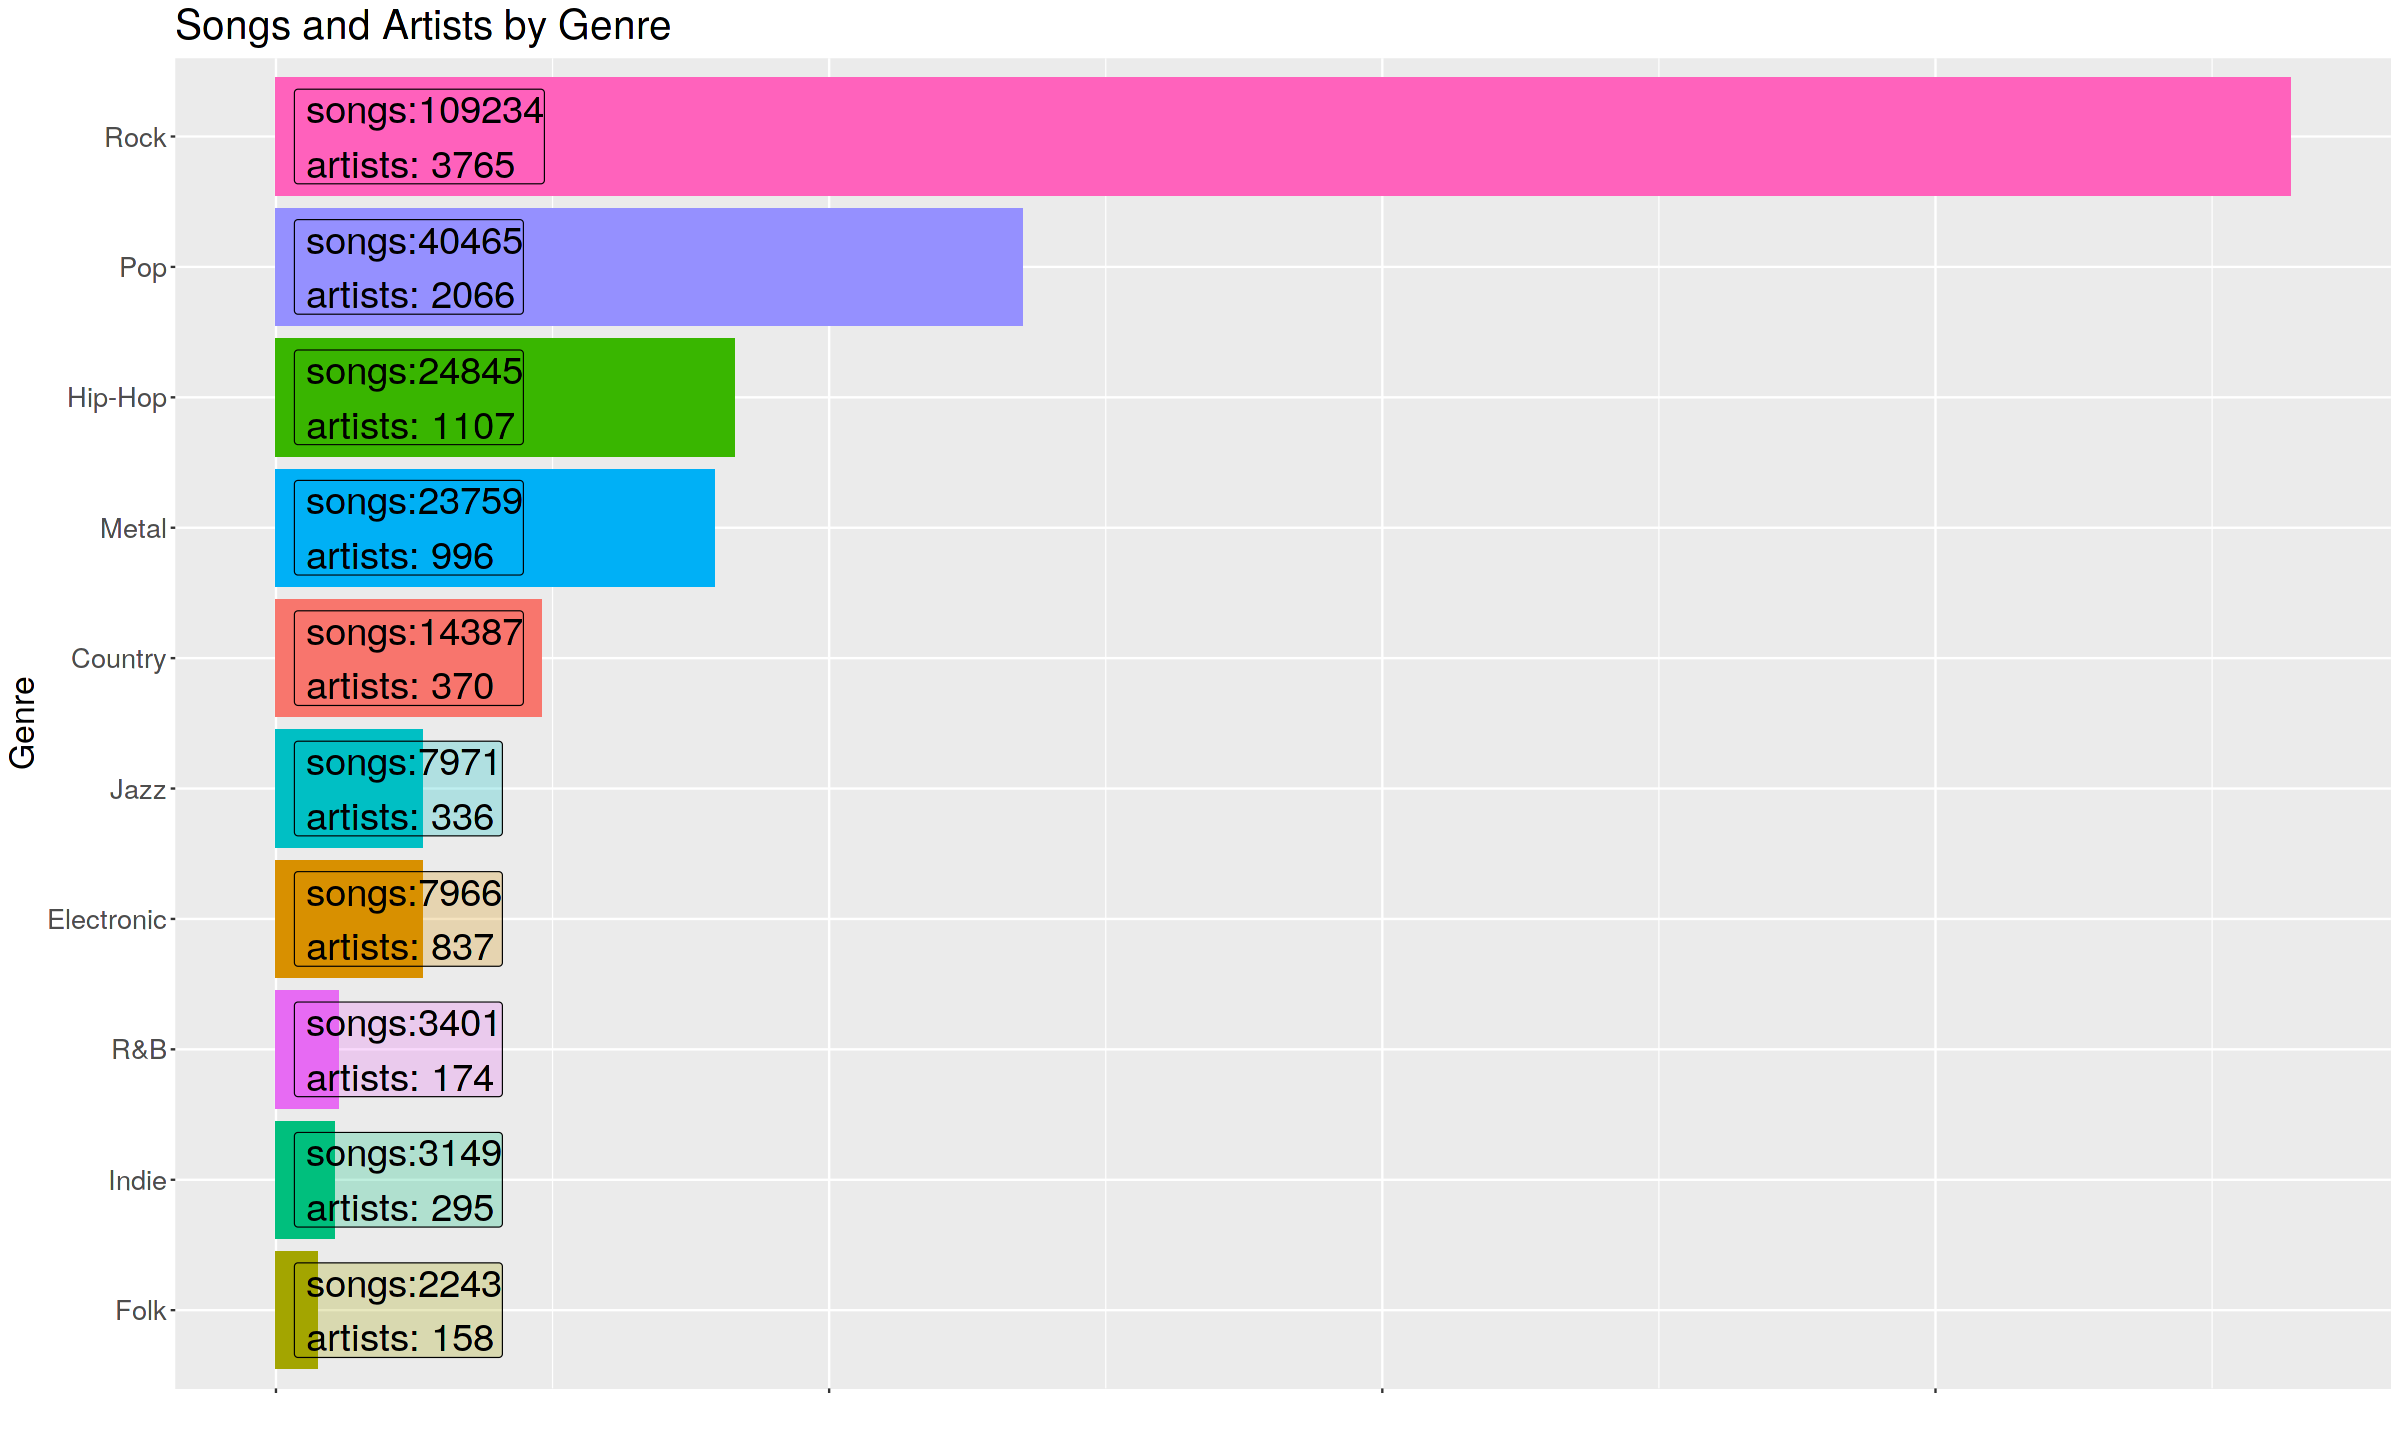

In [7]:
## ---- number_of_observations_per_genre----|

start = Sys.time()

temp <- group_by(lyrics, genre) %>%
  summarise(songs = n(),
            artists = length(unique(artist))) %>% 
  arrange(desc(songs))

ggplot(data = temp, aes(x = fct_reorder(genre, songs), y = songs)) +
    geom_bar(stat = 'identity', aes(fill = genre)) +
    geom_label(aes(label = paste('songs:', songs, '\nartists: ', artists, sep = ''),
                   y = 1000, fill = genre), size = 8, hjust = 'left', alpha = 0.25) +
    coord_flip() +
    xlab('Genre') +
    ylab('') +
    labs(title = 'Songs and Artists by Genre') +
    theme(legend.position = 0,
         text = element_text(size = 20),
         axis.text.x = element_blank())

end = Sys.time()
mem = pryr::mem_used()

WriteLog('plot obs per genre', start, end, mem)

## ---- end-of-number_of_observations_per_genre----|


* Quantidade de músicas e artistas por década.

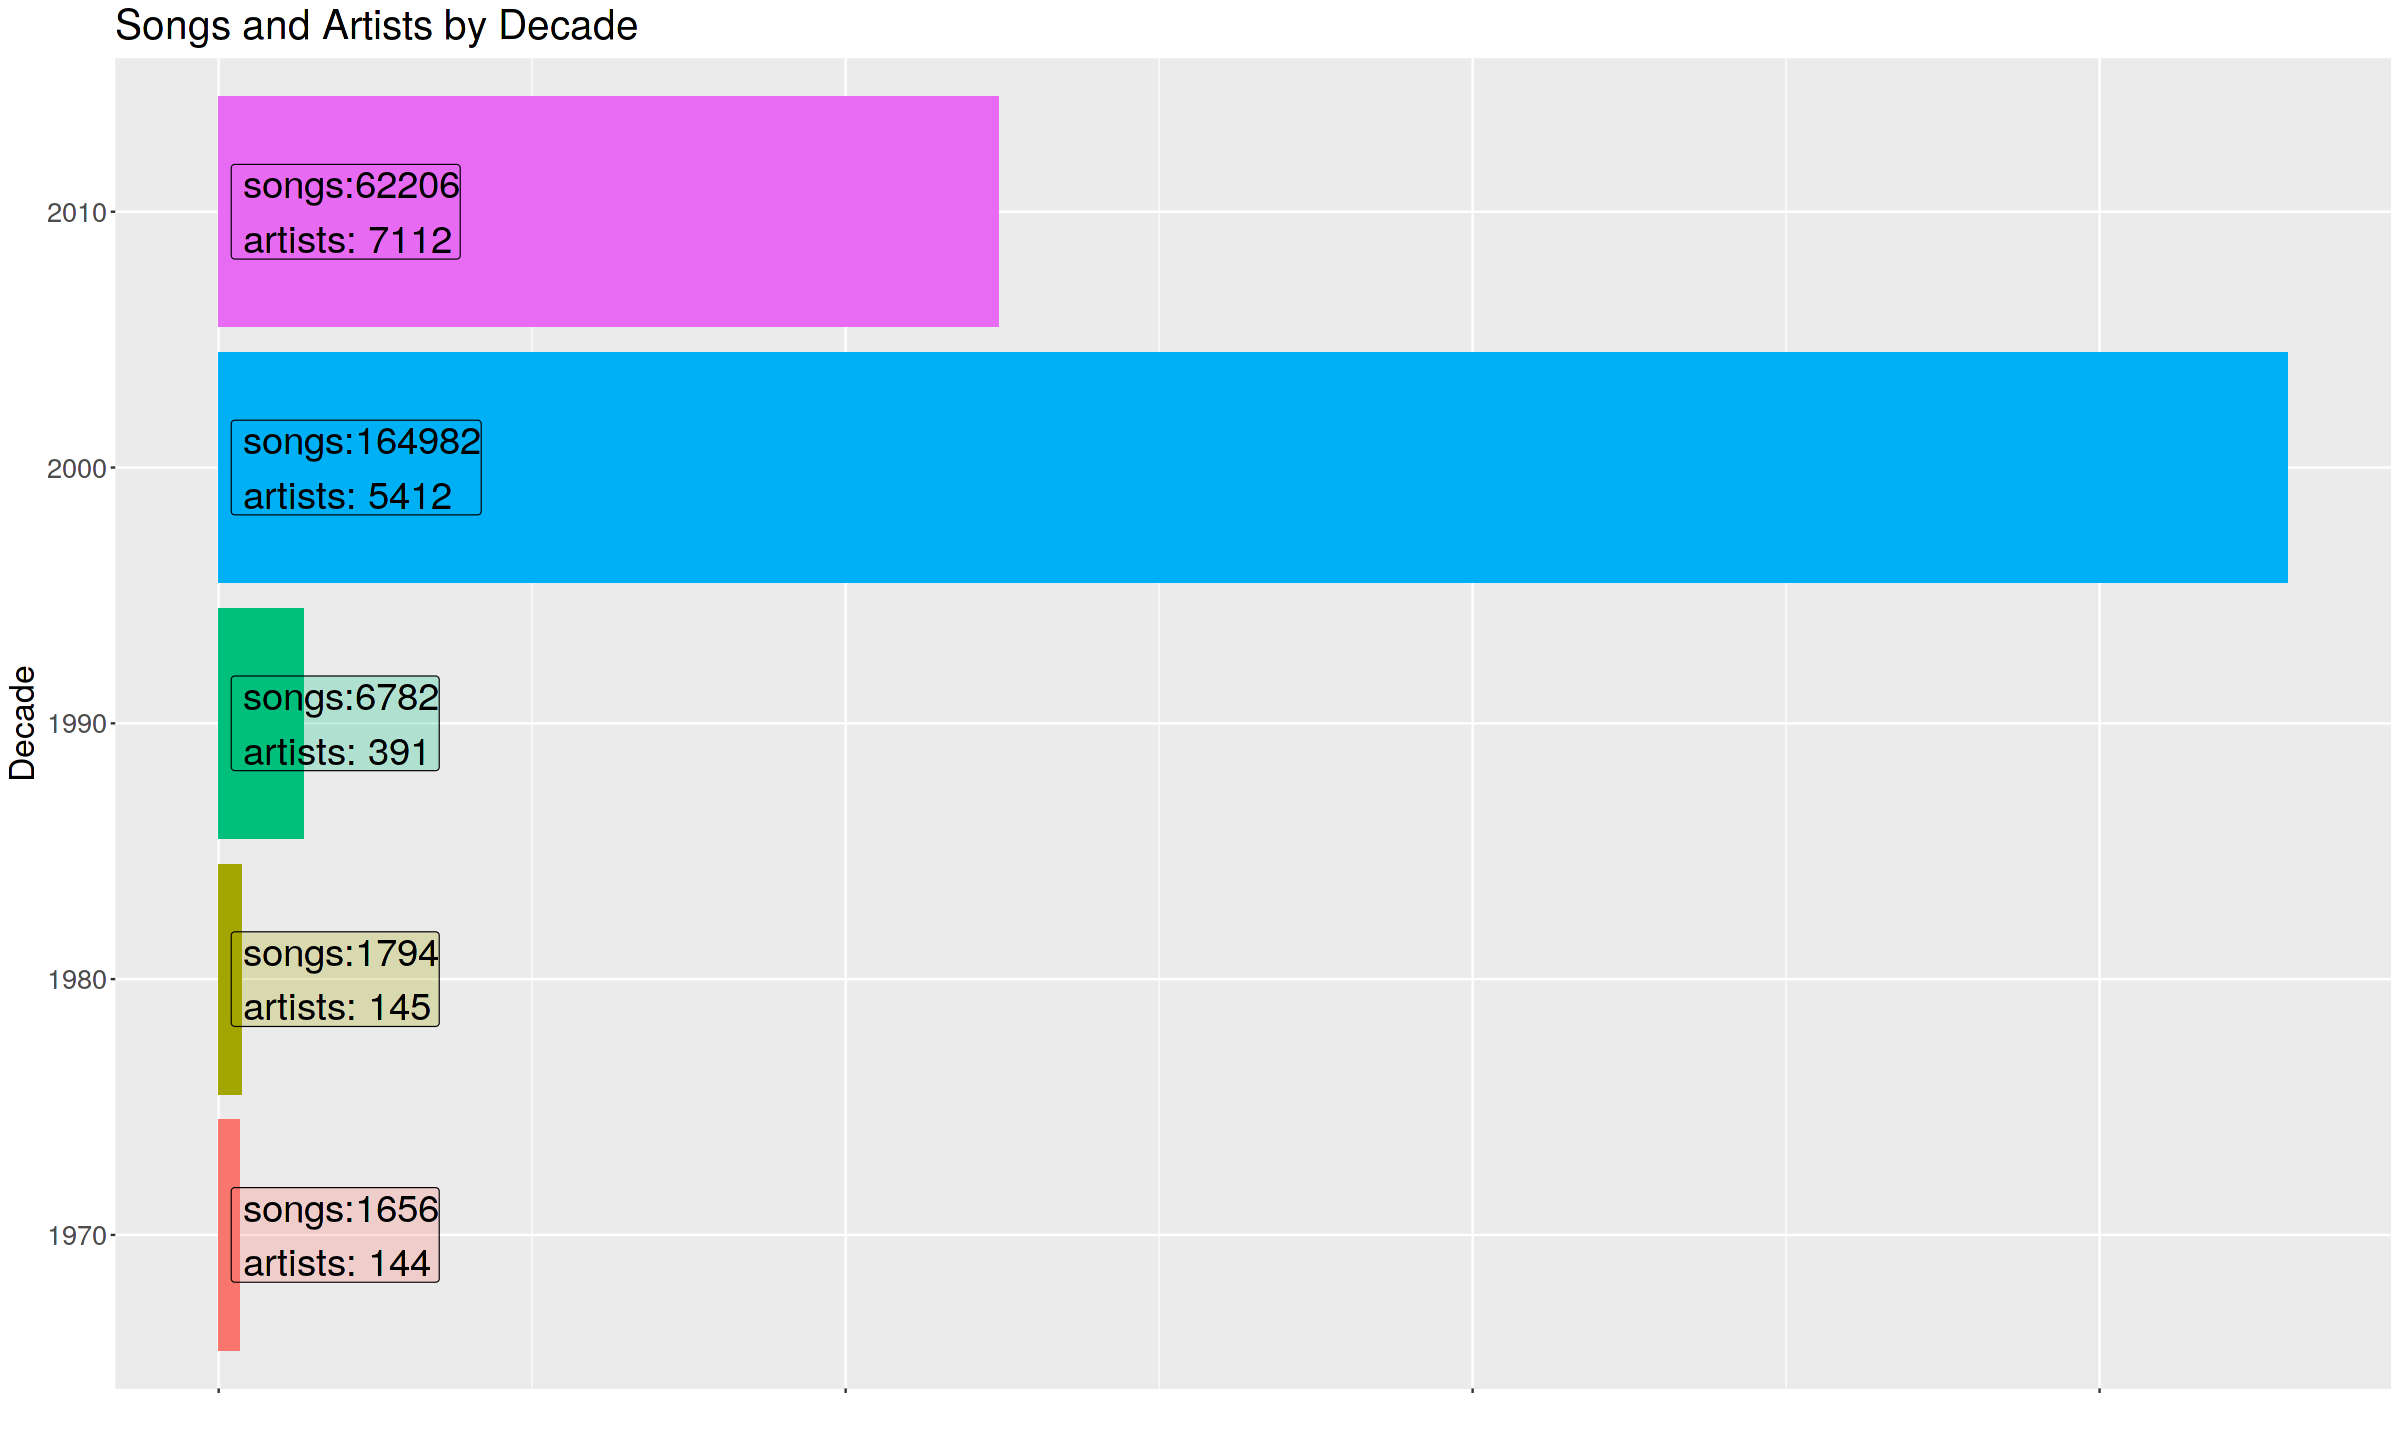

In [8]:
## ---- number_of_observations_per_decade----|

start = Sys.time()

temp  <- group_by(lyrics, decade) %>% 
            summarise(songs = n(),
                      artists = length(unique(artist))) %>% 
            arrange(desc(decade))

ggplot(data = temp, aes(x = decade, y = songs)) +
    geom_bar(stat = 'identity', aes(fill = decade)) +
    geom_label(aes(label = paste('songs:', songs, '\nartists: ', artists, sep = ''),
                   y = 1000, fill = decade), size = 8, hjust = 'left', alpha = 0.25) +
    coord_flip() +
    xlab('Decade') +
    ylab('') +
    labs(title = 'Songs and Artists by Decade') +
    theme(legend.position = 0,
         text = element_text(size = 20),
         axis.text.x = element_blank())

end = Sys.time()
mem = pryr::mem_used()

WriteLog('plot obs per decade', start, end, mem)

## ---- end-of-number_of_observations_per_decade----|


* Top 3 artistas, em relação a quantidade de músicas, por gênero.

In [9]:
## ---- top_artists----|

start = Sys.time()

count(lyrics, genre, artist, sort = TRUE) %>% 
  group_by(genre) %>% 
  arrange(desc(n)) %>% 
  filter(row_number() <= 3) %>% 
  arrange(desc(genre), desc(n))

end = Sys.time()
mem = pryr::mem_used()

WriteLog('plot top artists', start, end, mem)

## ---- end-of-top_artists----|


genre      artist                  n  
1  Rock       elton-john              676
2  Rock       bob-dylan               596
3  Rock       david-bowie             570
4  R&B        babyface                367
5  R&B        aretha-franklin         282
6  R&B        brian-mcknight          214
7  Pop        barbra-streisand        607
8  Pop        bee-gees                591
9  Pop        american-idol           568
10 Metal      fall                    368
11 Metal      cradle-of-filth         183
12 Metal      anthrax                 183
13 Jazz       ella-fitzgerald         571
14 Jazz       dean-martin             560
15 Jazz       frank-sinatra           417
16 Indie      devendra-banhart        141
17 Indie      dar-williams            102
18 Indie      the-blood-brothers       85
19 Hip-Hop    chris-brown             628
20 Hip-Hop    eminem                  578
21 Hip-Hop    50-cent                 398
22 Folk       clannad                 194
23 Folk       celtic-woman            125
24 Folk       gordon-lightfoot         91
25 Electronic bjrthrk                 237
26 Electronic david-guetta            149
27 Electronic everything-but-the-girl 134
28 Country    dolly-parton            744
29 Country    eddy-arnold             591
30 Country    bill-anderson           466

# Análise Exploratória de Dados

## Análise de palavras mais comuns.

Vamos utilizar o pacote *`tidytext`* para tokenizar os termos em um dataframe contendo uma palavra por linha.

In [10]:
## ---- get_tokens----|

start  <- Sys.time()

lyrics_token <- unnest_tokens(lyrics,
                              input = lyrics,
                              output = word,
                              token = 'words',
                              drop = TRUE,
                              to_lower = TRUE)

print(paste('Número de observações: ', length(lyrics_token$index)))

end  <- Sys.time()
mem = pryr::mem_used()

WriteLog('get tokens', start, end, mem)

## ---- end-of-get_tokens----|


[1] "Número de observações:  54725191"


In [11]:
rm(lyrics)
invisible(gc())


Algumas músicas, ou mesmo parte da letra, estão em outros idiomas além do inglês. <br>

Para resolver isso vamos aplicar mais dois filtros, onde eliminamos termos que não iniciam com letras `{a- z}`e stop words em outros idiomas de origem latina.

Também eliminamos palavras com menos de 3 caracteres, uma vez que usualmente estas não representam tópicos ou temas relevantes.

Adicionalmente utilizamos o dicionário de sentimentos `bing` para associar o sentimento a cada palavra do dataset.

In [12]:
## ---- eliminating_stopwords----|

start  <- Sys.time()

custom_stop_words <- c(tm::stopwords("german"), tm::stopwords("spanish"), 
                       tm::stopwords("portuguese"), tm::stopwords("french"),
                       stop_words$word, 'chorus', 'repeat', 'versus', 'chorus:repeat', 
                       'instrumental')

lyrics_token <- filter(lyrics_token,
                       str_detect(word, '^[a-z]') &
                       !(word %in% custom_stop_words) &
                       nchar(word) >= 3)

bing = get_sentiments('bing')
lyrics_token$sentiment = plyr::mapvalues(lyrics_token$word, 
                                         bing$word, bing$sentiment, 
                                         warn_missing = FALSE)

lyrics_token$sentiment = if_else(!(lyrics_token$sentiment %in% c('positive', 'negative')), 
                                    'neutral', lyrics_token$sentiment)

print(paste('Número de observações após a eleminação das stop words: ', 
            length(lyrics_token$index)))

sample_n(lyrics_token, size = 15)

count_words <- count(lyrics_token, word, sentiment, sort = TRUE)

# saving datasets for later use.
saveRDS(lyrics_token, 'lyrics_token.rds')
saveRDS(count_words, 'count_words.rds')

mem  <- pryr::mem_used()
rm(bing, count_words)
invisible(gc)

end = Sys.time()

WriteLog('save token lyrics', start, end, mem)

## ---- end-of-eliminating_stopwords----|


[1] "Número de observações após a eleminação das stop words:  18430707"


index  song                             year artist                 genre  
1  147018 fallin-in-love                   2006 david-hasselhoff       Rock   
2  153438 afraid-with-you                  2016 christon-gray          Hip-Hop
3   60995 down                             2007 cross-canadian-ragweed Rock   
4  362145 run                              2013 dub-fx                 Hip-Hop
5  251805 miento-cuando-digo-que-lo-siento 2013 enrique-bunbury        Rock   
6  359258 365                              2010 black-milk             Hip-Hop
7  264859 everything-glorious              2007 david-crowder          Rock   
8  105229 the-dope-man                     2004 cam-ron                Hip-Hop
9   16960 poison                           2008 adrienne-young         Country
10 120405 for-ur-love                      2009 chris-brown            Hip-Hop
11  33902 war-battlecry-remix              2006 bone-thugs-n-harmony   Hip-Hop
12 266790 la-boda                          2014 aventura               Pop    
13 251581 picture-pains                    2006 grammatrain            Rock   
14 132229 leve                             2016 cartel-de-santa        Hip-Hop
15 156815 inner-logic                      2006 bad-religion           Rock   
   decade word       sentiment
1  2000   gate       neutral  
2  2010   true       neutral  
3  2000   swore      neutral  
4  2010   connecting neutral  
5  2010   control    neutral  
6  2010   wrong      negative 
7  2000   glorious   positive 
8  2000   mound      neutral  
9  2000   poison     negative 
10 2000   hope       neutral  
11 2000   focus      neutral  
12 2010   ama        neutral  
13 2000   wondering  neutral  
14 2010   dije       neutral  
15 2000   stroll     neutral

De posse do dataset organizado, vamos iniciar com a contagem relativa dos termos por gênero musical.

In [13]:
## ---- count_tokens----|

start  <- Sys.time()

gw <- group_by(lyrics_token, genre, sentiment, word) %>%
  summarise(gw_c = n()) %>% 
  ungroup() %>% 
  group_by(genre) %>%
  mutate(gw_p = gw_c / sum(gw_c)) %>% 
  ungroup() %>%
  arrange(genre, desc(gw_p)) %>% 
  group_by(word) %>% 
  mutate(w_c = sum(gw_c))

# contagem por palavra
w <- group_by(lyrics_token, sentiment, word) %>%
  summarise(w_c = n()) %>% 
  ungroup() %>%
  mutate(w_p = w_c / sum(w_c)) %>%
  arrange(desc(w_c))

mem  <- pryr::mem_used()
rm(lyrics_token)
invisible(gc)

end = Sys.time()

WriteLog('count tokens', start, end, mem)

## ---- end-of-count_tokens----|


Vamos iniciar a exploração observando as 100 palavras mais comuns, por sentimento, encontradas no dataset como um todo.

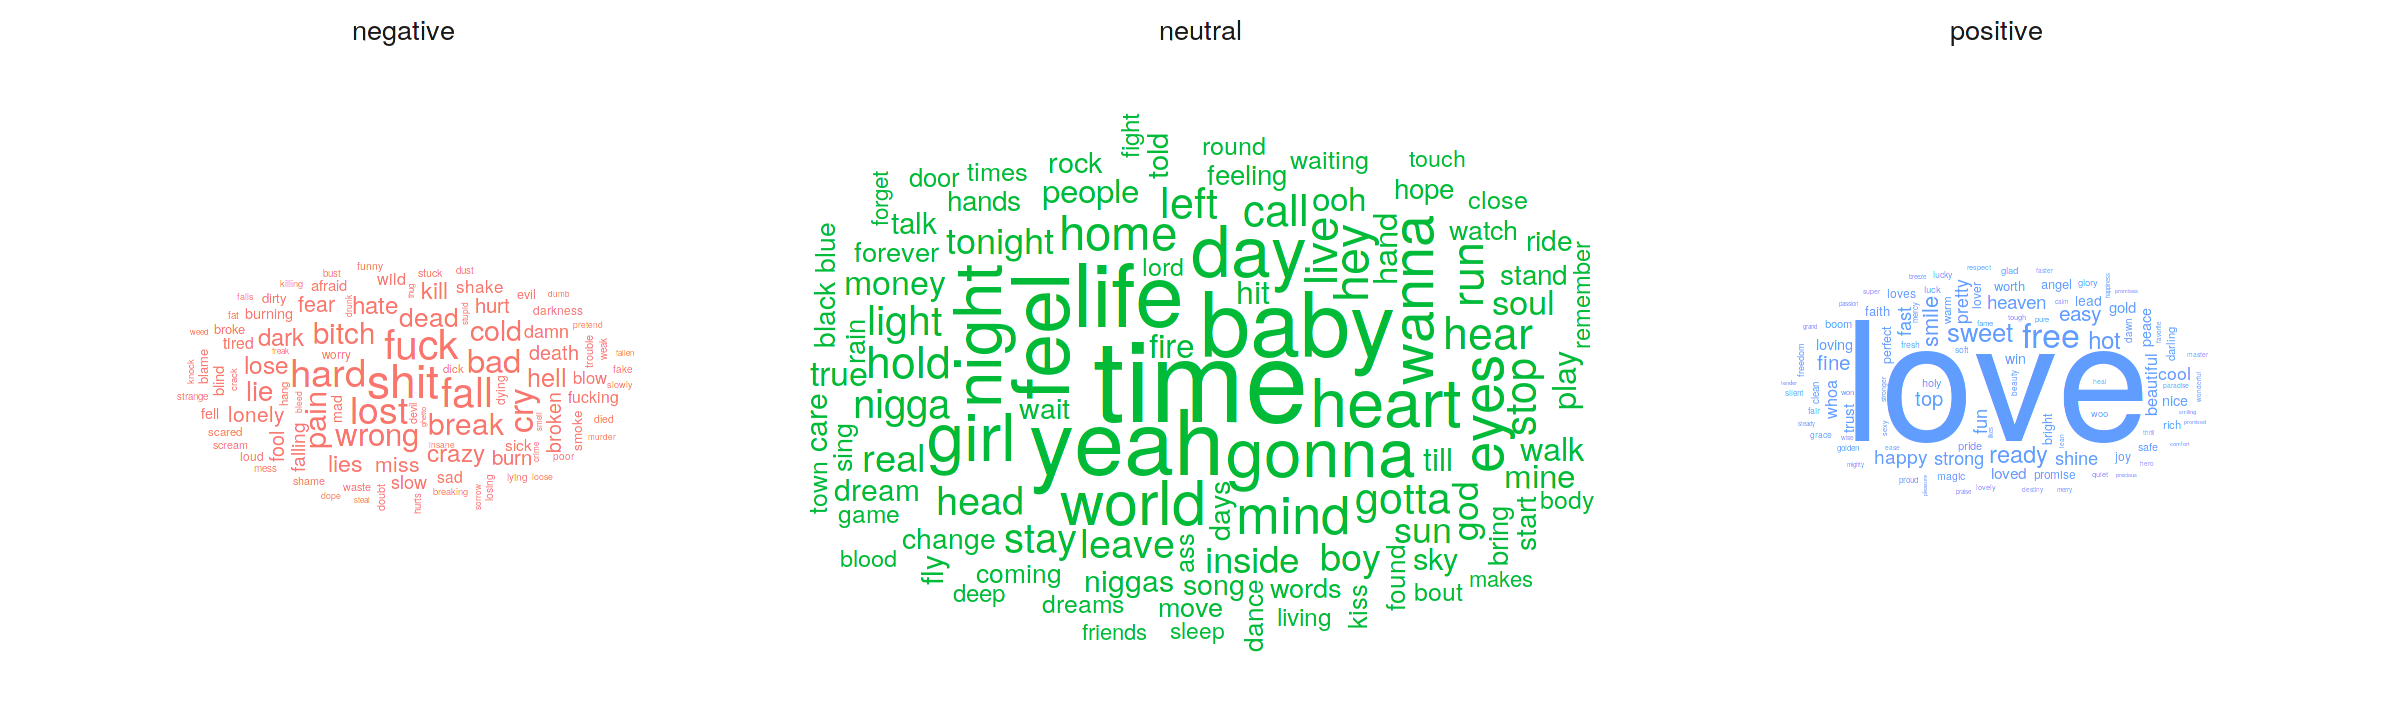

In [14]:
## ---- view_wordcloud_token----|

start  <- Sys.time()

temp <- group_by(w, sentiment) %>% 
    arrange(desc(w_c)) %>% 
    filter(row_number() < 101) %>% 
    mutate(angle = 90 * sample(c(0, 1), n(), replace = TRUE, prob = c(70, 30)),
          freq_sd = (w_c - min(w_c)) / (max(w_c) - min(w_c))) %>% 
    ungroup()

options(repr.plot.width = 20, repr.plot.height = 6)

plt  <- ggplot(data = temp,
  aes(label = word, 
      size = w_c,
      color = factor(sentiment), 
      angle = angle)) +
  geom_text_wordcloud_area(eccentricity = 0.65) +
  facet_wrap(vars(sentiment), nrow = 1) +
  scale_size_area(max_size = 35) +
  theme_minimal() +
  theme(text = element_text(size = 20))

suppressWarnings(print(plt))

mem  <- pryr::mem_used()
rm(w)
invisible(gc)

end = Sys.time()

WriteLog('token lyrics wordcloud', start, end, mem)

## ---- end-of-view_wordcloud_token----|


Também podemos verificar as palavras mais utilizadas por sentimento e gênero musical.
 
Aqui o tamanho de cada termo é dado pela frequência de cada combinaçao de sentimento e gênero musical, de forma que quanto maior a nuvem de palavra maior a diversidade de palavras utilizadas para o a combinação de sentimento e gênero musical.

Podemos observar quem em geral os temas positivos estão concentrados na palavra *"love"*, para as palavras neutras a predominância da palavra *"time"*, já os temas negativos são muito mais diversos entre os gêneros musicais.


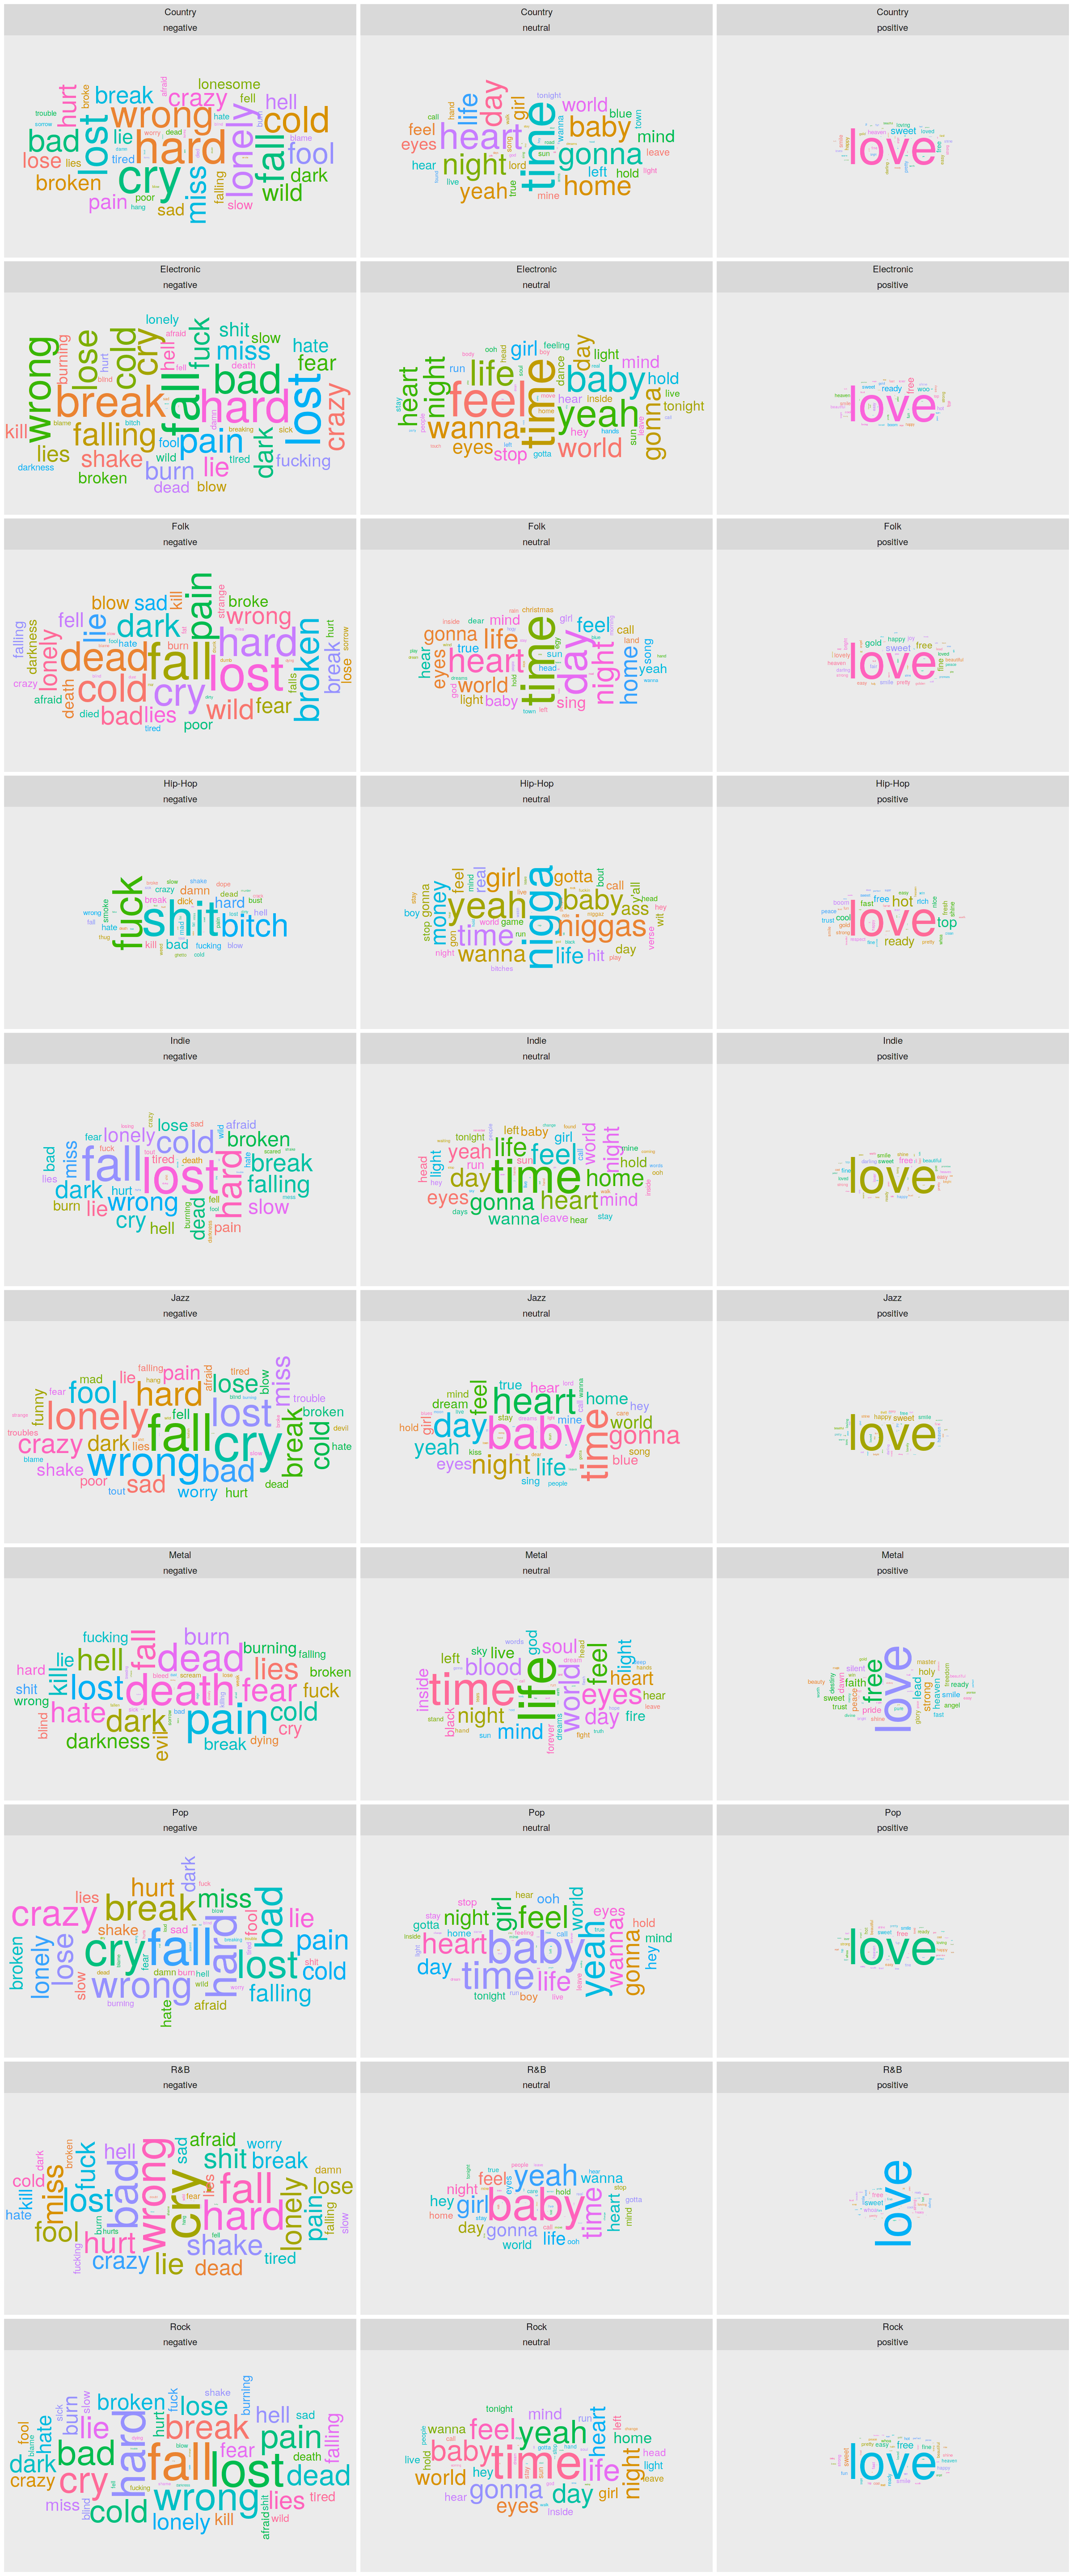

In [15]:
## ---- wordcloud_per_genre_token----|

start <- Sys.time()

temp <- group_by(gw, genre, sentiment) %>%  
    arrange(desc(gw_p)) %>% 
    filter(row_number() < 51) %>%
    mutate(angle = 90 * sample(c(0, 1), n(), replace = TRUE, prob = c(70, 30)), 
           freq_sd = (gw_c - min(gw_c)) / (max(gw_c) - min(gw_c))) %>% 
    ungroup()

options(repr.plot.width = 20, repr.plot.height = 48)

plt <- ggplot(data = temp,
  aes(label = word, 
      size = freq_sd,
      color = factor(sample.int(20, nrow(temp), replace = TRUE)), 
      angle = angle)) +
  geom_text_wordcloud_area() +
  scale_size_area(max_size = 25) +
  facet_wrap(genre ~ sentiment, nrow = 10) +
  theme(text = element_text(size = 15))

suppressWarnings(print(plt))

end = Sys.time()
mem = pryr::mem_used()

WriteLog('token lyrics wordcloud per genre', start, end, mem)

## ---- end-of-wordcloud_per_genre_token----|


Na sequência vamos verificar se as 10 palavras mais comuns são uniformes entre os gêneros musicais presentes no dataset.

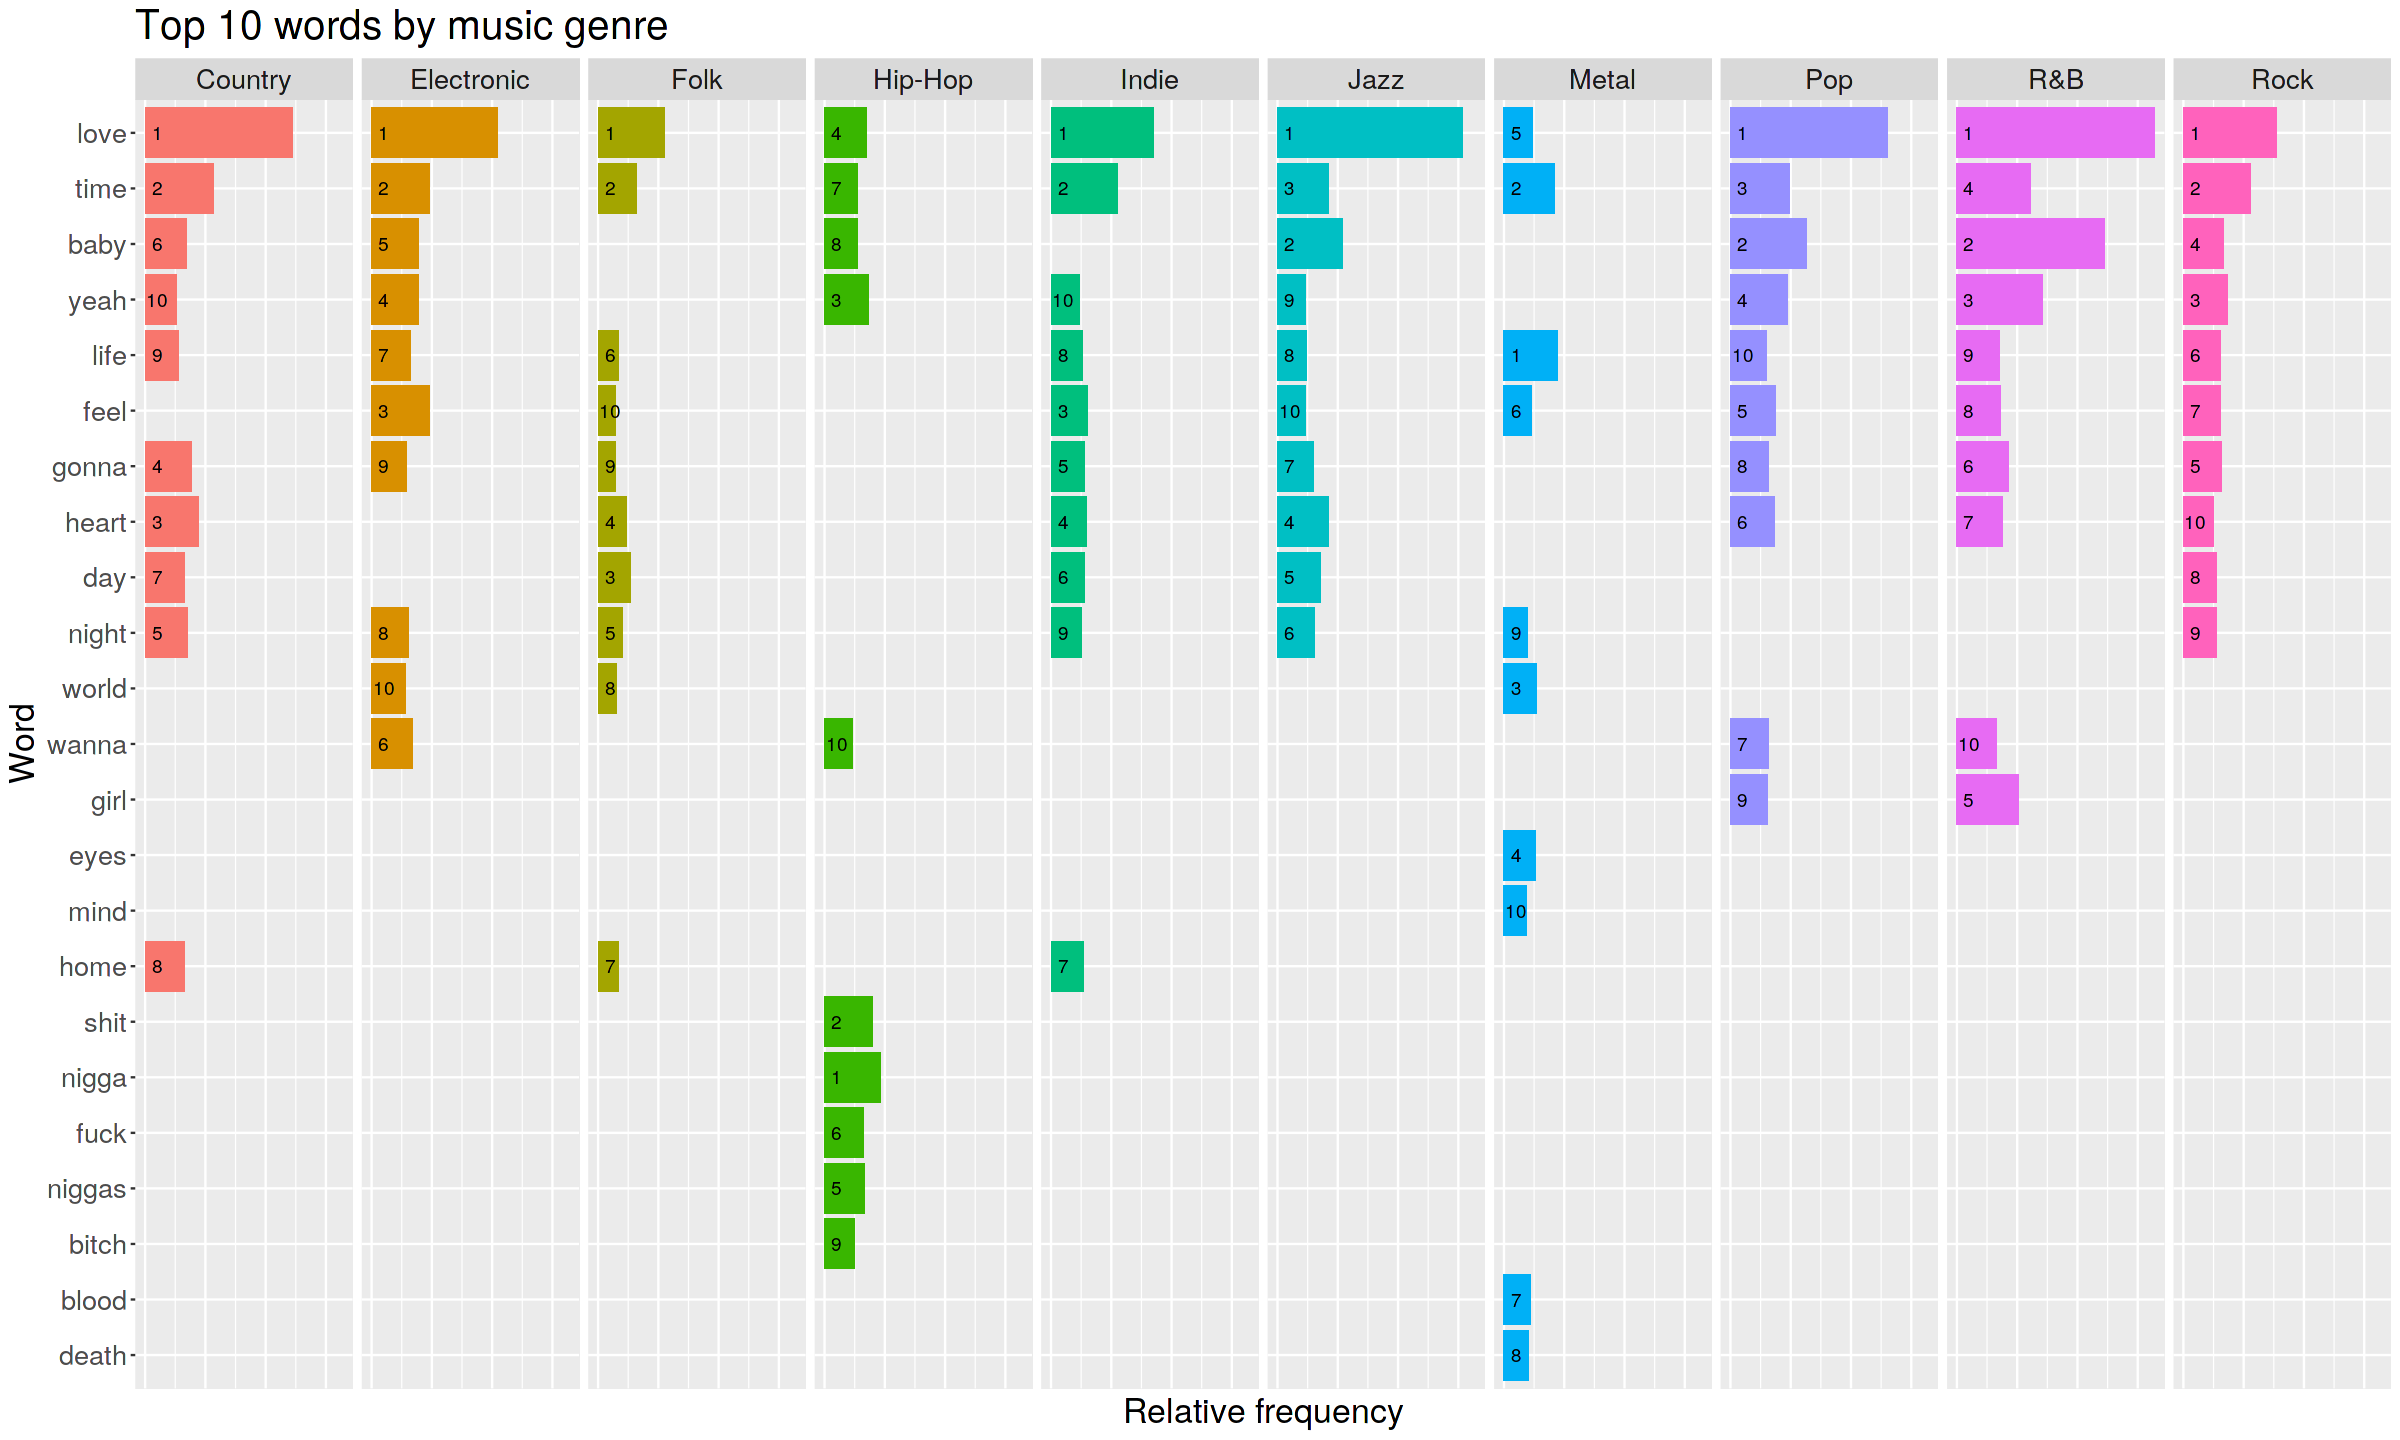

In [16]:
## ---- top_10_words_token----|

start = Sys.time()

options(repr.plot.width = 20, repr.plot.height = 12)

gw %>%
  group_by(genre) %>% 
  arrange(desc(gw_p)) %>% 
  filter(row_number() <= 10) %>%
  mutate(rank = row_number()) %>% 
  ggplot() +
  geom_bar(stat = 'identity',
           aes(y = gw_p, x = fct_reorder(word, w_c), fill = genre)) +
  geom_text(aes(label = as.character(rank), x = fct_reorder(word, w_c), y = 0.002)) +
  facet_wrap(vars(genre), nrow = 1) +
  coord_flip() +
  xlab('Word') +
  ylab('Relative frequency') +
  labs(title = 'Top 10 words by music genre') +
  theme(legend.position = 0,
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        text = element_text(size = 20))

rm(gw)
invisible(gc)

end = Sys.time()
mem = pryr::mem_used()

WriteLog('plot top words', start, end, mem)

## ---- end-of-top_10_words_token----|


Como podemos observar pelo gráfico acima em geral as top 10 palavras são as mesmas entre os gêneros, porém, os gêneros *Metal* e *Hip-Hop* se destacam com diferentes temas em relação aos demais gêneros. <br>
 
Também observamos que *Country, Folk* e *Indie* abordam com maior frequência o tema "*Home*" em relação aos demais.

## Análise de Bigramas

Além da análise das palavras mais comuns podemos explorar quais são os Bigramas mais comuns.

In [17]:
## ---- get_tokens_bigrams----|

start  <- Sys.time()

lyrics <- readRDS('lyrics.rds')

lyrics_token_bi <- unnest_tokens(lyrics,
                                 input = lyrics,
                                 output = term,
                                 token = 'ngrams',
                                 drop = TRUE,
                                 to_lower = TRUE,
                                 n = 2)

print(paste('Número de termos: ', nrow(lyrics_token_bi)))

end = Sys.time()
mem = pryr::mem_used()

WriteLog('get tokens bigrams', start, end, mem)

## ---- end-of-get_tokens_bigrams----|


[1] "Número de termos:  54492310"


Agora separamos o bigrama em duas palavras para eliminarmos as observações que contem stop words assim como fizemos com o a análise de palavras individuais. <br>

In [18]:
rm(lyrics, plt, temp)
invisible(gc())


Iremos eliminar as linhas onde ao menos uma das palavras do bigrama é uma stop words.
 
Além das stop words, por estarmos analisando letras de músicas, também vamos excluir as observações com palavras repetidas.

In [19]:
## ---- clean_bigrams----|

start  <- Sys.time()

lyrics_token_bi <- separate(lyrics_token_bi, term, 
                            sep = ' ',
                            into = c('w1', 'w2'), 
                            remove = FALSE)

lyrics_token_bi <- filter(lyrics_token_bi, w1 != w2)

lyrics_token_bi <- filter(lyrics_token_bi, nchar(w1) >= 3, nchar(w2) >= 3)

invisible(gc())

lyrics_token_bi <- filter(lyrics_token_bi, 
                          !(w1 %in% custom_stop_words) & str_detect(w1, '^[a-z]'))

lyrics_token_bi <- filter(lyrics_token_bi, 
                          !(w2 %in% custom_stop_words) & str_detect(w2, '^[a-z]'))

saveRDS(lyrics_token_bi, 'lyrics_token_bi.rds')

print(paste('Número de termos apos eliminação de stop words: ', 
            nrow(lyrics_token_bi)))

mem  <- pryr::mem_used()

rm(lyrics_token_bi)
invisible(gc)

end = Sys.time()

WriteLog('save tokens lyrics bigrams', start, end, mem)

## ---- end-of-clean_bigrams----|


[1] "Número de termos apos eliminação de stop words:  5221340"


Vamos criar uma função para gerar um diagrama de rede com os 5 bigramas mais comuns para cada palavra selecionadas.

In [20]:
## ---- plot_network----|

plot_network <- function(top_words = 25, 
                         artist_filter = NULL, 
                         genre_filter = NULL) {
    # load required data
    count_words  <- readRDS('lyrics_token.rds')
    data         <- readRDS('lyrics_token_bi.rds')
    
    # apply filters

    if (!is.null(artist_filter)) {count_words  <- filter(count_words, 
                                                         artist %in% artist_filter)}
    
    if (!is.null(genre_filter)) {count_words   <- filter(count_words, 
                                                         genre %in% genre_filter)}
    
    count_words  <- count(count_words, word, sentiment, sort = TRUE)
    
    top_words <- filter(count_words, row_number() <= top_words)
    
    if (!is.null(artist_filter)) {data  <- filter(data, 
                                                  artist %in% artist_filter)}
    
    if (!is.null(genre_filter)) {data  <- filter(data, 
                                                 genre %in% genre_filter)}
    
    data <- group_by(data, w1, w2) %>% 
               summarise(count = n()) %>%
               ungroup() %>%
               mutate(percent = count / sum(count)) %>%
               group_by(w1) %>%
               arrange(desc(count)) %>%
               filter(row_number() <= 5) %>% 
               ungroup() %>% 
               filter(w1 %in% top_words$word)

    # set nodes
    nodes = tibble(label = unique(c(data$w1, data$w2)))
    
    nodes = tibble::rowid_to_column(nodes, "id")
    
    nodes$value = plyr::mapvalues(nodes$label, count_words$word, 
                                  count_words$n, warn_missing = FALSE)
    
    nodes$value = as.numeric(nodes$value)
    
    nodes$value = (nodes$value - min(nodes$value)) / 
                                    (max(nodes$value) - min(nodes$value))
    
    nodes$value = nodes$value * 100
    
    nodes$group = plyr::mapvalues(nodes$label, count_words$word, 
                                  count_words$sentiment, warn_missing = FALSE)

    # set edges
    edges  <- tibble(from   = data$w1,
                     to     = data$w2,
                     weight = data$percent)
    
    edges$from = plyr::mapvalues(edges$from, nodes$label, 
                                 nodes$id, warn_missing = FALSE)
    
    edges$to = plyr::mapvalues(edges$to, nodes$label, 
                               nodes$id, warn_missing = FALSE)

    net_graph <- visNetwork(nodes, edges, height = "500px", width = "100%") %>% 
                     visNodes(scaling = list(min = 10, max = 50), 
                              physics = TRUE, mass = 1.25) %>% 
                     visEdges(arrows = "to") %>% 
                     visOptions(highlightNearest = TRUE, 
                                nodesIdSelection = TRUE,
                                selectedBy = "group") %>%
                     visGroups(groupname = "positive", color = "green")  %>% 
                     visGroups(groupname = "neutral") %>% 
                     visGroups(groupname = "negative", color = "red") %>% 
                     visLegend(width = 0.1)
    
    rm(count_words, data)
    invisible(gc)
    
    # return graph
    return (net_graph)
}

## ---- end-of-plot_network----|


Aqui estamos vendo os 5 bigramas mais comuns para as 25 palavras mais usadas em todo o dataset.

In [21]:
## ---- plot_network_all----|

start  <- Sys.time()

net_graph <- plot_network(top_words = 25)

htmlwidgets::saveWidget(net_graph, "net_graph.html")

display_html('<iframe src="net_graph.html" width=100% height=600></iframe>')

end = Sys.time()
mem = pryr::mem_used()

WriteLog('plot net 1', start, end, mem)

## ---- end-of-plot_network_all----|


Agora podemos aplicar um filtro no dataset de bigramas e verificar a rede de bigramas de um artista em aprticular como **Bob Dylan**.

Aqui estamos vendo os 5 bigramas mais comuns para as 50 palavras mais usadas pelo artista.

In [22]:
## ---- plot_network_artist----|

start  <- Sys.time()

net_graph <- plot_network(top_words = 50, artist_filter = 'bob-dylan')

htmlwidgets::saveWidget(net_graph, "net_graph_artist.html")

display_html('<iframe src="net_graph_artist.html" width=100% height=600></iframe>')

end = Sys.time()
mem = pryr::mem_used()

WriteLog('plot net 2', start, end, mem)

## ---- end-of-plot_network_artist----|


Podemos fazer o mesmo filtro para um gênero musical específico como *Metal* e *Rock*.

In [23]:
## ---- plot_network_genre_1----|

start  <- Sys.time()

net_graph <- plot_network(top_words = 25, genre_filter = 'Metal')

htmlwidgets::saveWidget(net_graph, "net_graph_genre_1.html")

display_html('<iframe src="net_graph_genre_1.html" width=100% height=600></iframe>')

end = Sys.time()
mem = pryr::mem_used()

WriteLog('plot net 3', start, end, mem)

## ---- end-of-plot_network_genre_1----|


In [24]:
## ---- plot_network_genre_2----|

start  <- Sys.time()

net_graph <- plot_network(top_words = 25, genre_filter = 'Rock')

htmlwidgets::saveWidget(net_graph, "net_graph_genre_2.html")

display_html('<iframe src="net_graph_genre_2.html" width=100% height=600></iframe>')

end = Sys.time()
mem = pryr::mem_used()

WriteLog('plot net 4', start, end, mem)

## ---- end-of-plot_network_genre_2----|


A exemplo do que fizemos com a contagem individual de palavras vamos verificar quais os bigramas mais utilizados por gênero musical.

In [25]:
## ---- top_bigrams_token----|

start  <- Sys.time()

lyrics_token_bi <- readRDS('lyrics_token_bi.rds')

gw <- group_by(lyrics_token_bi, genre, term) %>%
  summarise(gw_c = n()) %>% 
  ungroup() %>% 
  group_by(genre) %>%
  mutate(gw_p = gw_c / sum(gw_c)) %>% 
  ungroup() %>%
  arrange(genre, desc(gw_p)) %>% 
  group_by(term) %>% 
  mutate(w_c = sum(gw_c))

# contagem por palavra
w <- group_by(lyrics_token_bi, term) %>%
  summarise(w_c = n()) %>% 
  ungroup() %>%
  mutate(w_p = w_c / sum(w_c)) %>%
  arrange(desc(w_c))

mem  <- pryr::mem_used()

rm(lyrics_token_bi)
invisible(gc)

end = Sys.time()
mem = pryr::mem_used()

WriteLog('calculate tokens lyrics bigram count', start, end, mem)

## ---- end-of-top_bigrams_token----|


Vamos verificar a nuvem de termos de bigramas.

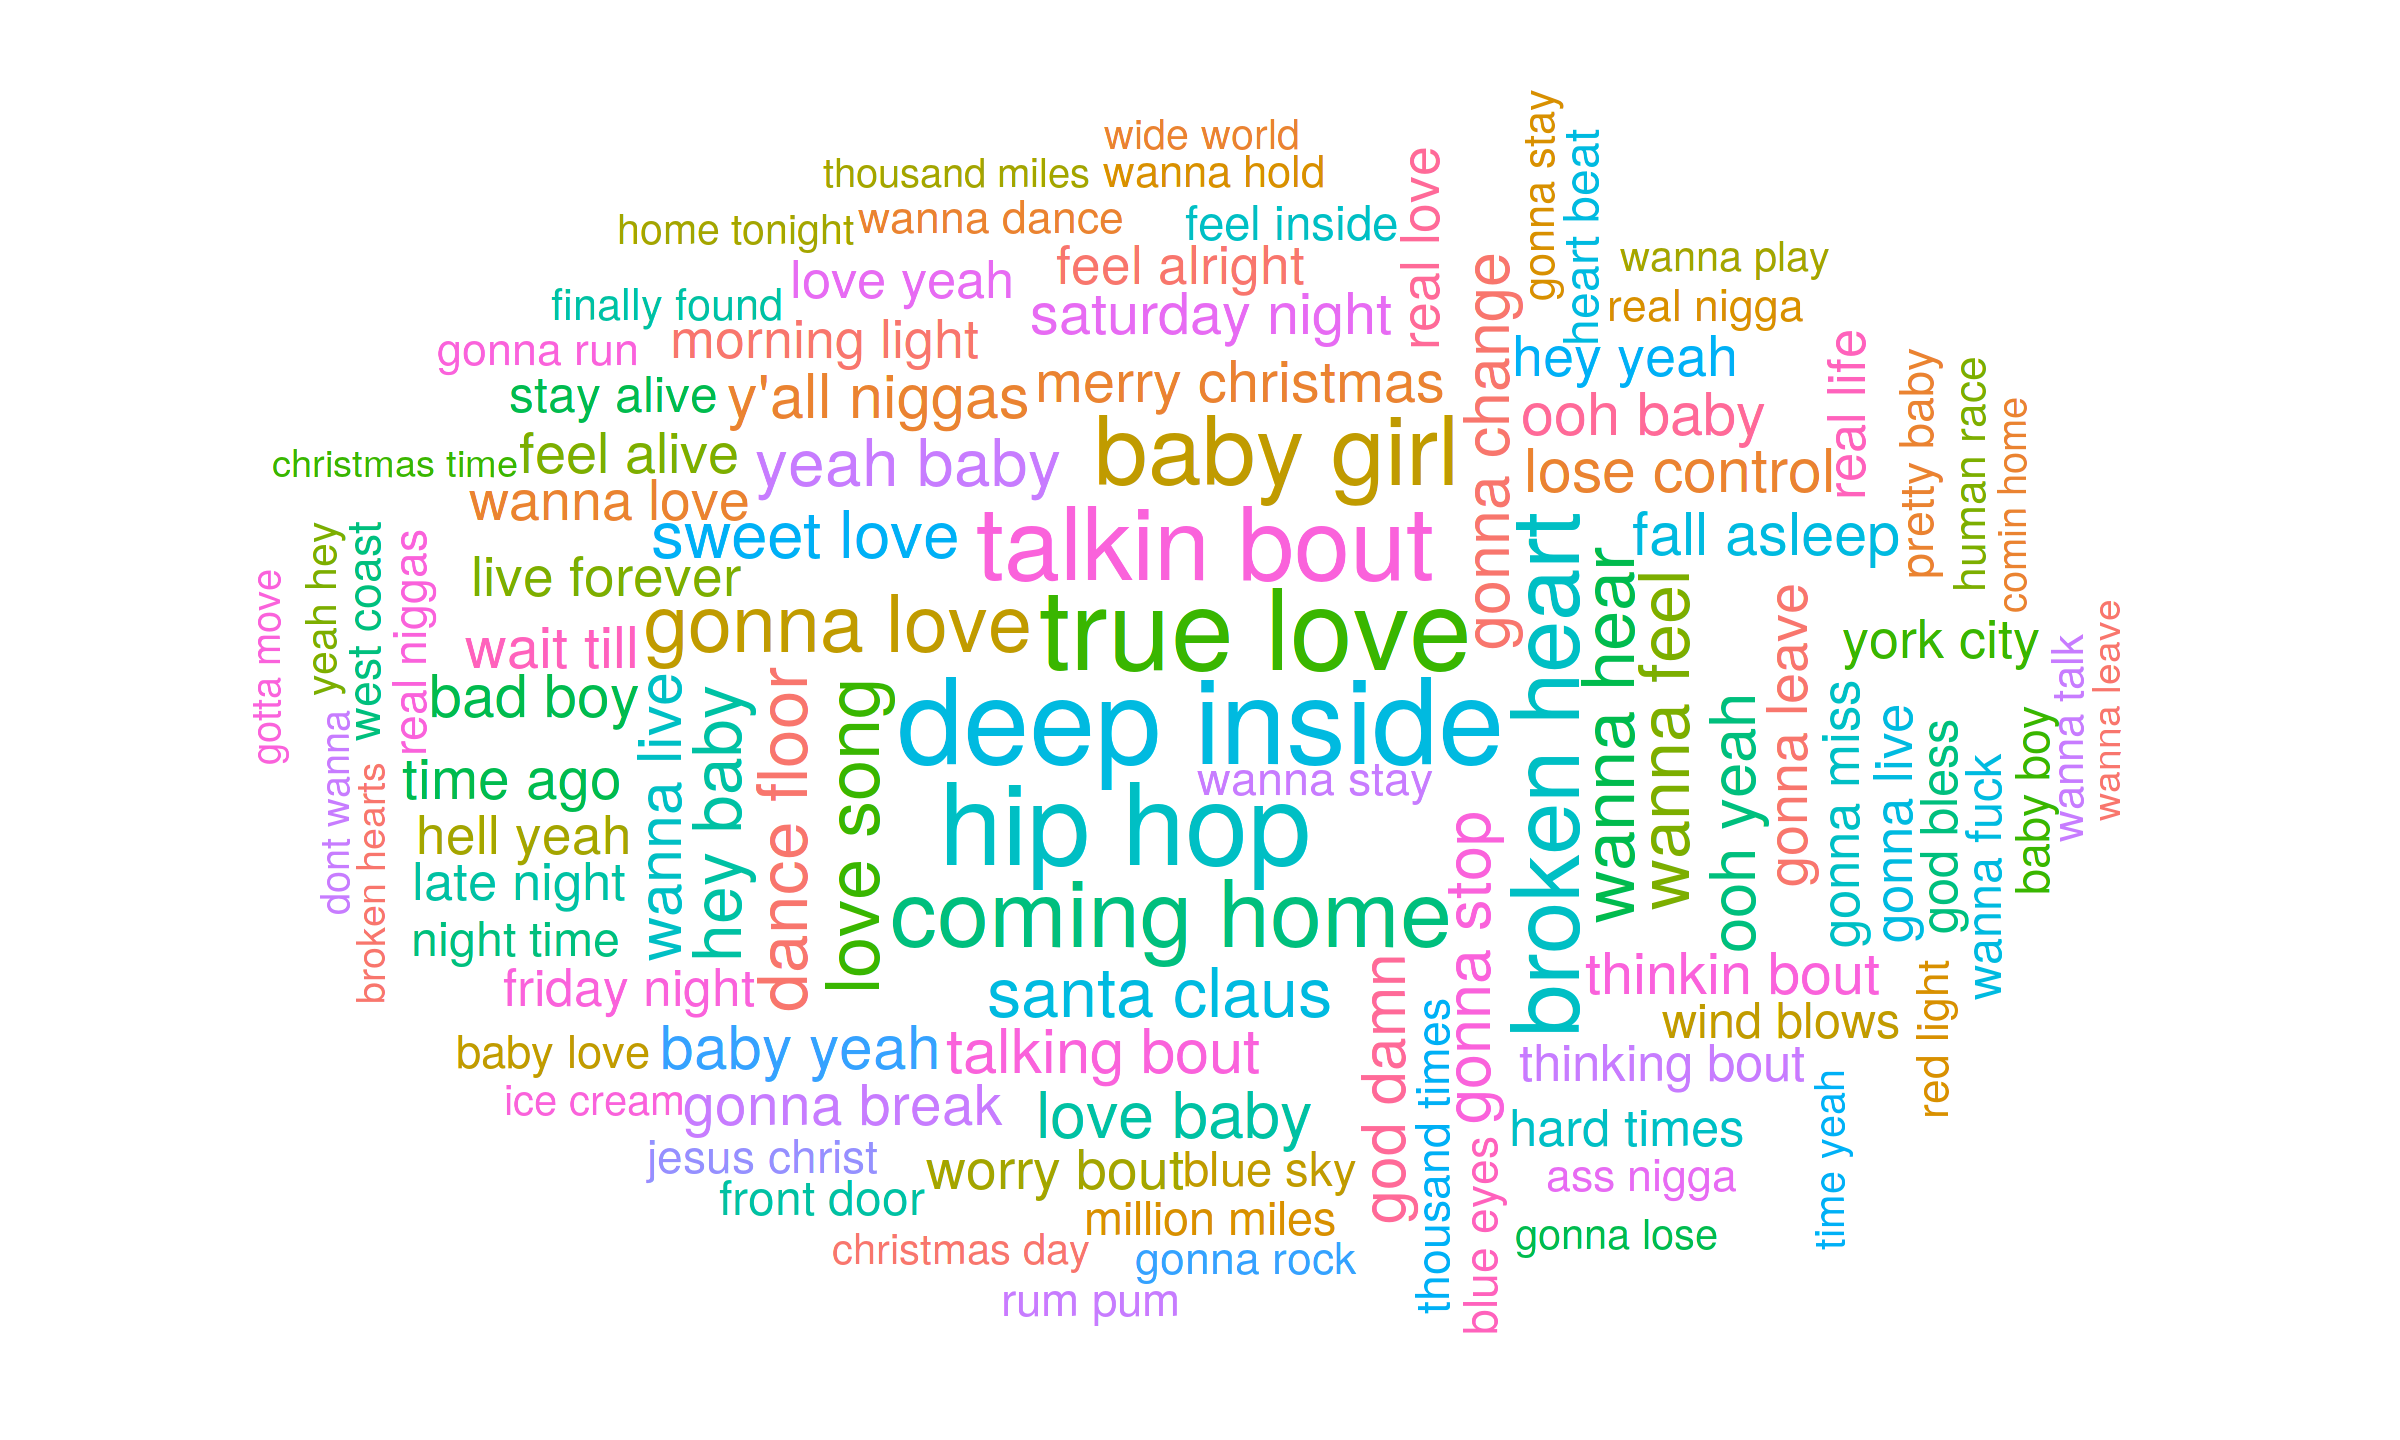

In [26]:
## ---- view_wordcloud_token_bigrams----|

start  <- Sys.time()

temp <- arrange(w, desc(w_c)) %>% 
    filter(row_number() < 101) %>% 
    mutate(angle = 90 * sample(c(0, 1), n(), replace = TRUE, prob = c(70, 30)))

plt <- ggplot(data = temp,
  aes(label = term, 
      size = w_c,
      color = factor(sample.int(20, nrow(temp), replace = TRUE)), 
      angle = angle)) +
  geom_text_wordcloud_area(eccentricity = 1.1) +
  scale_size_area(max_size = 25) +
  theme_minimal()

mem  <- pryr::mem_used()

rm(w)
invisible(gc)

suppressWarnings(print(plt))

end = Sys.time()
mem = pryr::mem_used()

WriteLog('plot tokens lyrics bigrams', start, end, mem)

## ---- end-of-view_wordcloud_token_bigrams----|


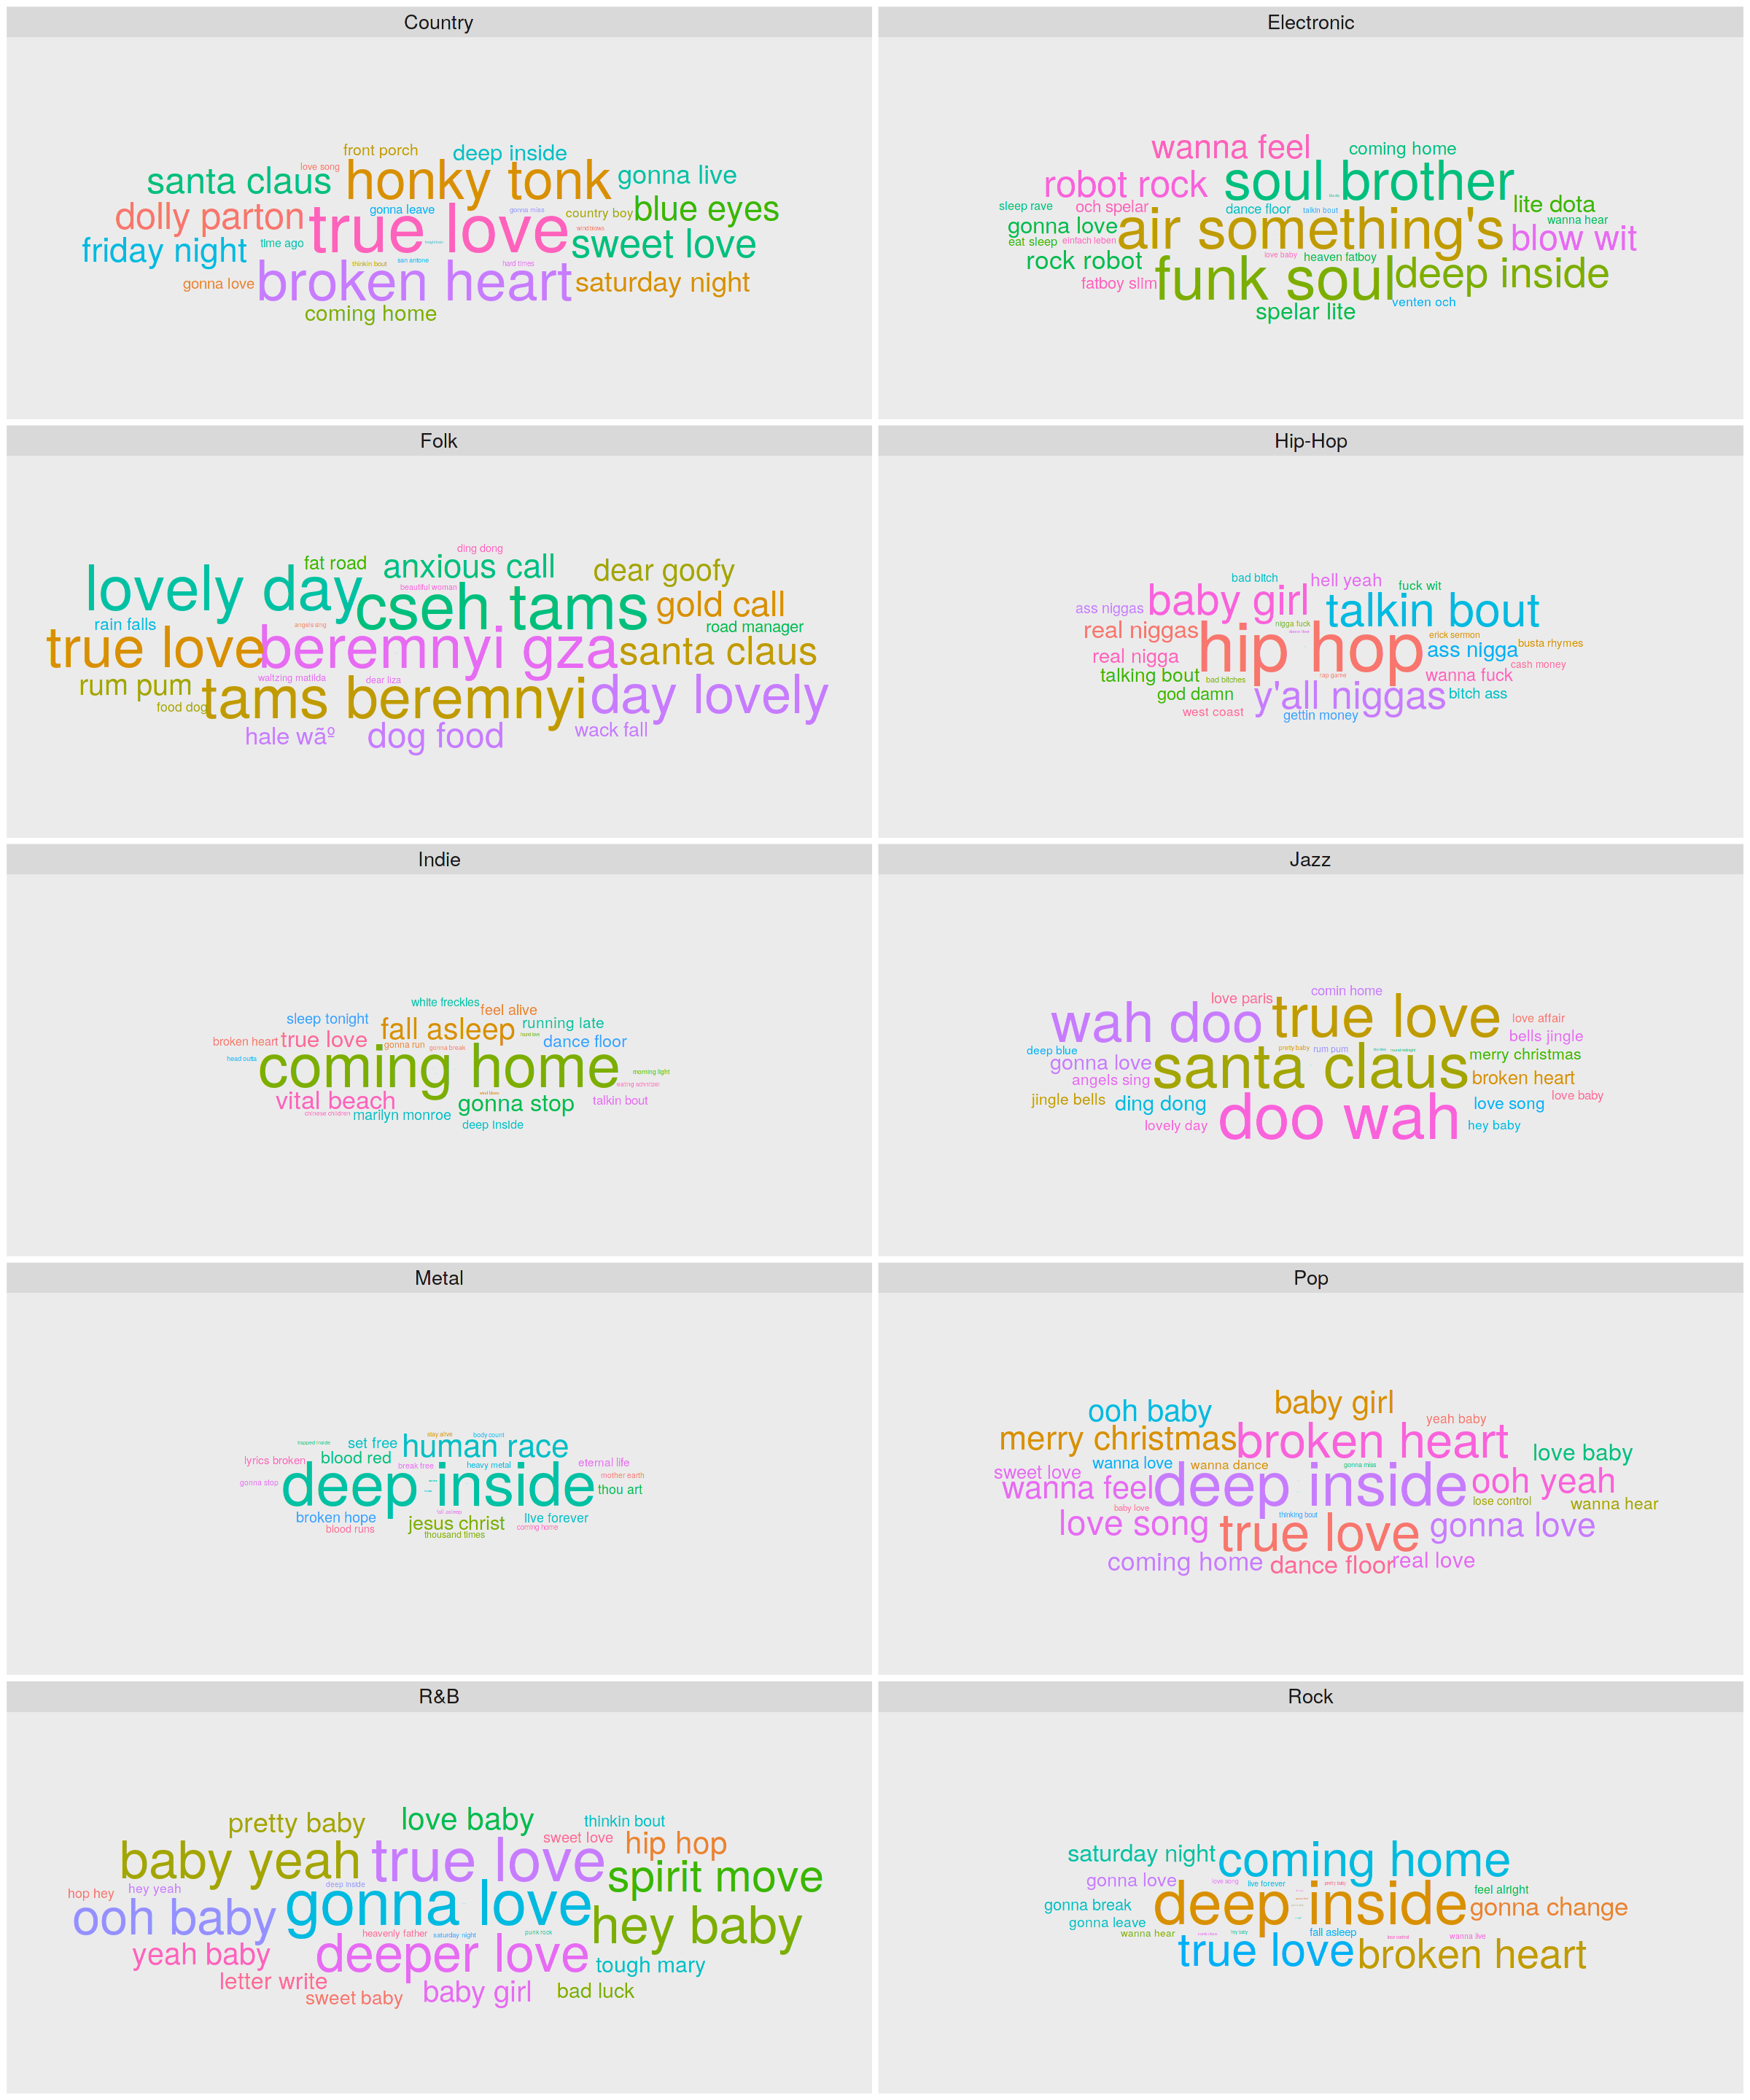

In [27]:
## ---- view_wordcloud_token_bigrams_per_genre----|

start  <- Sys.time()

temp <- group_by(gw, genre) %>%  
    arrange(desc(gw_p)) %>% 
    filter(row_number() < 26) %>%
    mutate(angle = 90 * sample(c(0, 1), n(), replace = TRUE, prob = c(100, 0)), 
           freq_sd = (gw_c - min(gw_c)) / (max(gw_c) - min(gw_c))) %>% 
    ungroup()

options(repr.plot.width = 20, repr.plot.height = 24)

plt <- ggplot(data = temp,
  aes(label = term, 
      size = freq_sd,
      color = factor(sample.int(20, nrow(temp), replace = TRUE)), 
      angle = angle)) +
  geom_text_wordcloud_area() +
  scale_size_area(max_size = 20) +
  facet_wrap(vars(genre), nrow = 5) +
  theme(text = element_text(size = 20))  

suppressWarnings(print(plt))

end = Sys.time()
mem = pryr::mem_used()

WriteLog('plot tokens lyrics bigrams per genre', start, end, mem)

## ---- end-of-view_wordcloud_token_bigrams_per_genre----|


Agora verificamos os top 5 bigramas por gênero musical.

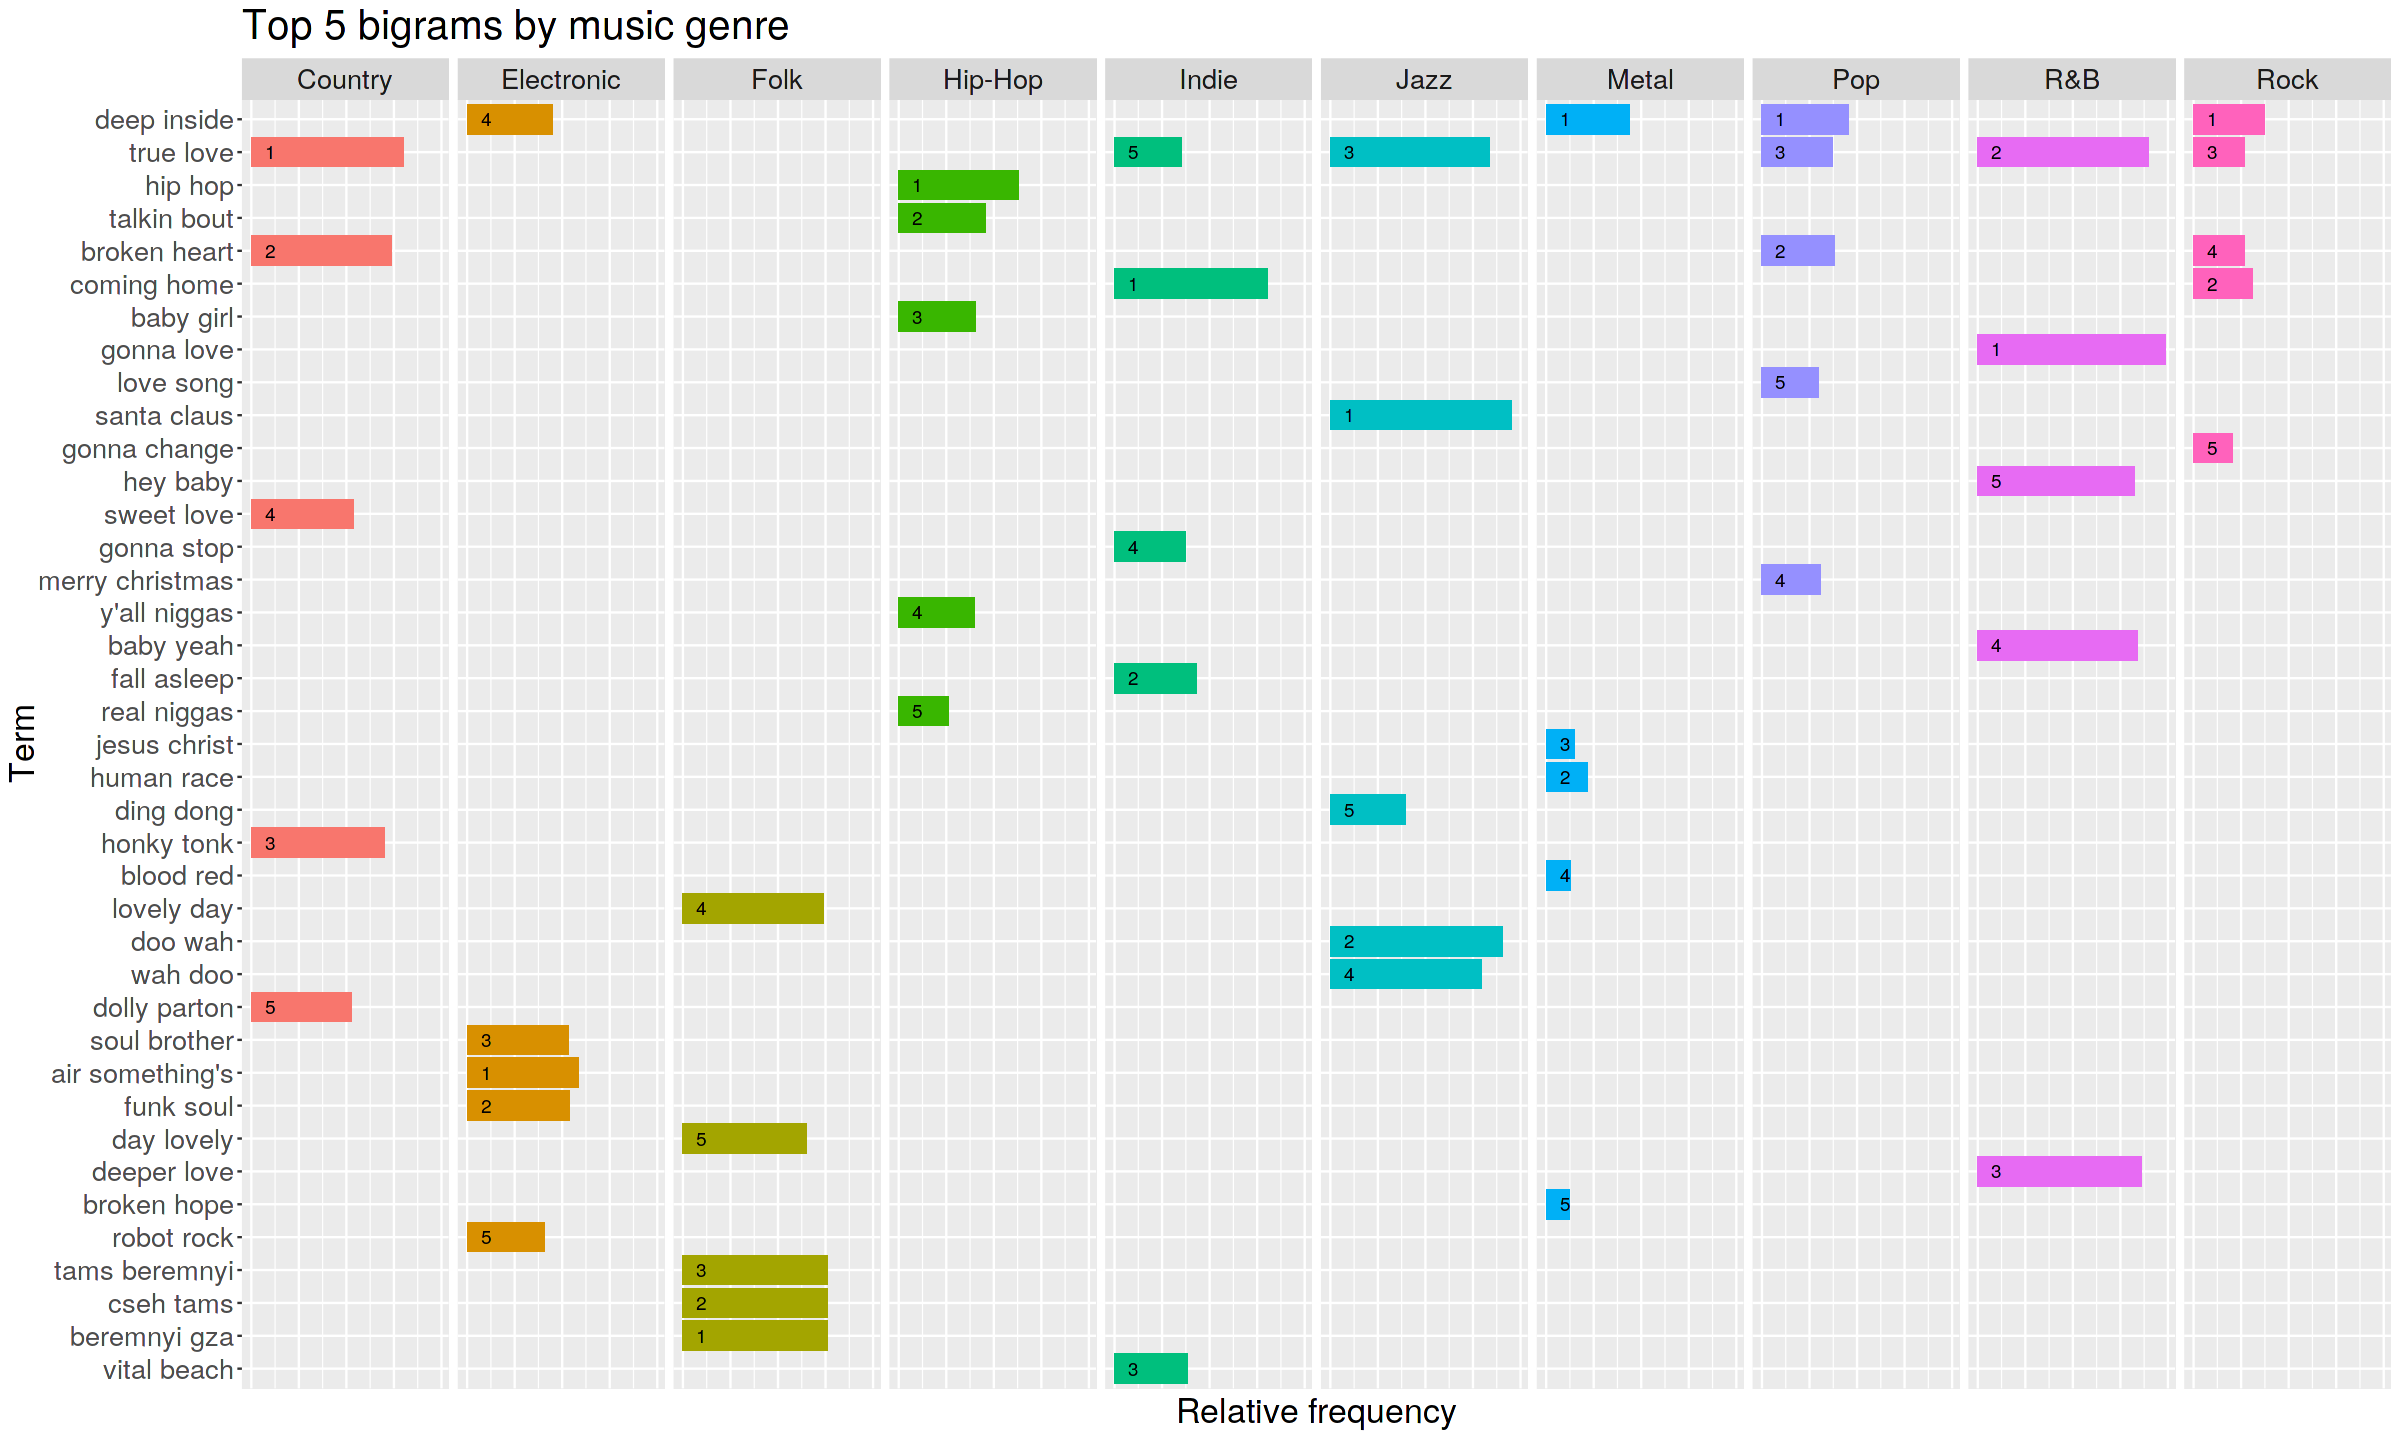

In [28]:
## ---- top_5_words_token_bigrams----|

start  <- Sys.time()

options(repr.plot.width = 20, repr.plot.height = 12)

gw %>%
  group_by(genre) %>% 
  arrange(desc(gw_p)) %>% 
  filter(row_number() <= 5) %>%
  mutate(rank = row_number()) %>% 
  ggplot() +
  geom_bar(stat = 'identity',
           aes(y = gw_p, x = fct_reorder(term, w_c), fill = genre)) +
  geom_text(aes(label = as.character(rank), x = fct_reorder(term, w_c), y = 0.0002)) +
  facet_wrap(vars(genre), nrow = 1) +
  coord_flip() +
  xlab('Term') +
  ylab('Relative frequency') +
  labs(title = 'Top 5 bigrams by music genre') +
  theme(legend.position = 0,
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        text = element_text(size = 20))

mem  <- pryr::mem_used()

rm(gw)
invisible(gc)

end = Sys.time()

WriteLog('plot top words bigrams', start, end, mem)

## ---- end-of-top_5_words_token_bigrams----|


# TF-IDF (Term Frequency - Inverse Document Frequency)

Esta métrica é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos.

O valor tf–idf de uma palavra aumenta proporcionalmente à medida que aumenta o número de ocorrências dela em um documento, no entanto, esse valor é equilibrado pela frequência da palavra no corpus. Isso auxilia a distinguir o fato de a ocorrência de algumas palavras serem geralmente mais comuns que outras como as stopwords.

\begin{equation}
W_{i,j} = tf_{i,j} * log(\frac{N}{df_i})
\end{equation}

\begin{equation}
tf_{i,j} = \text{ número de ocorrencias do termo } \textit{( i )} \text{ em } \textit{ j } \text{ (documento)}
\end{equation} 

\begin{equation}
df_{i} = \text{ número de documentos contendo } \textit {i}
\end{equation} 

\begin{equation}
N = \text{ número total de documentos }
\end{equation} 

\begin{equation}
W_{i,j} = \text{ Term Frequency - Inverse Document Frequency }
\end{equation} 

Neste exercício o documento será um gênero musical.

Vamos verificar se conseguimos identificar as principais palavras de cada gênero musical sem o auxílio de um dicionário de stopwords.

Começamos calculando a frequência de cada termo.

In [29]:
## ---- calculate_term_frequency----|

start  <- Sys.time()

lyrics <- readRDS('lyrics.rds')

# tokennize dataset but do not treat for stopwords.
lyrics_token <- unnest_tokens(lyrics,
                              input = lyrics,
                              output = word,
                              token = 'words',
                              drop = TRUE,
                              to_lower = TRUE)

# calculate the term frequency by gere.
lyrics_token <- lyrics_token[, c('genre','word')] %>% 
    filter(str_detect(word, "^[a-z']")) %>% 
    group_by(genre, word) %>% 
    summarise(n = n()) %>% 
    group_by(genre) %>% 
    mutate(total = sum(n)) %>% 
    mutate(tf = n / total) %>% 
    group_by(genre) %>% 
    arrange(desc(n)) %>%
    mutate(rank_tf = row_number()) %>%
    ungroup()

# display the most commom terms based on its term frequency.
    filter(lyrics_token, rank_tf <= 3) %>% 
    arrange(genre, rank_tf)

mem  <- pryr::mem_used()

rm(lyrics)
invisible(gc)

end = Sys.time()
mem = pryr::mem_used()

WriteLog('calculate tf', start, end, mem)

## ---- end-of-calculate_term_frequency----|


genre      word n      total    tf         rank_tf
1  Country    the  103973  2679487 0.03880332 1      
2  Country    i     91742  2679487 0.03423864 2      
3  Country    you   75767  2679487 0.02827668 3      
4  Electronic the   54825  1544886 0.03548806 1      
5  Electronic you   53800  1544886 0.03482458 2      
6  Electronic i     49534  1544886 0.03206321 3      
7  Folk       the   18199   407209 0.04469204 1      
8  Folk       and   10935   407209 0.02685353 2      
9  Folk       i     10469   407209 0.02570916 3      
10 Hip-Hop    the  450760 12208026 0.03692325 1      
11 Hip-Hop    i    357582 12208026 0.02929073 2      
12 Hip-Hop    you  311165 12208026 0.02548856 3      
13 Indie      the   24750   621608 0.03981609 1      
14 Indie      i     21678   621608 0.03487407 2      
15 Indie      you   20160   621608 0.03243202 3      
16 Jazz       the   46727  1379648 0.03386878 1      
17 Jazz       you   44560  1379648 0.03229809 2      
18 Jazz       i     43283  1379648 0.03137250 3      
19 Metal      the  210836  4008857 0.05259255 1      
20 Metal      i     95301  4008857 0.02377261 2      
21 Metal      to    93061  4008857 0.02321385 3      
22 Pop        you  371530  9979152 0.03723062 1      
23 Pop        i    338614  9979152 0.03393214 2      
24 Pop        the  289530  9979152 0.02901349 3      
25 R&B        you   33255   767659 0.04332002 1      
26 R&B        i     29320   767659 0.03819404 2      
27 R&B        the   23534   767659 0.03065684 3      
28 Rock       the  810185 20856567 0.03884556 1      
29 Rock       i    661465 20856567 0.03171495 2      
30 Rock       you  660341 20856567 0.03166106 3

Podemos perceber que são exatamente as stop words os termos com maior frequência.

Podemos visualizar a quantidade de termos por frequência em um histograma.

Verificamos que a maioria dos termos tem uma frequência muito baixa, como é esperado.

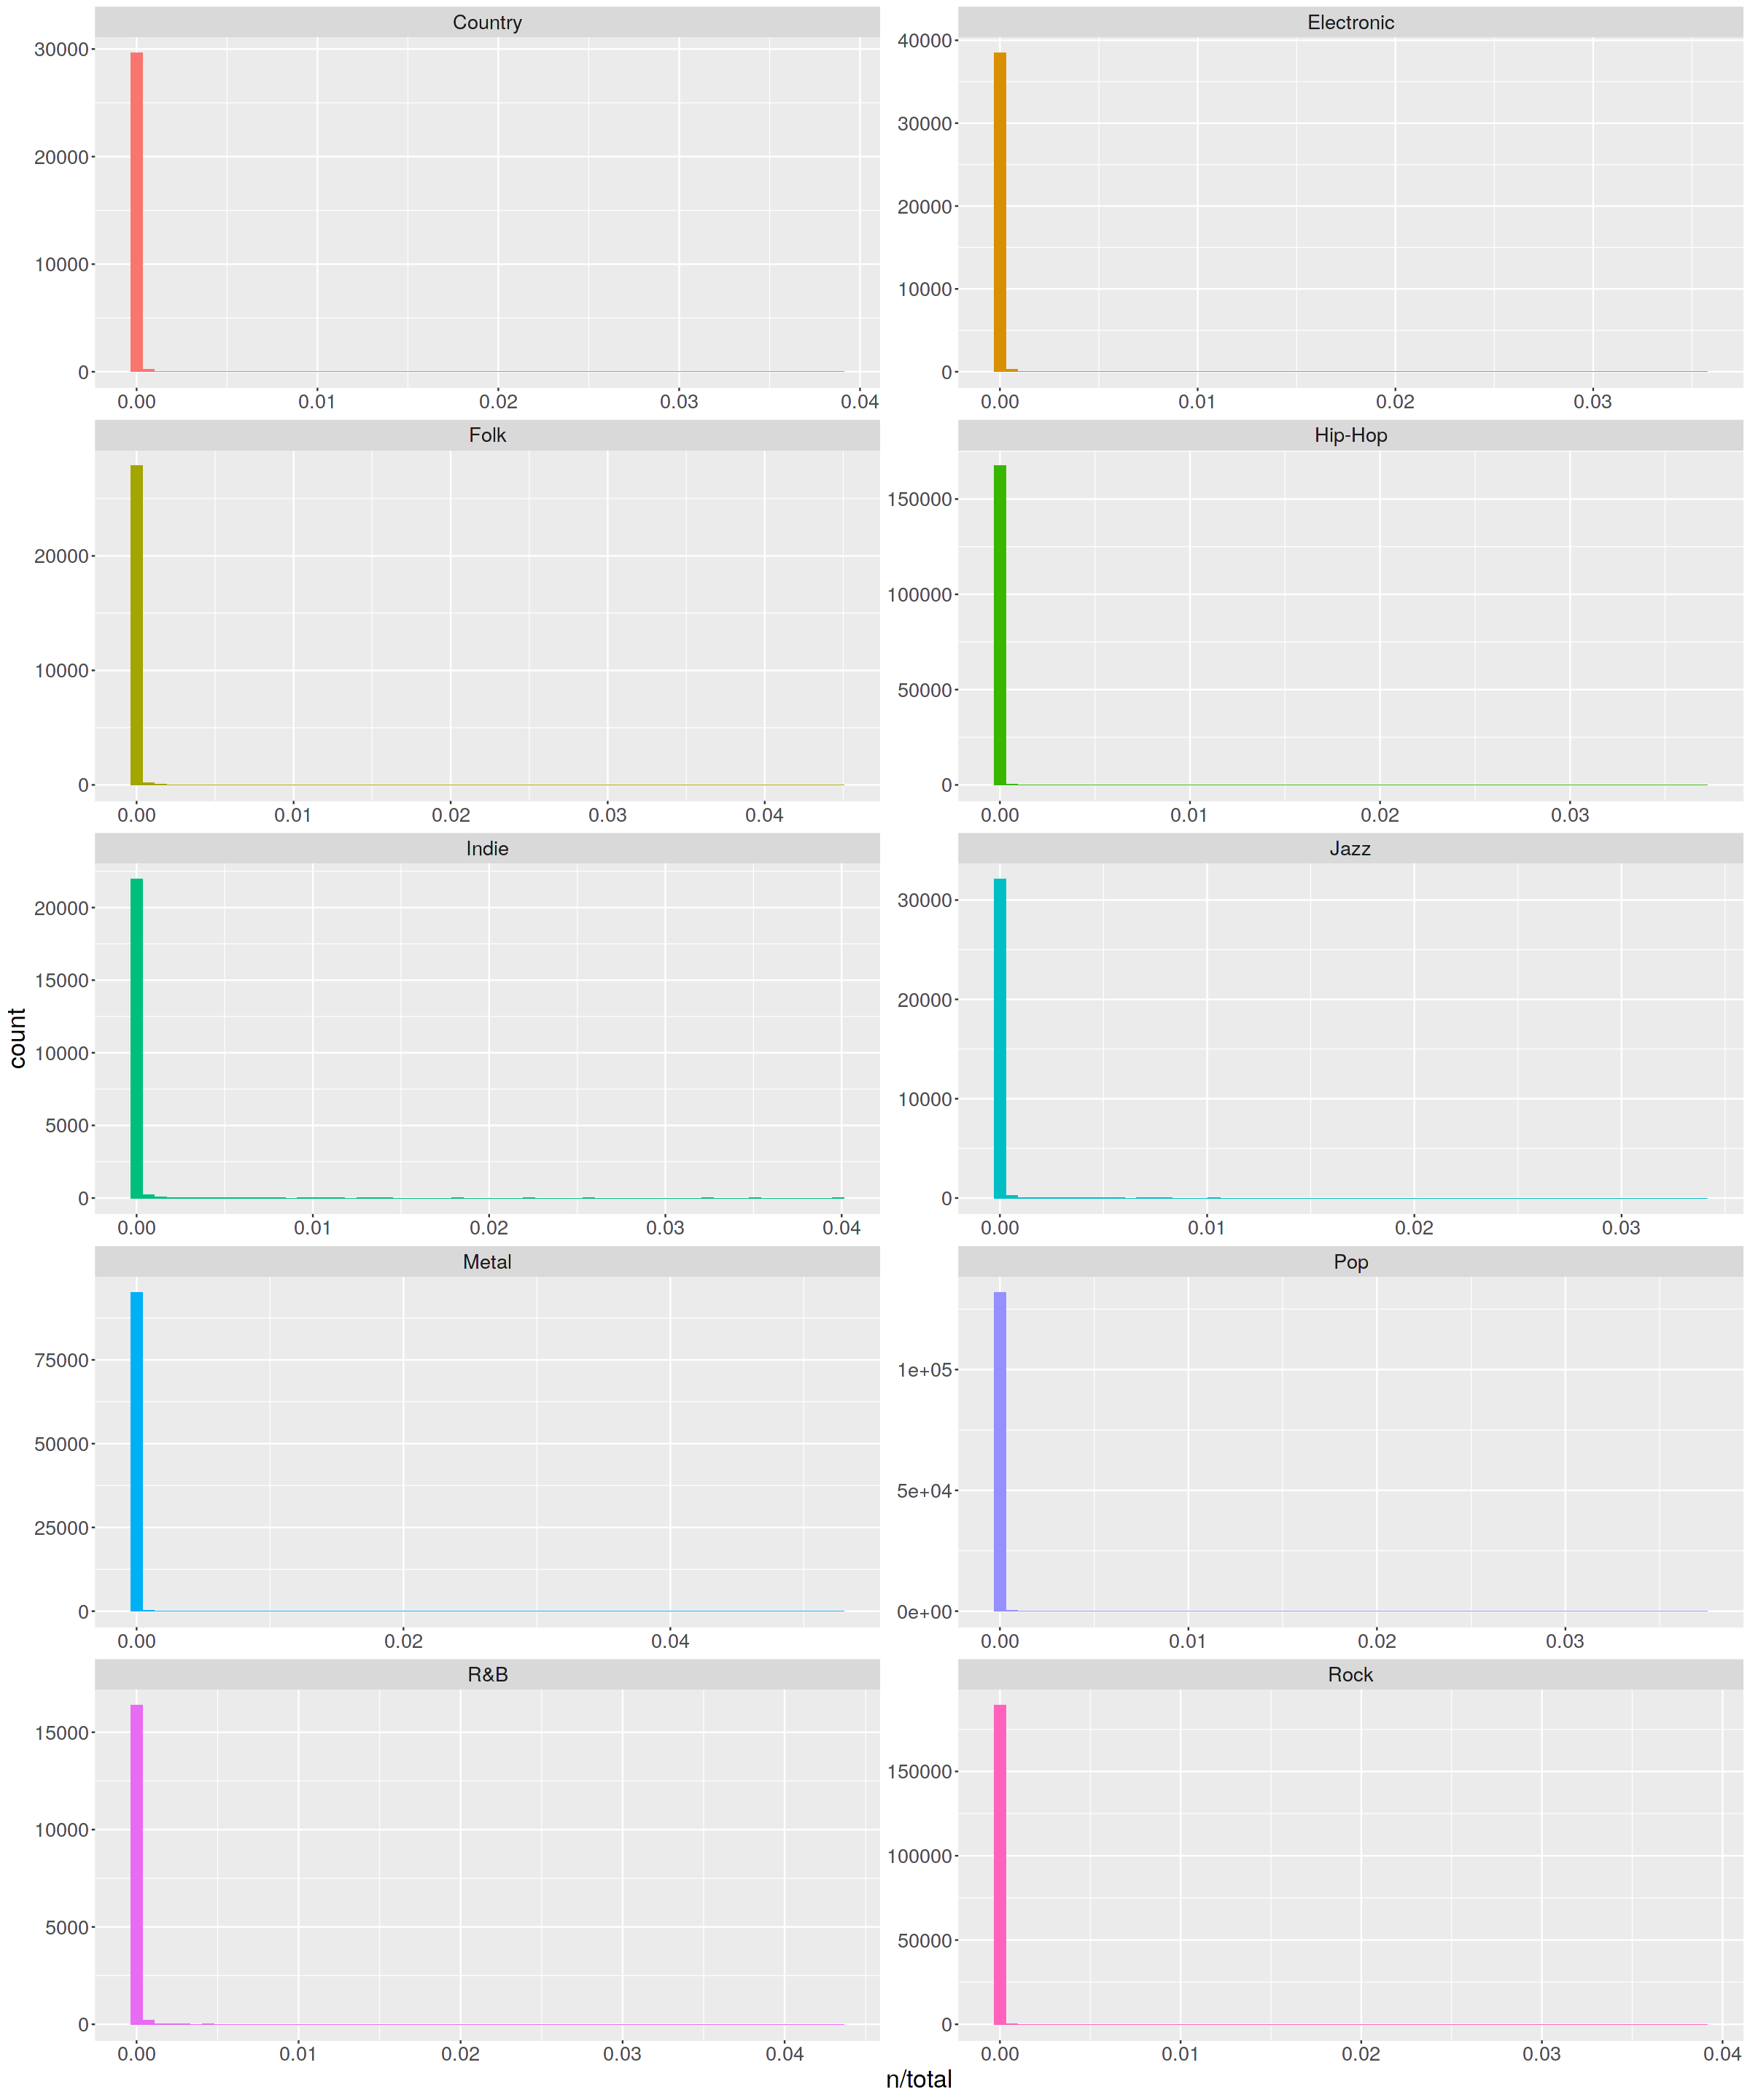

In [30]:
## ---- histogram_term_frequency----|

start  <- Sys.time()

options(repr.plot.width = 20, repr.plot.height = 24)

ggplot(lyrics_token, aes(x = n / total, fill = genre)) +
  geom_histogram(show.legend = FALSE, bins = 60) + 
  facet_wrap( ~ genre, ncol = 2, scales = 'free') +
  theme(text = element_text(size = 20))

end <- Sys.time()

WriteLog('plot histogram of tf', start, end, pryr::mem_used())

## ---- end-of-histogram_term_frequency----|


Aqui verificamos a relação entre a frequência do termo, no gênero com, o rank do termo.

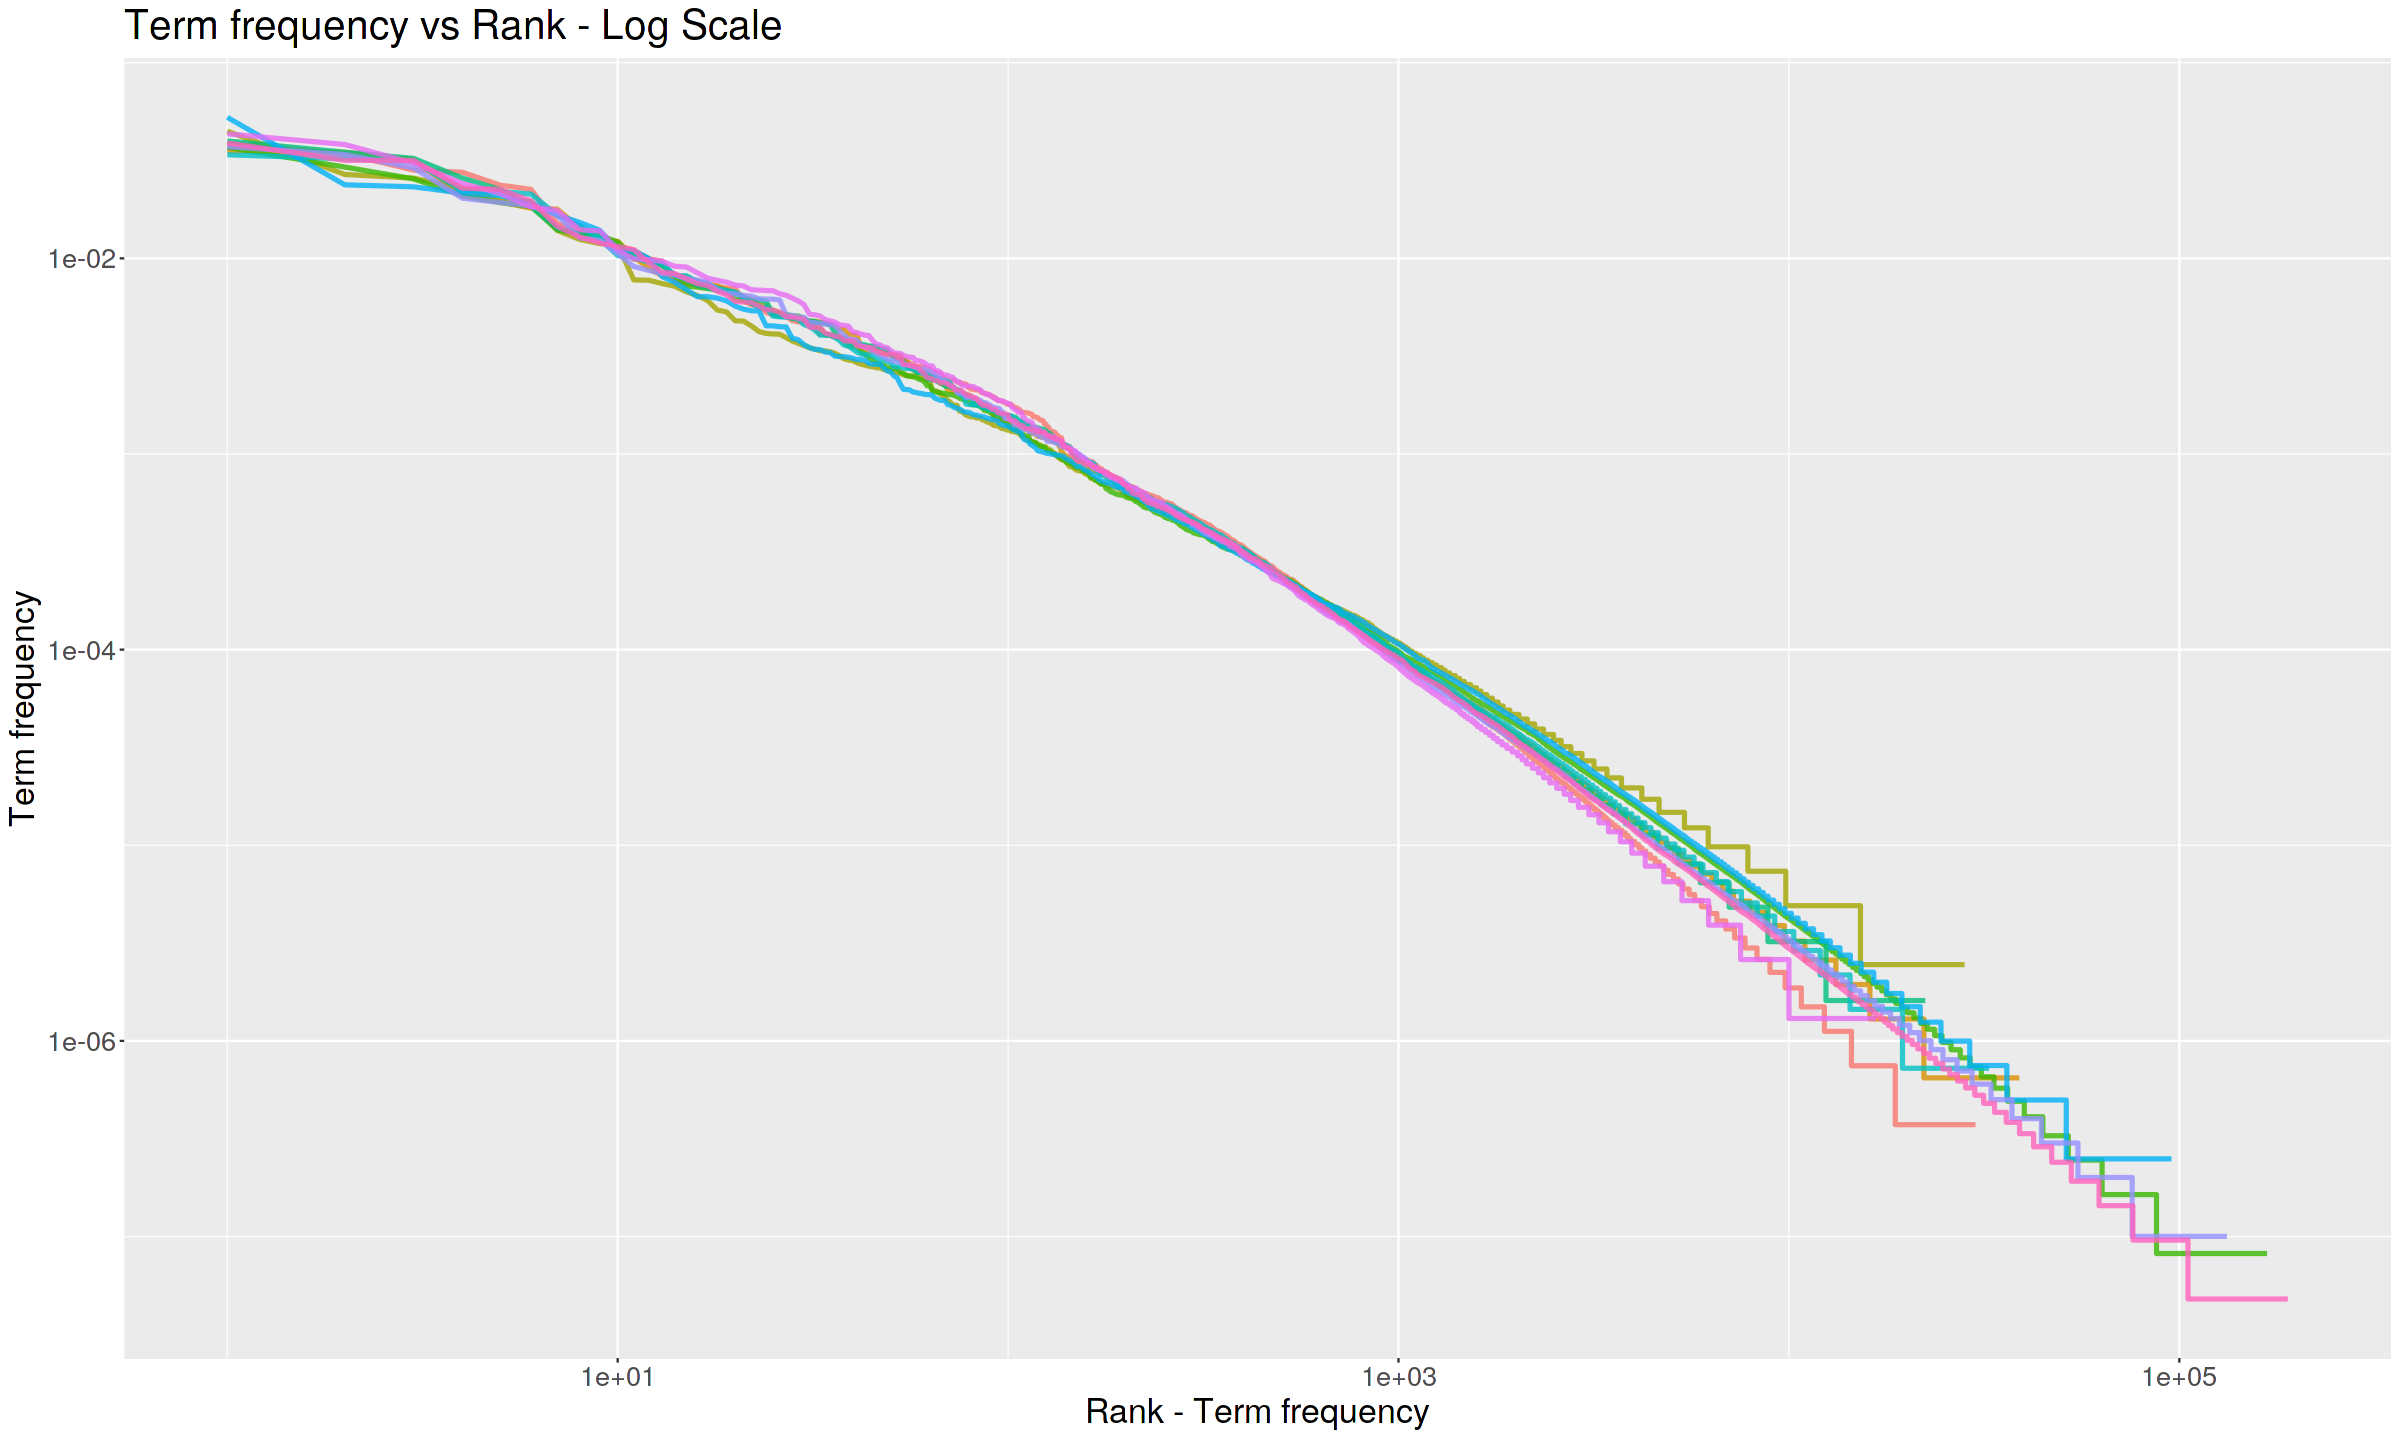

In [31]:
## ---- term_frequency_vs_rank----|

start  <- Sys.time()

options(repr.plot.width = 20, repr.plot.height = 12)

ggplot(lyrics_token, aes(x = rank_tf, y = tf, color = genre)) +
  geom_line(alpha = 0.8, size = 1.1, show.legend = FALSE) +
  scale_x_log10() + scale_y_log10() +
  xlab("Rank - Term frequency") + ylab("Term frequency") + 
  labs(title = 'Term frequency vs Rank - Log Scale') +
  theme(text = element_text(size = 20))

end  <- Sys.time()

WriteLog('plot term frequency vs rank', start, end, pryr::mem_used())

## ---- end-of-term_frequency_vs_rank----|


O fato de haver algumas canções em outros idiomas, que não o inglês, faz com que a técnica TF-IDF não seja bem-sucedida em eliminar as stopwords.

Em geral as stop words estão presentes em todos os documentos, fazendo com que o termo $ log(\frac{N}{df_i}) $ tenha o resultado zero, zerando assim a estatística TF-IDF para o termo.

Como existem vários idiomas no dataset esta tendência não se observa fazendo com que não ocorra a eliminação das stop words.

In [32]:
## ---- calculate_idf----|

start  <- Sys.time()

lyrics_token <- bind_tf_idf(tbl = lyrics_token,  
                            term = word, 
                            document = genre, 
                            n = n) %>% 
                arrange(desc(tf_idf)) %>% 
                group_by(genre) %>% 
                mutate(rank_tf_idf  = row_number()) %>% 
                arrange(genre, rank_tf_idf) %>% 
                ungroup()

filter(lyrics_token, rank_tf_idf  <= 3)

end = Sys.time()
mem = pryr::mem_used()

WriteLog('calculate idf', start, end, mem)

## ---- end-of-calculate_idf----|


genre      word           n     total    tf           rank_tf idf      
1  Country    cledus           105  2679487 3.918661e-05 1788    2.3025851
2  Country    parton           215  2679487 8.023924e-05 1111    0.6931472
3  Country    ac.guitar        110  2679487 4.105263e-05 1720    1.2039728
4  Electronic dibby            388  1544886 2.511512e-04  477    1.2039728
5  Electronic wub              154  1544886 9.968373e-05  931    2.3025851
6  Electronic apos             419  1544886 2.712174e-04  453    0.6931472
7  Folk       beremnyi          78   407209 1.915478e-04  592    2.3025851
8  Folk       cseh              78   407209 1.915478e-04  593    2.3025851
9  Folk       agus             146   407209 3.585382e-04  340    1.2039728
10 Hip-Hop    niggas         30288 12208026 2.480991e-03   57    0.2231436
11 Hip-Hop    nigga          42853 12208026 3.510232e-03   41    0.1053605
12 Hip-Hop    chamillionaire   690 12208026 5.652019e-05 1548    1.6094379
13 Indie      johnstone         67   621608 1.077850e-04  897    2.3025851
14 Indie      mooday            41   621608 6.595797e-05 1263    2.3025851
15 Indie      leggie            38   621608 6.113177e-05 1329    2.3025851
16 Jazz       ik               596  1379648 4.319942e-04  315    0.3566749
17 Jazz       pango             67  1379648 4.856311e-05 1645    2.3025851
18 Jazz       niet             204  1379648 1.478638e-04  722    0.6931472
19 Metal      iagh              83  4008857 2.070416e-05 3477    2.3025851
20 Metal      ov               271  4008857 6.760032e-05 1423    0.6931472
21 Metal      ak'n              80  4008857 1.995581e-05 3544    2.3025851
22 Pop        né               809  9979152 8.106901e-05 1050    2.3025851
23 Pop        mé              1126  9979152 1.128352e-04  840    1.6094379
24 Pop        sé              1429  9979152 1.431985e-04  705    1.2039728
25 R&B        babyface         174   767659 2.266631e-04  488    0.9162907
26 R&B        sookie            50   767659 6.513309e-05 1169    1.2039728
27 R&B        boogum            24   767659 3.126388e-05 1900    2.3025851
28 Rock       kimi            1318 20856567 6.319353e-05 1305    0.6931472
29 Rock       boku             644 20856567 3.087756e-05 2155    0.6931472
30 Rock       tiss             276 20856567 1.323324e-05 3793    1.6094379
   tf_idf       rank_tf_idf
1  9.023049e-05 1          
2  5.561760e-05 2          
3  4.942626e-05 3          
4  3.023792e-04 1          
5  2.295303e-04 2          
6  1.879936e-04 3          
7  4.410552e-04 1          
8  4.410552e-04 2          
9  4.316703e-04 3          
10 5.536171e-04 1          
11 3.698398e-04 2          
12 9.096574e-05 3          
13 2.481841e-04 1          
14 1.518738e-04 2          
15 1.407611e-04 3          
16 1.540815e-04 1          
17 1.118207e-04 2          
18 1.024914e-04 3          
19 4.767308e-05 1          
20 4.685697e-05 2          
21 4.594996e-05 3          
22 1.866683e-04 1          
23 1.816013e-04 2          
24 1.724071e-04 3          
25 2.076893e-04 1          
26 7.841846e-05 2          
27 7.198775e-05 3          
28 4.380241e-05 1          
29 2.140270e-05 2          
30 2.129808e-05 3

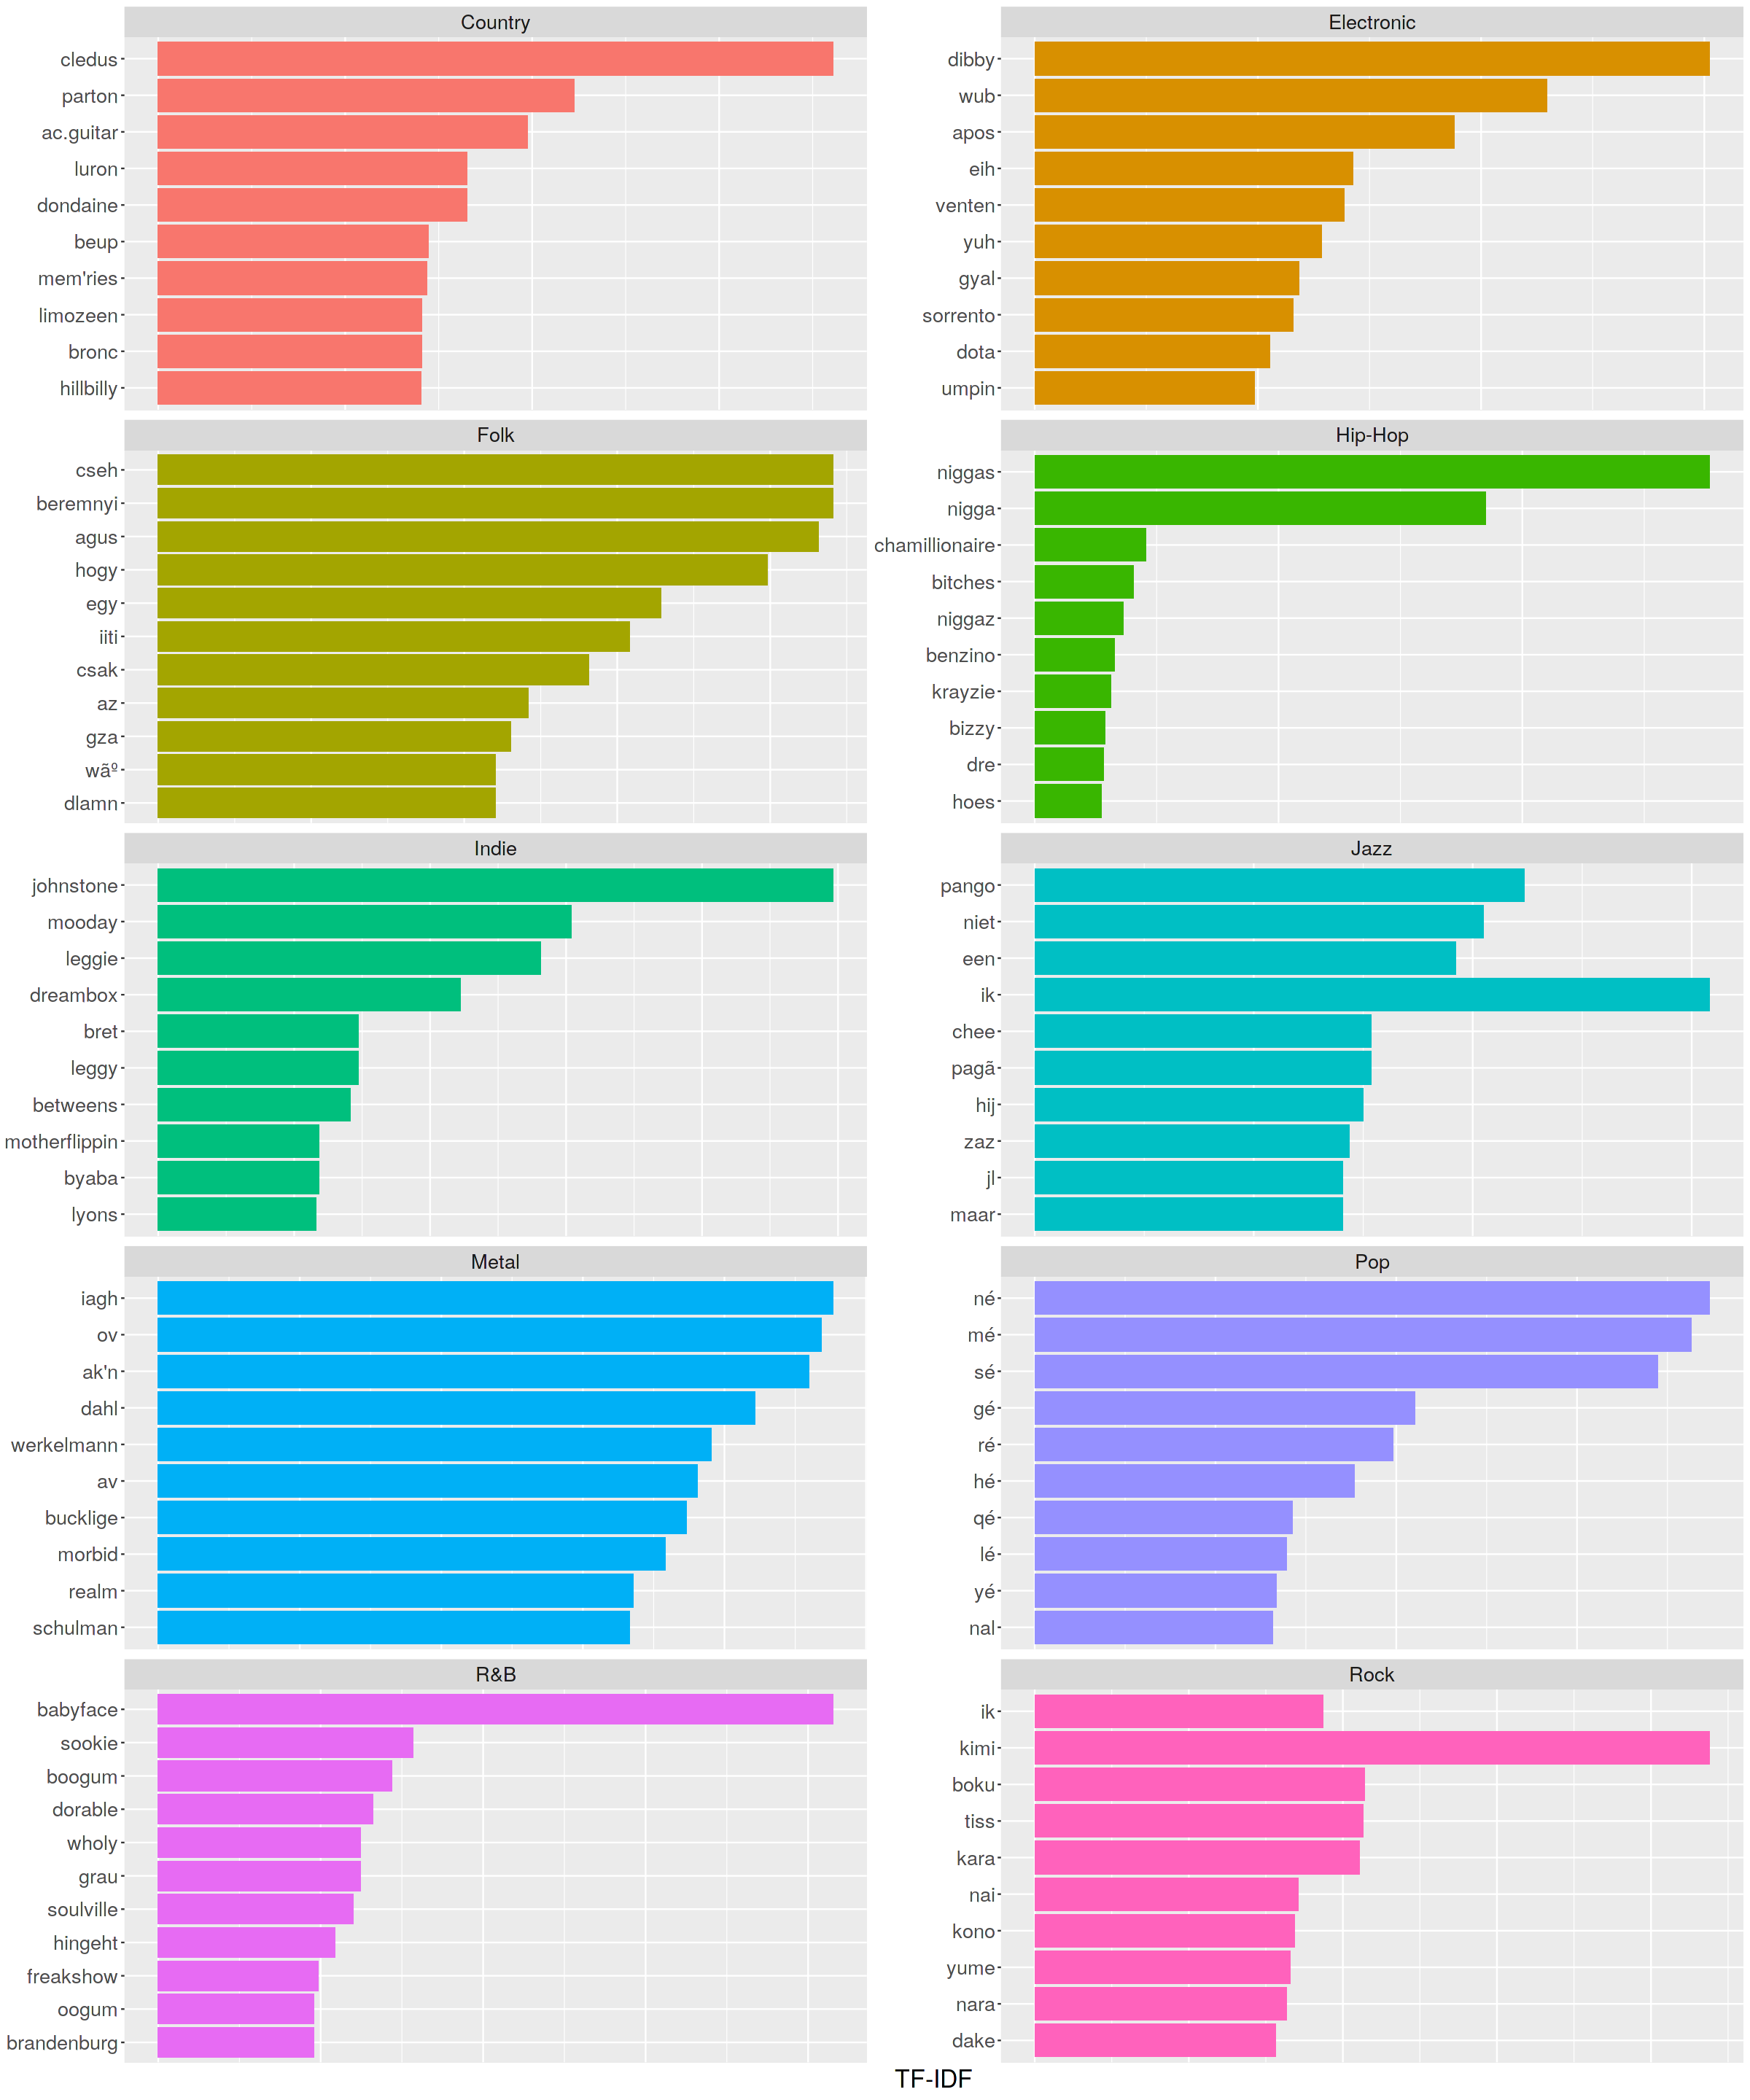

In [33]:
## ---- top_words_per_genre_tdidf----|

start  <- Sys.time()

options(repr.plot.width = 20, repr.plot.height = 24)

    group_by(lyrics_token, genre) %>%
    top_n(10, tf_idf) %>%
    ungroup() %>% 
    mutate(word = reorder(word, desc(tf_idf))) %>% 
    ggplot(aes(x = fct_reorder(word, tf_idf), 
               y = tf_idf, 
               fill = genre)) +
        geom_col(show.legend = FALSE) +
        facet_wrap( ~ genre, ncol = 2, scales = "free") +
        coord_flip() +
        labs(x = NULL, y = "TF-IDF") +
        theme(text = element_text(size = 20), 
              axis.ticks.x = element_blank(),
              axis.text.x = element_blank())

end  <- Sys.time()

WriteLog('print tf idf', start, end, pryr::mem_used())

## ---- end-of-calculate_idf----|


In [34]:
rm(lyrics_token)
invisible(gc)


# LDA Topic Modelling

Agora vamos tentar utilizar a técnica de topic modeling **Latent Dirichlet Allocation (LDA)** para responder a questão.

> **Seria possível classificar as canções em grupos que representam os seus respectivos gêneros musicais apenas analisando as letras das músicas?**

O dataset que iremos utilizar é o mesmo onde já eliminamos as stop words no início de nosso exercício.

Para contornar limitações computacionais vamos limitar o data set as palavras que aparecem em pelo menos mais de **2 músicas**.

In [35]:
## ---- filter_tokens_LDA----|

start  <- Sys.time()

lyrics_token <- readRDS('lyrics_token.rds')
distinct_words <- distinct(lyrics_token, index, word)

song_count <- length(unique(distinct_words$index))

reject_words <- count(distinct_words, word, sort = TRUE) %>% 
                    mutate(prop = n / song_count * 100) %>% 
                    arrange(desc(prop)) %>% 
                    filter(n <= 2)

reject_words <- reject_words$word

print(paste('Número de termos que aparecem em apenas uma música: ', 
            length(reject_words)))

lyrics_token <- filter(lyrics_token, !(word %in% reject_words))

print(paste('Número de tokens: ', 
            nrow(lyrics_token)))

print(paste('Número de termos restante: ', 
            length(unique(lyrics_token$word))))

mem  <- pryr::mem_used()

rm(reject_words, distinct_words, song_count)
invisible(gc)

end = Sys.time()

WriteLog('filter tokens LDA', start, end, mem)

## ---- end-of-filter_tokens_LDA----|


[1] "Número de termos que aparecem em apenas uma música:  275699"
[1] "Número de tokens:  17977140"
[1] "Número de termos restante:  120625"


Mesmo limitando o dataset a palavras que aparecem em mais de duas músicas, necessitaremos limitar o dataset a uma amostra de 50.000 músicas distintas, visto que o tempo de processamento é superior ao permitido para este ambiente.

In [36]:
## ---- sampling_tokens_LDA----|

start  <- Sys.time()

print(paste('Número total de músicas: ', length(unique(lyrics_token$index))))

songs_sample  <- sample(unique(lyrics_token$index), 50000, replace = FALSE)

print(paste('Número de músicas selecionadas para o LDA: ', length(songs_sample)))

lyrics_token <- filter(lyrics_token, index %in% songs_sample)

mem  <- pryr::mem_used()
rm(songs_sample)

end = Sys.time()

WriteLog('sampling tokens LDA', start, end, mem)

## ---- end-of-sampling_tokens_LDA----|


[1] "Número total de músicas:  233353"
[1] "Número de músicas selecionadas para o LDA:  50000"


Transformamos o nosso dataset em uma matriz de frequência de documentos vs termos **(Documento Term Matrix)**.


In [37]:
## ---- create_dtm----|

start  <- Sys.time()

dtm <- cast_dtm(data = count(lyrics_token, index, word, sort = TRUE),
                weighting = tm::weightTf,
                document = index, 
                term = word, 
                value = n)

dtm

saveRDS(dtm, 'dtm.rds')

mem  <- pryr::mem_used()

end = Sys.time()

WriteLog('calculate dtm', start, end, mem)

## ---- end-of-create_dtm----|


<<DocumentTermMatrix (documents: 50000, terms: 95738)>>
Non-/sparse entries: 2364777/4784535223
Sparsity           : 100%
Maximal term length: 29
Weighting          : term frequency (tf)

Agora treinamos um modelo com **10 tópicos** para verificarmos se eles de alguma forma representam os gêneros musicais presentes no dataset.

In [38]:
## ---- LDA_10_topics----|

start  <- Sys.time()

tpm <- LDA(dtm, k = 10, control = list(seed = 123456))

tpm
summary(tpm)

saveRDS(tpm, 'tpm_10.rds')

mem  <- pryr::mem_used()
invisible(gc)

end = Sys.time()

WriteLog('calculate tpm 10', start, end, mem)

## ---- end-of-LDA_10_topics----|


A LDA_VEM topic model with 10 topics.

 Length   Class    Mode 
      1 LDA_VEM      S4 

Agora verificamos quais são os termos com maior **( $ \beta $ )** que representa a probabilidade do termo pertencer ao tópico.

Podemos verificar que alguns tópicos se parecem bastante com as palavras mais comuns de alguns gêneros musicais que observamos na fase de análise exploratória de dados.

Destaque para o gênero **Hip-Hop** onde claramente conseguimos verificar os mesmos termos no tópico gerado pelo modelo.

Alguns tópicos porém não fazem o menor sentido, claramente aqui temos o efeito de termos algumas músicas em outros idiomas, um tópico quase que classifica as canções em espanhol em um mesmo cluster.

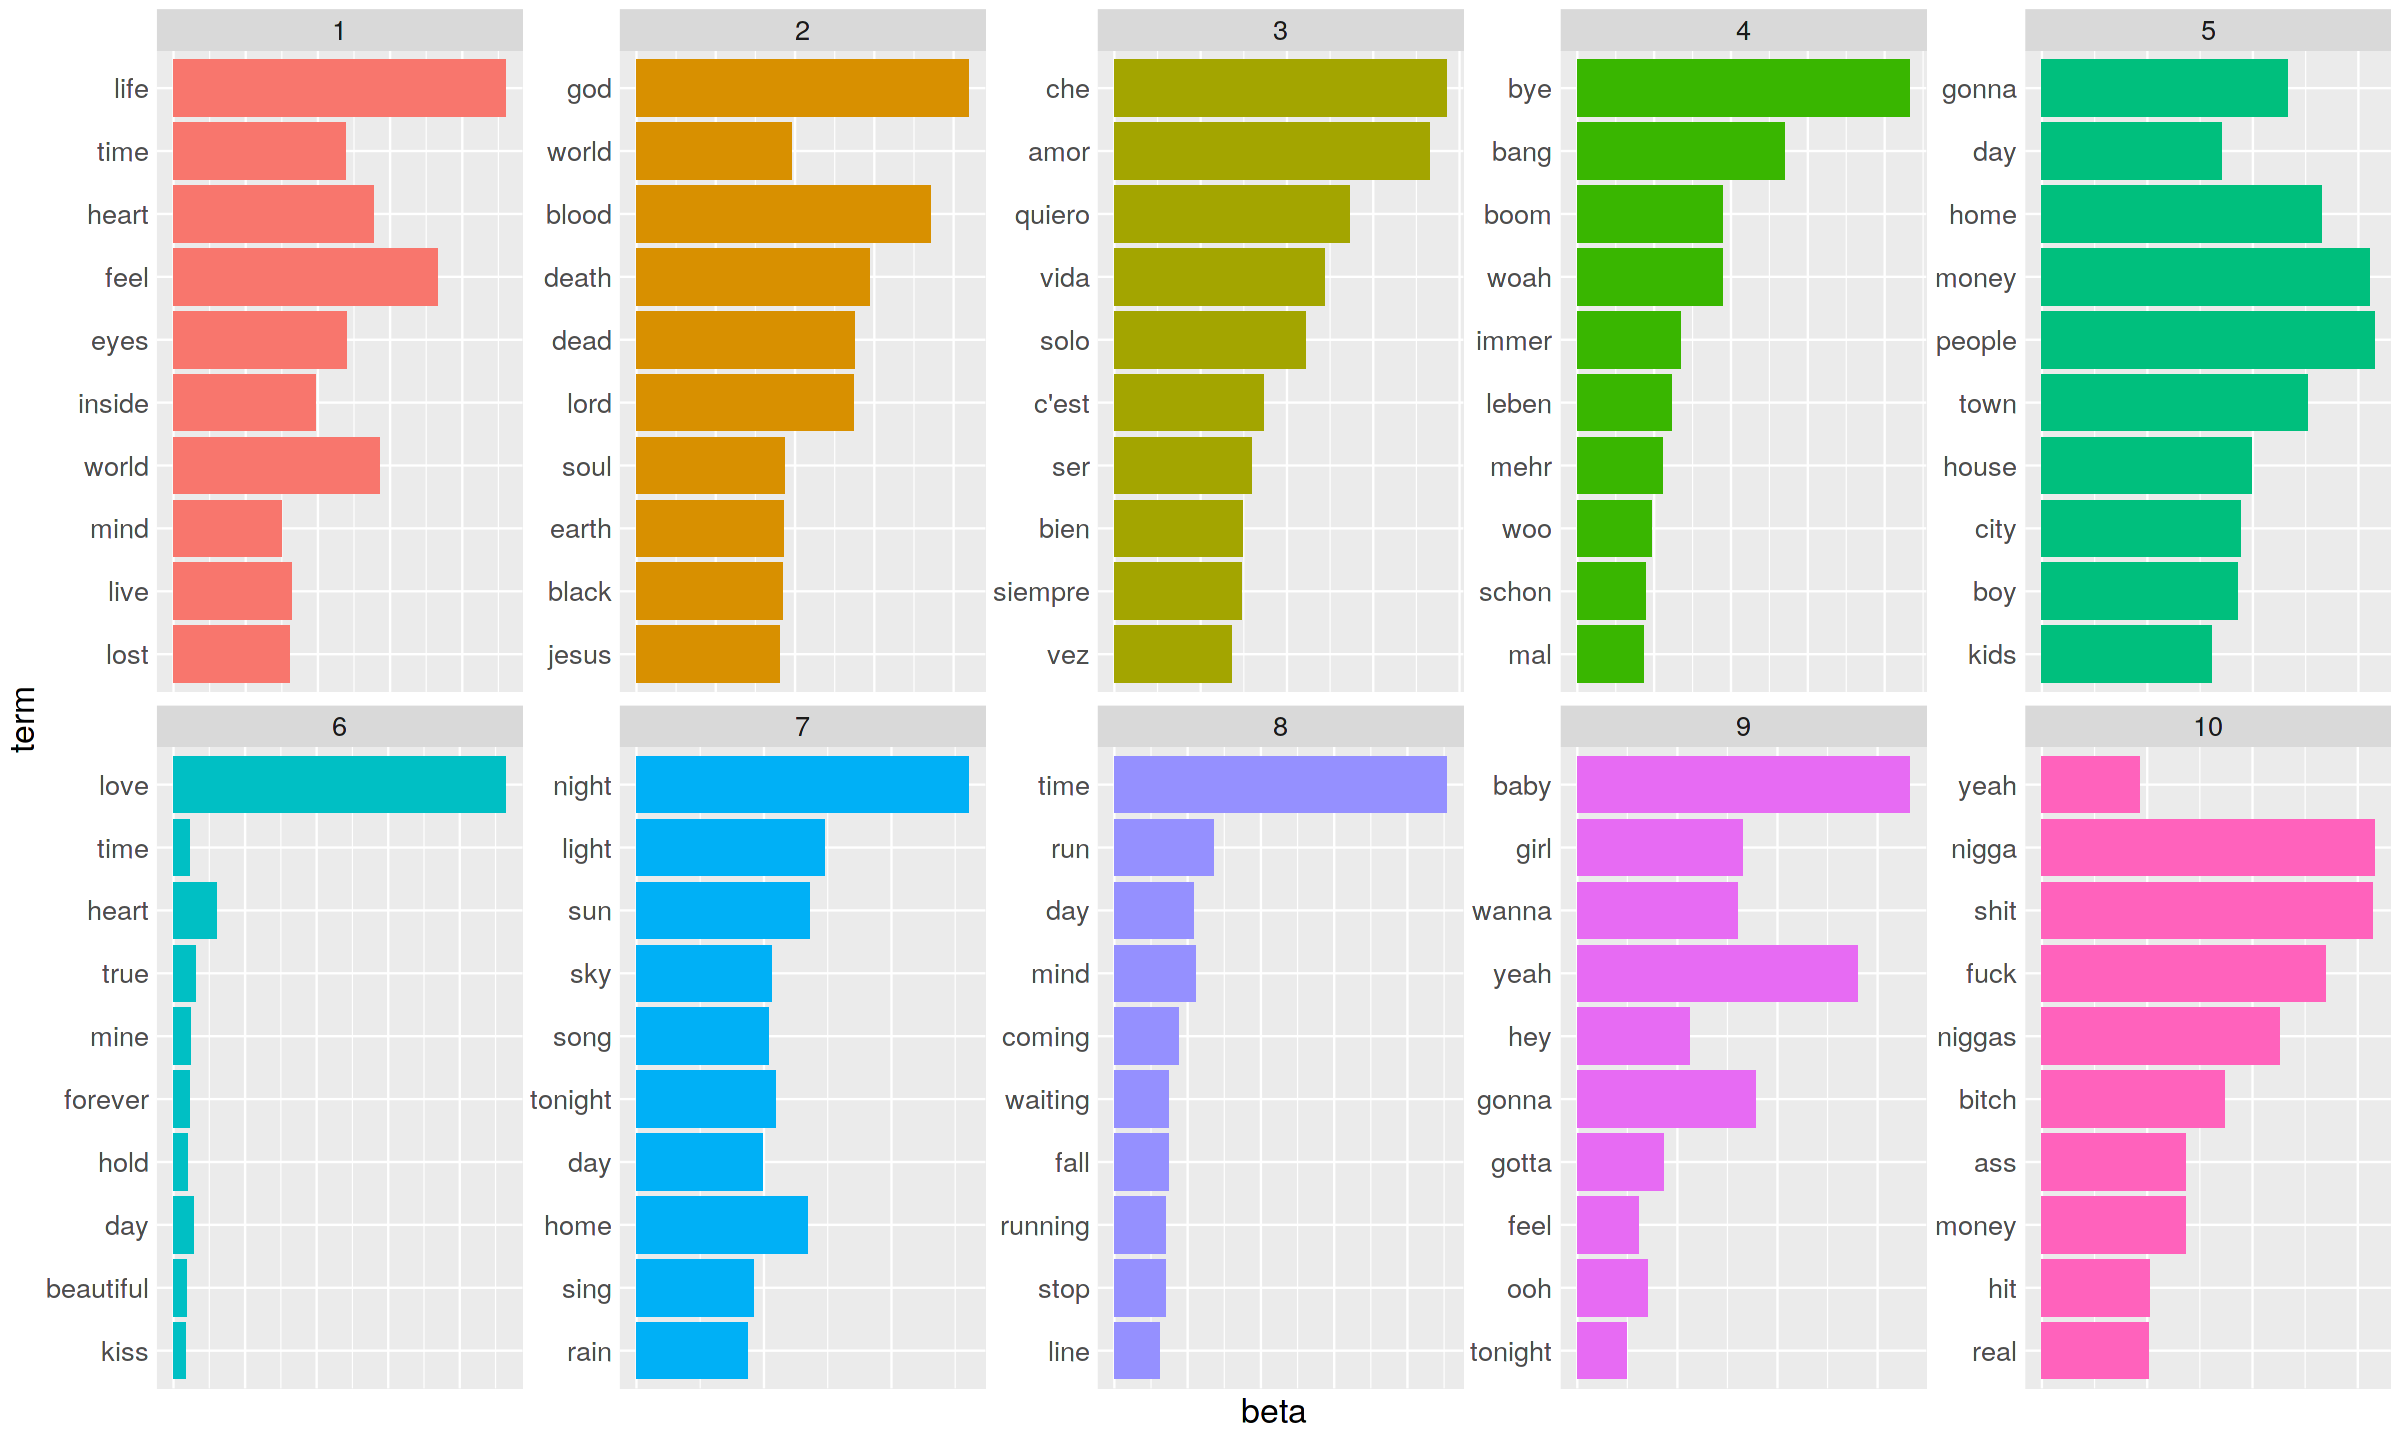

In [39]:
## ---- top_words_per_topic_LDA_10----|

start  <- Sys.time()

options(repr.plot.width = 20, repr.plot.height = 12)

term_topics <- tidy(tpm, matrix = "beta")

term_top_terms <- term_topics %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

term_top_terms %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free", nrow = 2) +
  coord_flip() +
  theme(text = element_text(size = 20), 
        axis.text.x = element_blank(), 
        axis.ticks = element_blank())

mem  <- pryr::mem_used()

rm(term_topics)
invisible(gc)

end <- Sys.time()

WriteLog('plot top words lda 10', start, end, mem)

## ---- end-of-top_words_per_topic_LDA_10----|


Podemos fazer a junção com o dataset de canções originais e verificar, por gênero musical, para qual tópico cada canção foi assignada pelo modelo LDA.

A probabilidade de cada canção pertencer a um determinado tópico é dada pela estatística **( $ \gamma $ )** do modelo LDA.


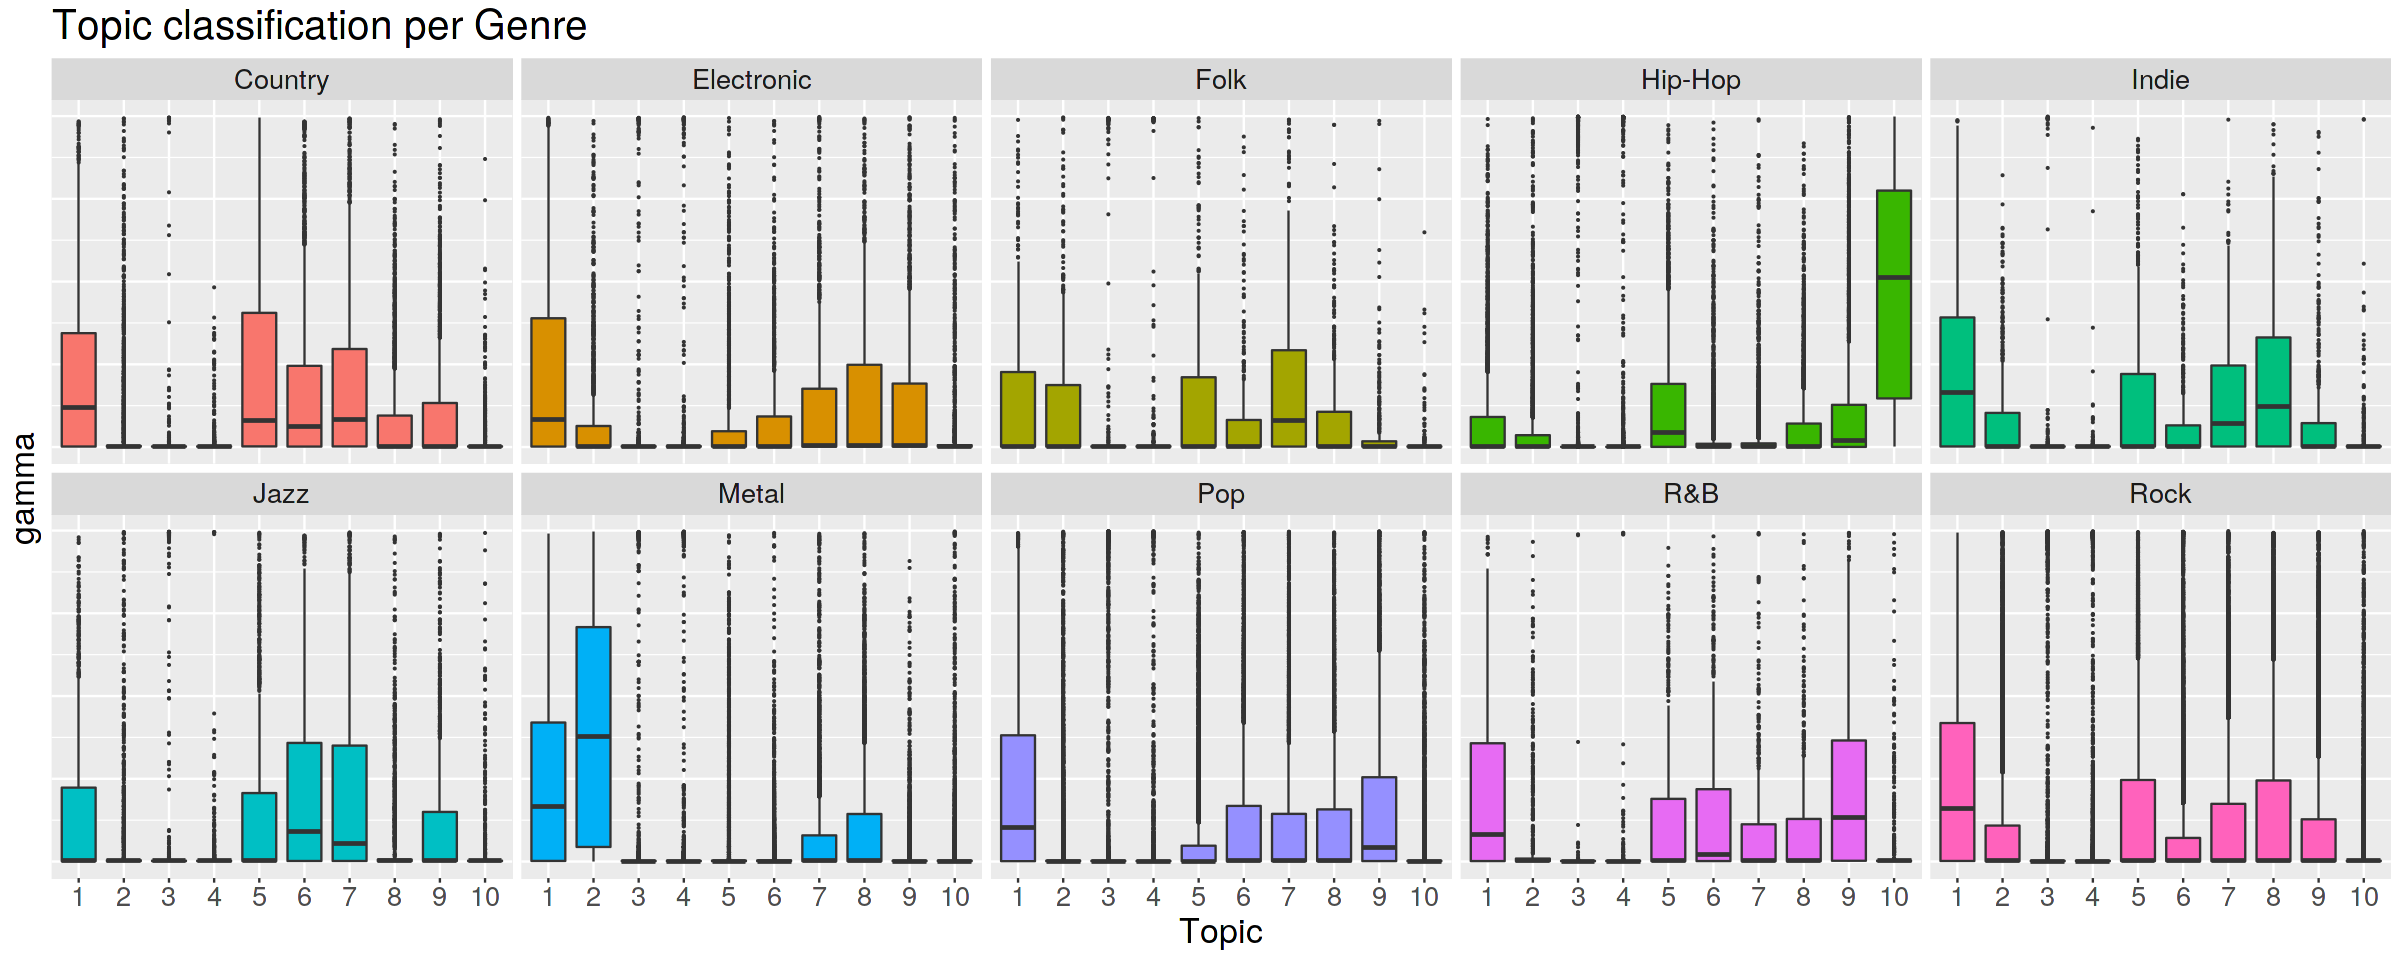

In [40]:
## ---- classification_per_genre_LDA_10----|

start  <- Sys.time()

options(repr.plot.width = 20, repr.plot.height = 8)

lyrics <- readRDS('lyrics.rds')
songs_topics <- tidy(tpm, matrix = "gamma")

lyrics$index <- as.character(lyrics$index)

inner_join(lyrics, songs_topics, by = c('index' = 'document')) %>% 
    select(index, song, year, artist, genre, decade, topic, gamma) %>% 
        ggplot(aes(x = factor(topic), y = gamma, fill = genre)) +
            geom_boxplot(show.legend = FALSE, outlier.size = 0.1) +
            facet_wrap(~ genre, nrow = 2) +
            ylim(0, 1) +
            xlab('Topic') + ylab('gamma') +
            labs(title = 'Topic classification per Genre') +
            theme(text = element_text(size = 20), 
                  axis.text.y = element_blank(), 
                  axis.ticks.y = element_blank())

mem  <- pryr::mem_used()

rm(lyrics, songs_topics)
invisible(gc)

end  <- Sys.time()

WriteLog('plot classification per genre lda 10', start, end, mem)

## ---- end-of-classification_per_genre_LDA_10----|


Calculando a média da estatística **( $ \gamma $ )**, por gênero, podemos visualizar claramente qual o provável tópico, assignado pelo modelo, para cada gênero musical.

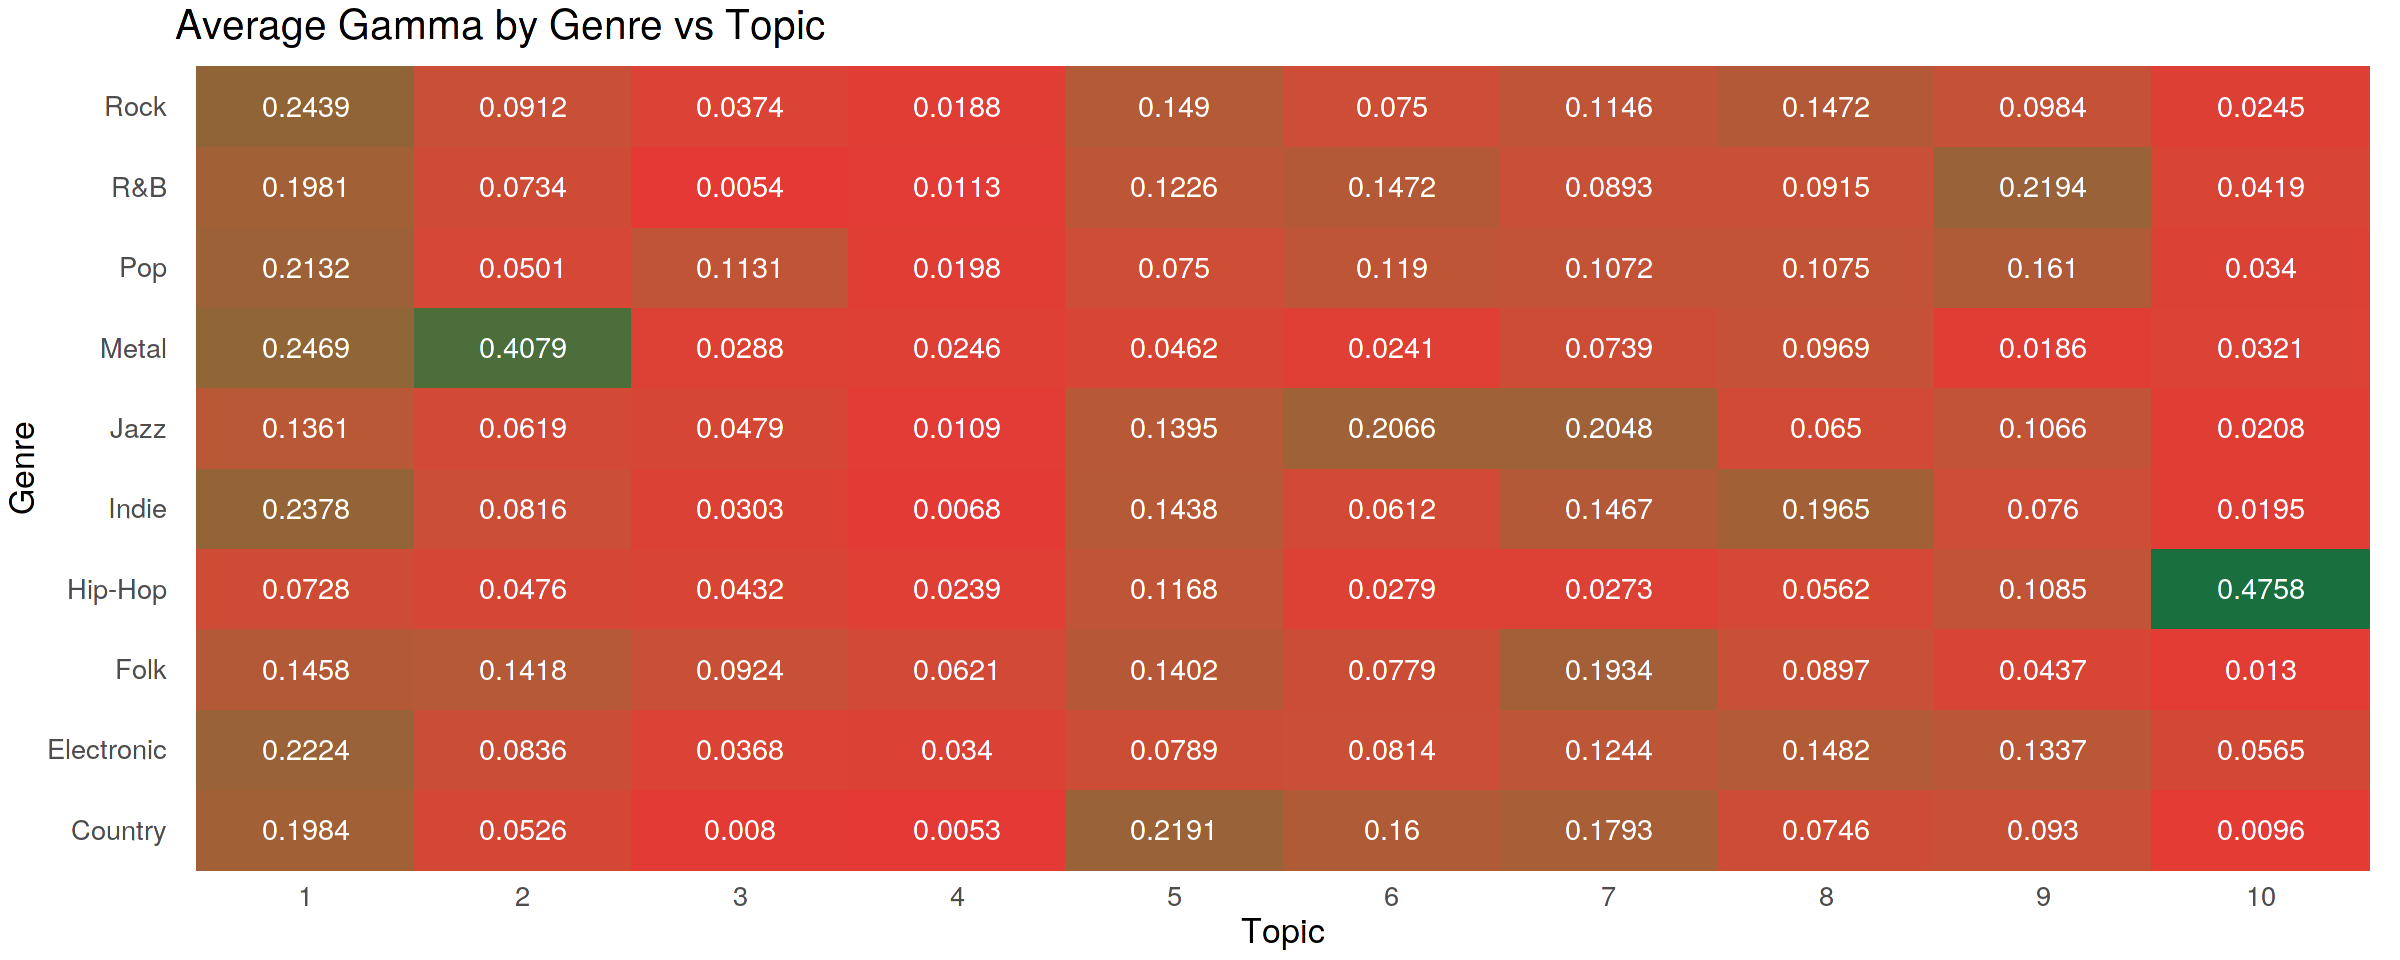

In [41]:
## ---- classification_per_genre_LDA_10_avg_gamma----|

start  <- Sys.time()

options(repr.plot.width = 20, repr.plot.height = 8)

lyrics <- readRDS('lyrics.rds')
songs_topics <- tidy(tpm, matrix = "gamma")

lyrics$index <- as.character(lyrics$index)

inner_join(lyrics, songs_topics, by = c('index' = 'document')) %>% 
    select(index, song, year, artist, genre, decade, topic, gamma) %>% 
    group_by(genre, topic) %>% 
    summarize(mean_gamma = mean(gamma, na.rm = TRUE)) %>% 
    arrange(topic) %>%
        ggplot(aes(x = factor(topic), y = genre, fill = mean_gamma)) +
            geom_bin2d(stat = 'identity', show.legend = FALSE) +
            geom_text(aes(label = round(mean_gamma, 4)), color = 'white', size = 6) +
            scale_fill_gradient(low = "#E53935", high = "#196F3D") +
            theme_minimal() + ylab('Genre') + xlab('Topic') + 
            labs(title = 'Average Gamma by Genre vs Topic') +
            theme(text = element_text(size = 20), 
                  panel.grid = element_blank())

mem  <- pryr::mem_used()

end  <- Sys.time()

WriteLog('plot classification per gere lda 10 avg gamma', start, end, mem)

## ---- end-of-classification_per_genre_LDA_10_avg_gamma----|


# Conclusão

Como podemos observar pelo exercício executado acima a técnica TF-IDF não é adequada para este dataset, para a eliminação de stop words, principalmente por que temos algumas canções em outros idiomas que não o idioma principal do dataset (inglês).

Ao utilizar a técnica de topic modeling verificamos que não é possível identificar os 10 gêneros musicais apenas analisando as letras das canções, porém o modelo apresentou alguma eficácia para as músicas do gênero *Hip-Hop*.

Também verificamos que o algoritmo foi capaz de segregar boa parte das músicas em espanhol e português das músicas em inglês.

Pela análise das probabilidades de classificação dos documentos é possível identificar que talvez 4 ou 5 tópicos poderiam segregar as canções, não necessariamente em gêneros musicais, mas em temas recorrentes, o que faz mais muito sentido, pois na análise exploratória de dados verificamos que os mesmos temas são recorrentes em diferentes gêneros musicais.

Vamos verificar como ficaria a classificação das canções por temas e por gênero musical utilizando um modelo de 5 tópicos apenas.

In [42]:
## ---- LDA_5_topics----|

start  <- Sys.time()

tpm <- LDA(dtm, k = 5, control = list(seed = 123456))

tpm
summary(tpm)

saveRDS(tpm, 'tpm_5.rds')

mem  <- pryr::mem_used()

rm(dtm)
invisible(gc)

end = Sys.time()

WriteLog('calculate tpm 5', start, end, mem)

## ---- end-of-LDA_5_topics----|


A LDA_VEM topic model with 5 topics.

 Length   Class    Mode 
      1 LDA_VEM      S4 

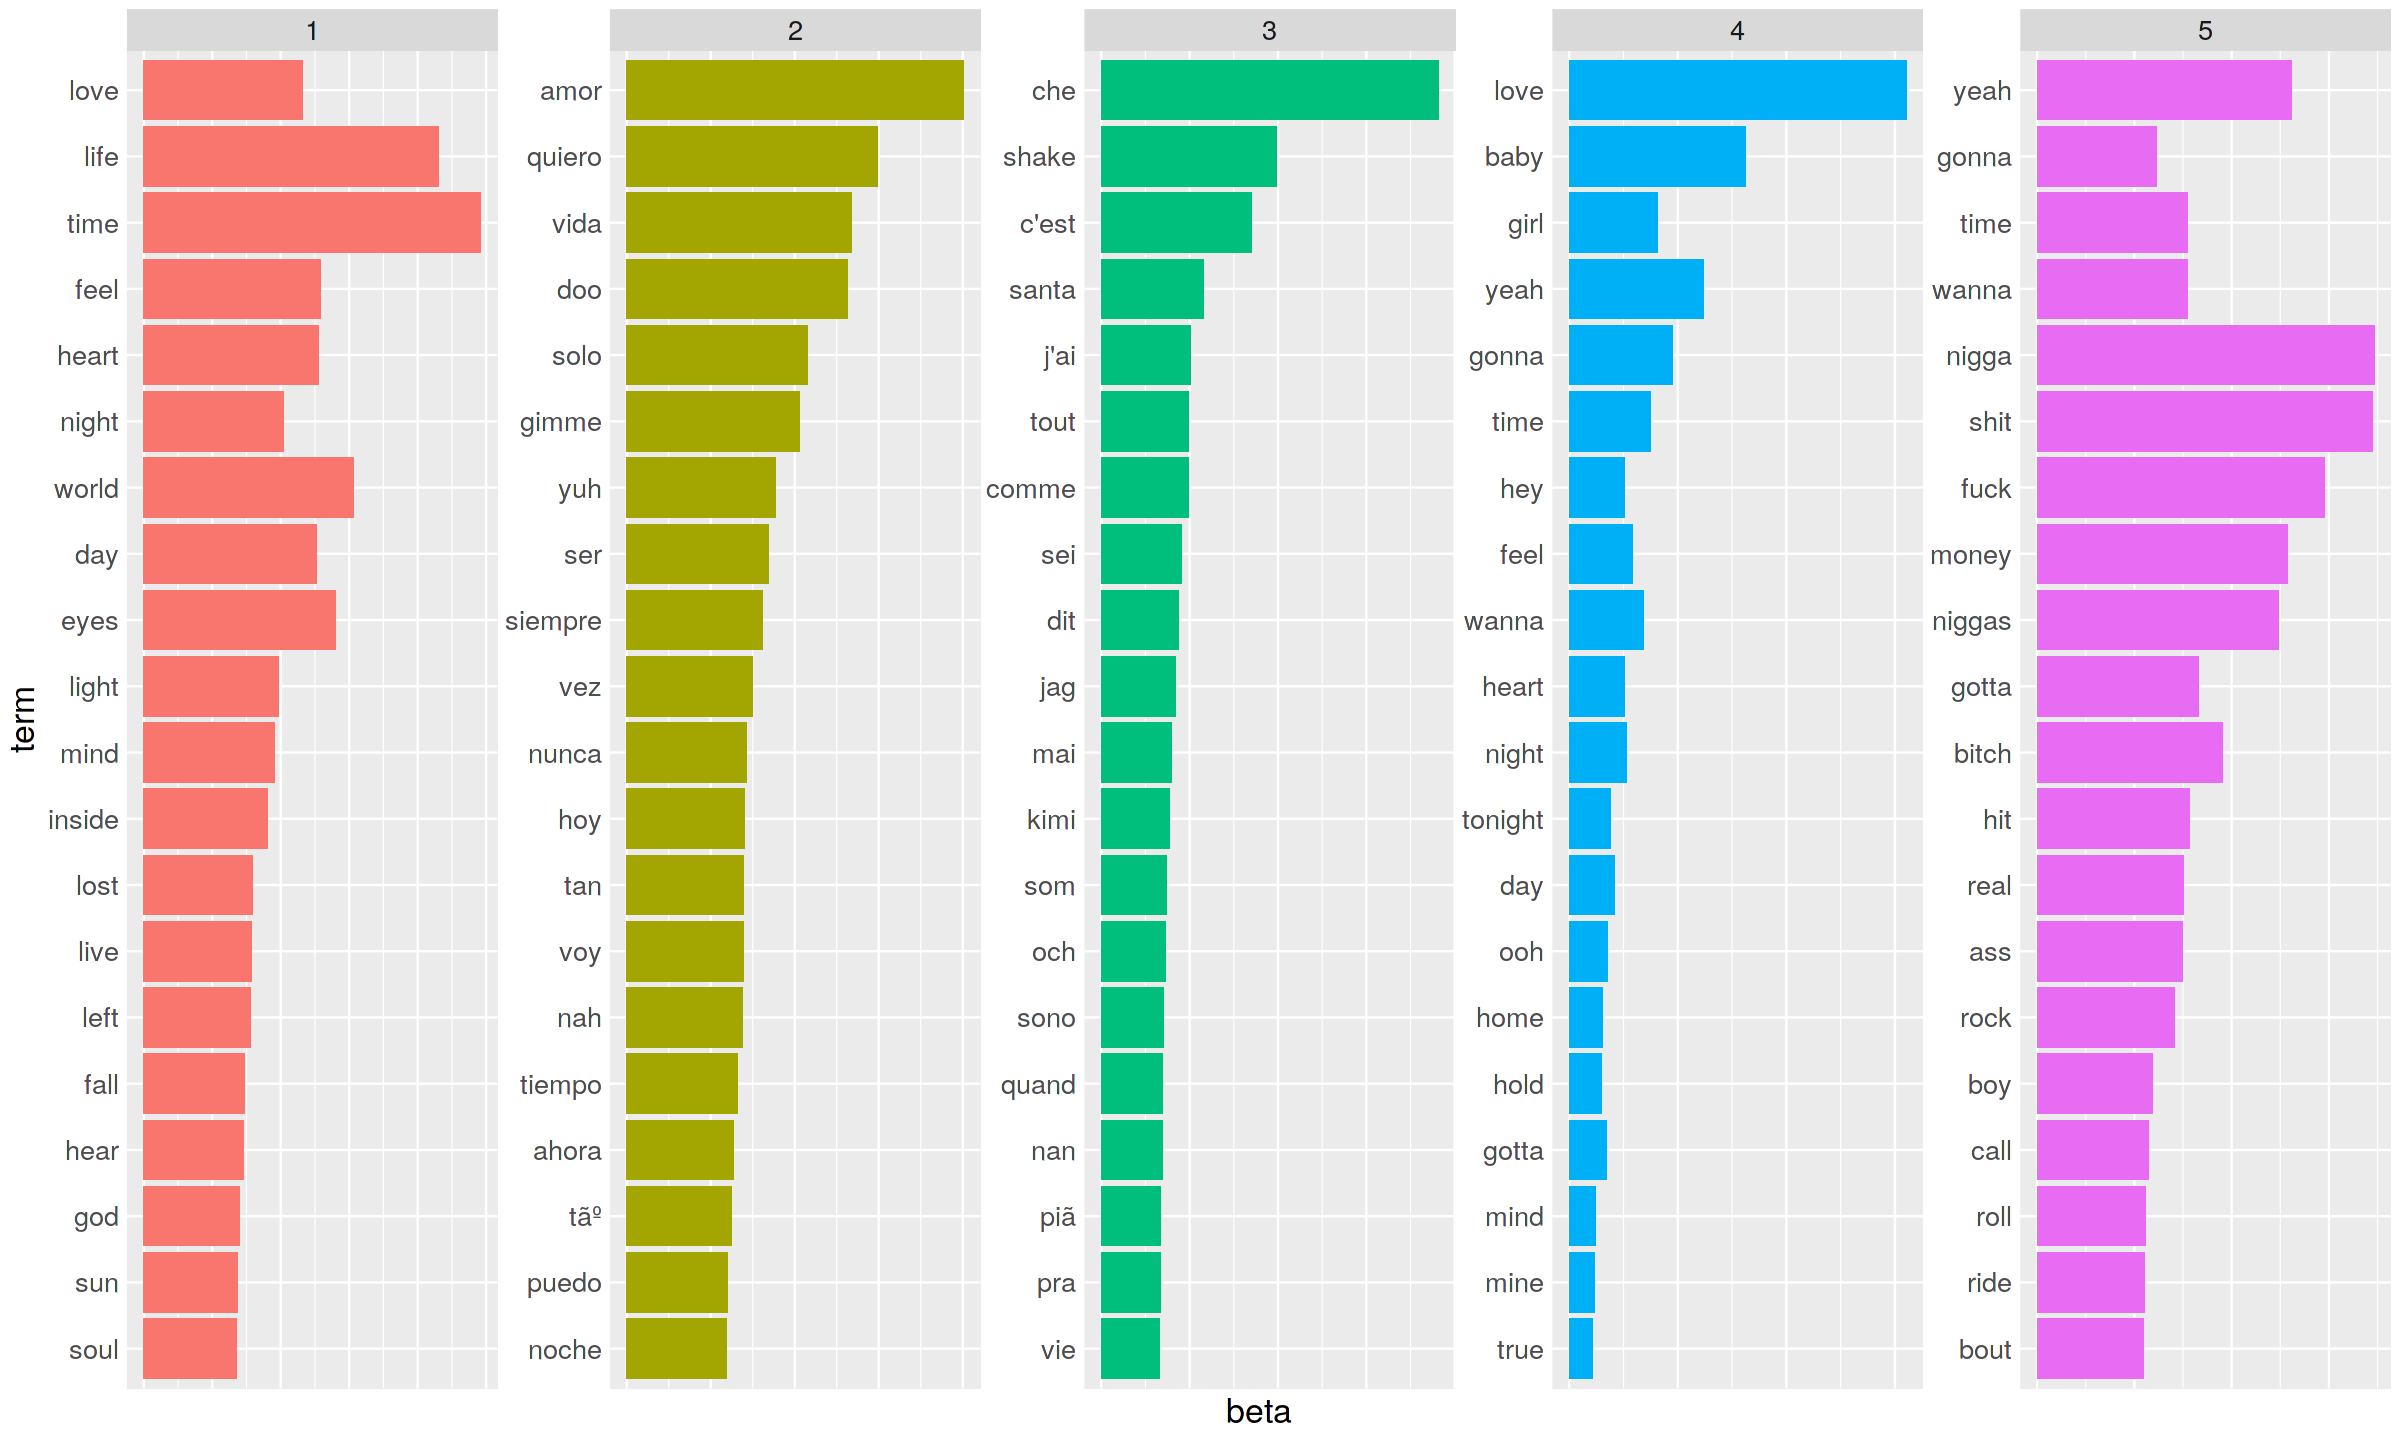

In [43]:
## ---- top_words_per_topic_LDA_5----|

start  <- Sys.time()

options(repr.plot.width = 20, repr.plot.height = 12)

term_topics <- tidy(tpm, matrix = "beta")

term_top_terms <- term_topics %>%
  group_by(topic) %>%
  top_n(20, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

term_top_terms %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free", nrow = 1) +
  coord_flip() +
  theme(text = element_text(size = 20), 
        axis.text.x = element_blank(), 
        axis.ticks = element_blank())

mem  <- pryr::mem_used()

rm(term_topics)
invisible(gc)

end <- Sys.time()

WriteLog('plot top words lda 5', start, end, mem)

## ---- end-of-top_words_per_topic_LDA_5----|


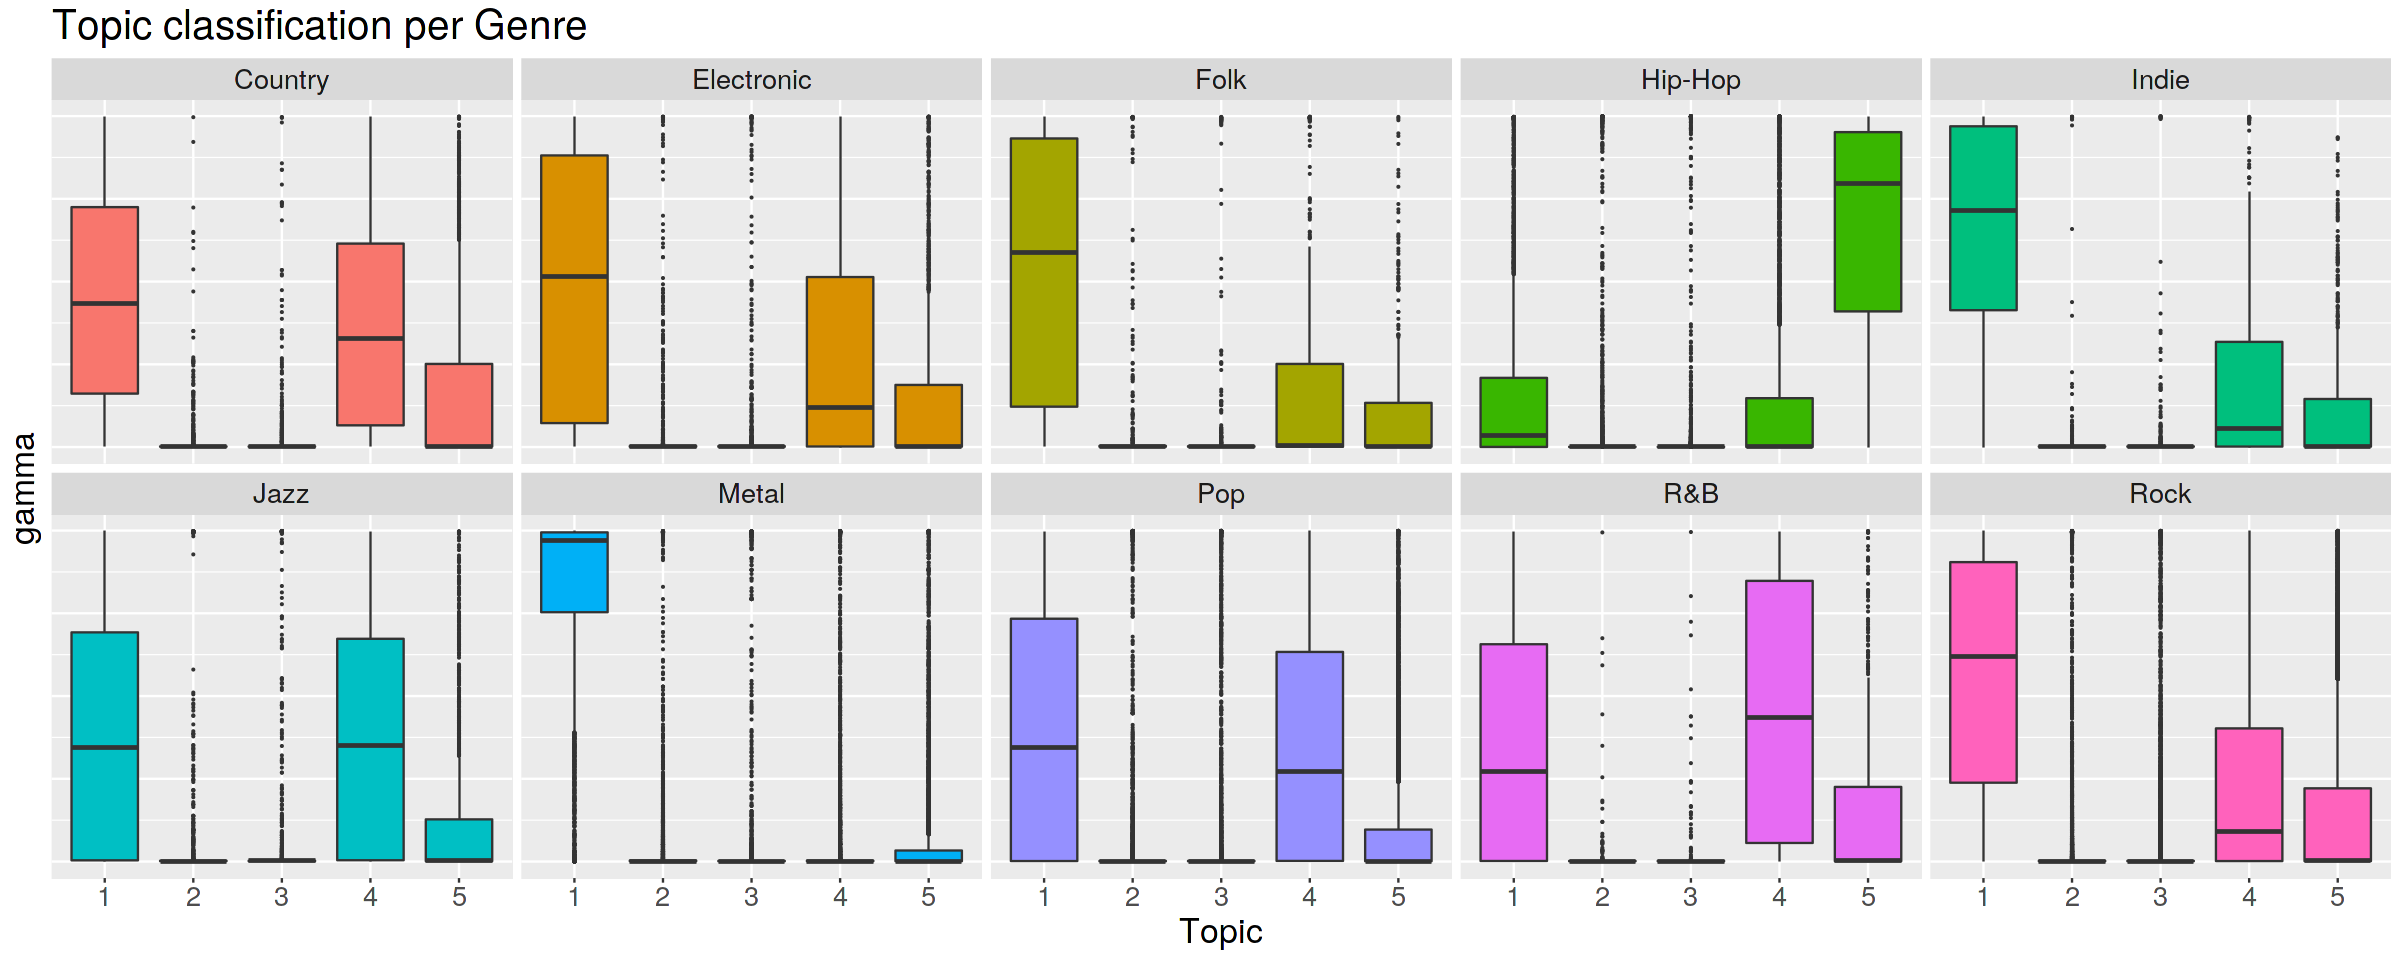

In [44]:
## ---- classification_per_genre_LDA_5----|

start  <- Sys.time()

options(repr.plot.width = 20, repr.plot.height = 8)

lyrics <- readRDS('lyrics.rds')
songs_topics <- tidy(tpm, matrix = "gamma")

lyrics$index <- as.character(lyrics$index)

inner_join(lyrics, songs_topics, by = c('index' = 'document')) %>% 
    select(index, song, year, artist, genre, decade, topic, gamma) %>% 
        ggplot(aes(x = factor(topic), y = gamma, fill = genre)) +
            geom_boxplot(show.legend = FALSE, outlier.size = 0.1) +
            facet_wrap(~ genre, nrow = 2) +
            ylim(0, 1) +
            xlab('Topic') + ylab('gamma') +
            labs(title = 'Topic classification per Genre') +
            theme(text = element_text(size = 20), 
                  axis.text.y = element_blank(), 
                  axis.ticks.y = element_blank())

mem  <- pryr::mem_used()
invisible(gc)

end  <- Sys.time()

WriteLog('plot classification per genre lda 5', start, end, mem)

## ---- end-of-classification_per_genre_LDA_5----|


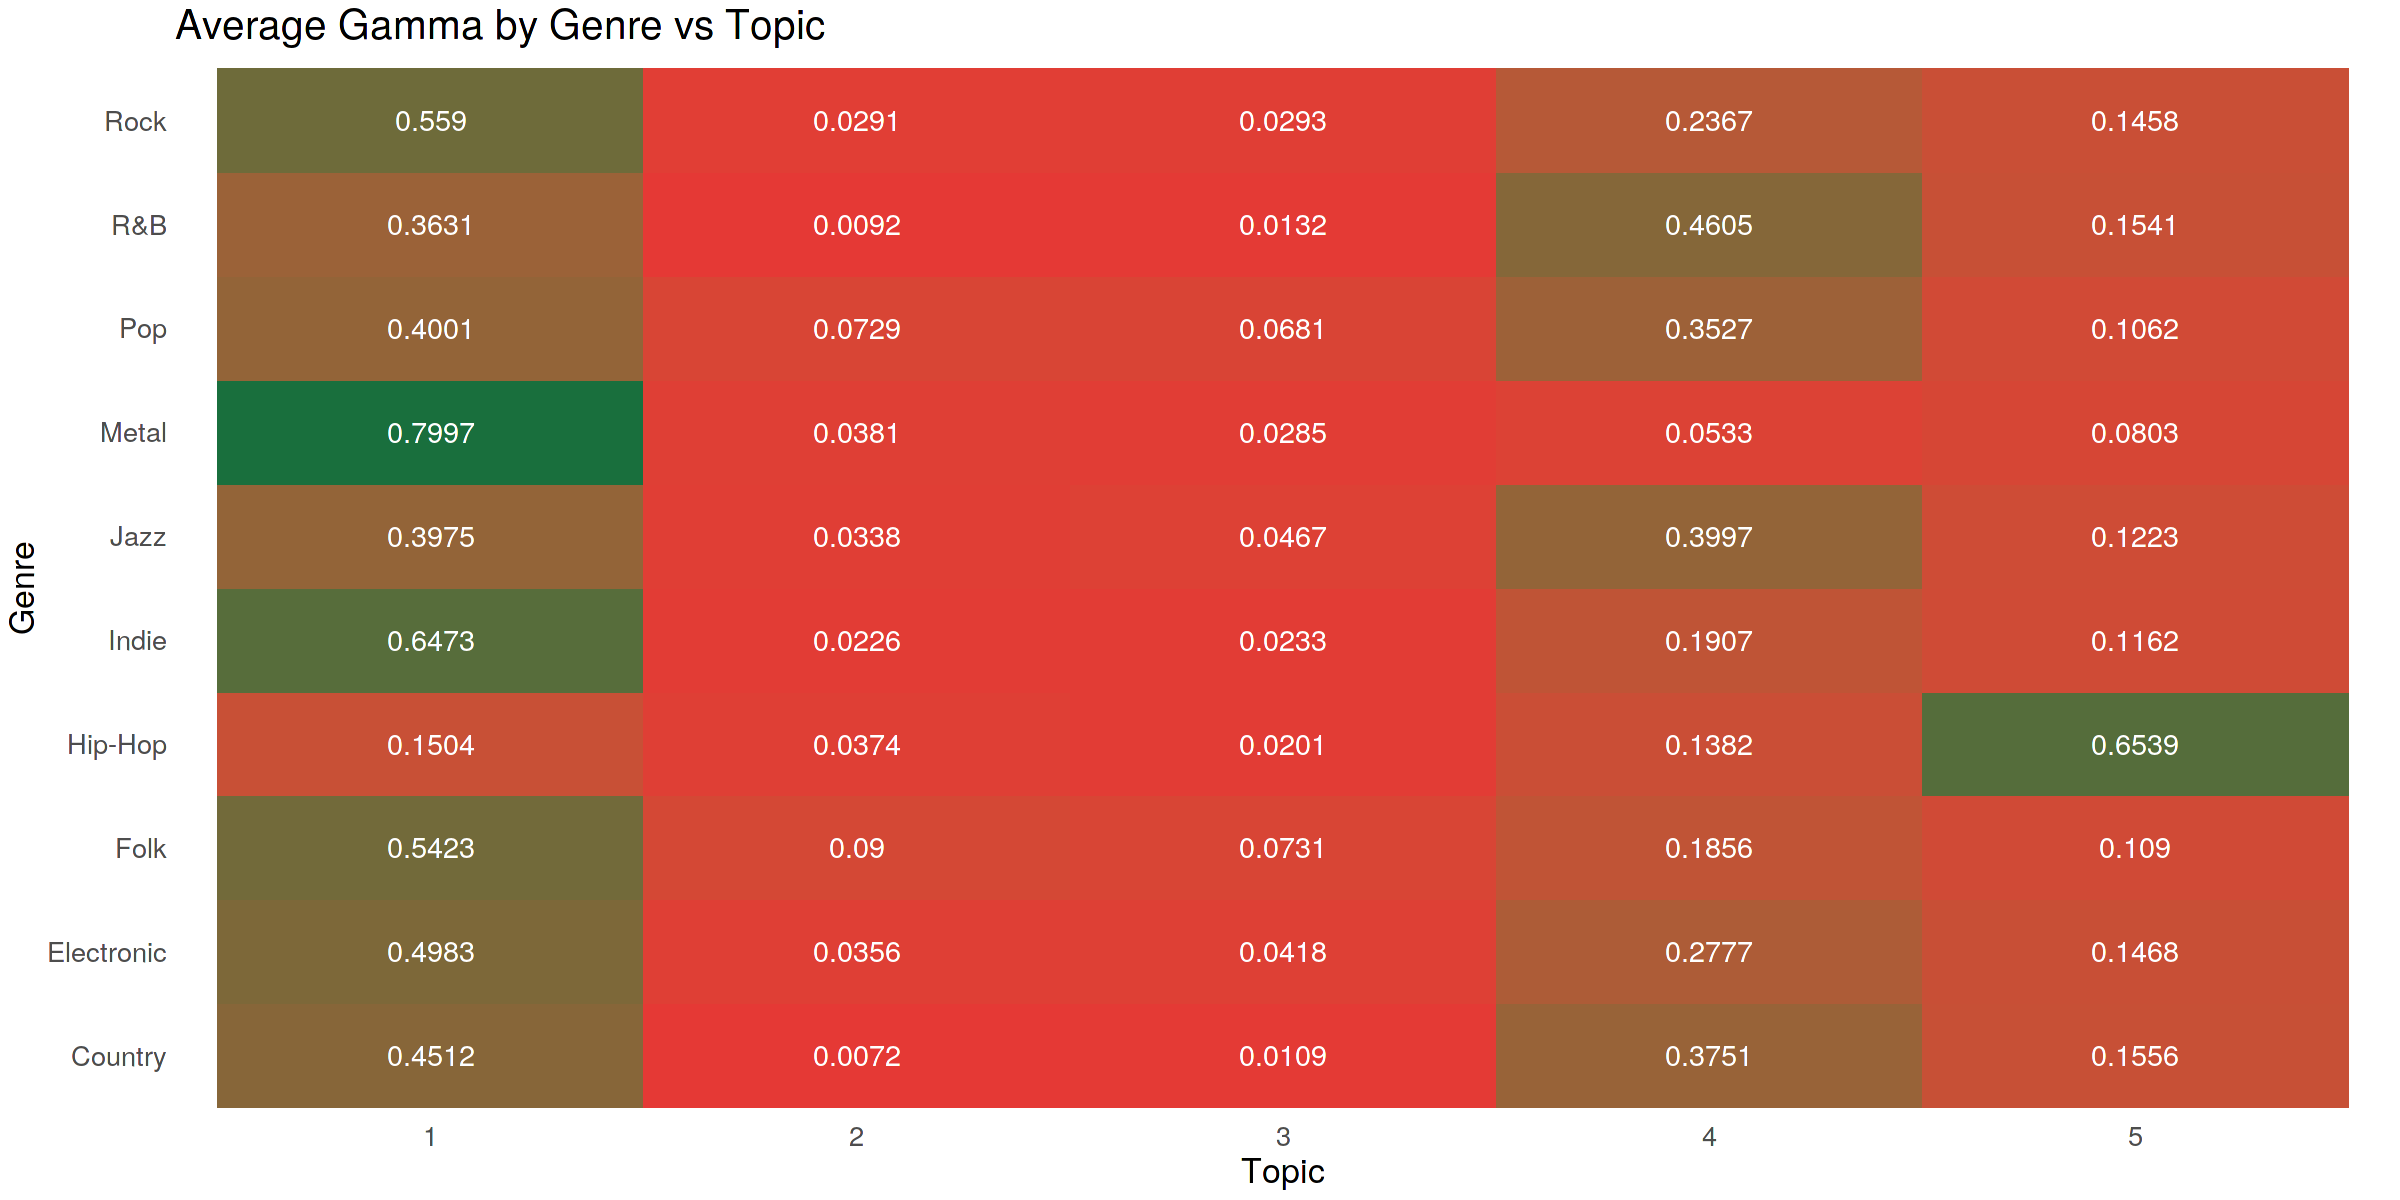

In [45]:
## ---- classification_per_genre_LDA_5_avg_gamma----|

start  <- Sys.time()

options(repr.plot.width = 20, repr.plot.height = 10)

lyrics$index <- as.character(lyrics$index)

inner_join(lyrics, songs_topics, by = c('index' = 'document')) %>% 
    select(index, song, year, artist, genre, decade, topic, gamma) %>% 
    group_by(genre, topic) %>% 
    summarize(mean_gamma = mean(gamma, na.rm = TRUE)) %>% 
    arrange(topic) %>%
        ggplot(aes(x = factor(topic), y = genre, fill = mean_gamma)) +
            geom_bin2d(stat = 'identity', show.legend = FALSE) +
            geom_text(aes(label = round(mean_gamma, 4)), color = 'white', size = 6) +
            scale_fill_gradient(low = "#E53935", high = "#196F3D") +
            theme_minimal() + ylab('Genre') + xlab('Topic') + 
            labs(title = 'Average Gamma by Genre vs Topic') +
            theme(text = element_text(size = 20), 
                  panel.grid = element_blank())

mem  <- pryr::mem_used()
invisible(gc)

end  <- Sys.time()

WriteLog('plot classification per genre lda 5 avg gamma', start, end, mem)

## ---- end-of-classification_per_genre_LDA_5_avg_gamma----|


Para finalizar, vamos observar as canções que tem a maior probabilidade de pertencer ao tópico que aparentemente identificou as observações que estão em outro idioma, que não o inglês.

In [46]:
## ---- classification_non_english----|

start = Sys.time()

group_by(songs_topics, document) %>% 
    arrange(desc(gamma)) %>% 
    filter(row_number() == 1) %>% 
    ungroup() %>% 
    filter(topic == 2) %>% 
    inner_join(lyrics, by = c('document' = 'index')) %>% 
    select(artist, song, genre, decade, gamma, lyrics) %>% 
    mutate(lyrics_preview = str_sub(lyrics, 1, 140)) %>% 
    select(-lyrics) %>% 
    arrange(desc(gamma)) %>% 
    head(25)

end = Sys.time()
mem = pryr::mem_used()

WriteLog('finish', start, end, mem)

## ---- end-of-classification_non_english----|


artist            song                            genre   decade gamma    
1  calle-13          la-perla                        Hip-Hop 2000   0.9993499
2  daddy-yankee      no-te-canses                    Hip-Hop 2000   0.9991474
3  control-machete   comprendes-mendes               Hip-Hop 2000   0.9990799
4  alejandro-sanz    corazon-partio                  Pop     2000   0.9990769
5  calle-13          gato-que-avanza-perro-que-ladra Hip-Hop 2010   0.9990613
6  don-omar          dale-don-dale                   Hip-Hop 2000   0.9989863
7  calle-13          tango-del-pecado                Hip-Hop 2000   0.9989863
8  arcangel          mi-otra-mitad                   Rock    2010   0.9989826
9  dyablo            dejame-tenerte                  Hip-Hop 2000   0.9989752
10 daddy-yankee      after-party                     Hip-Hop 2010   0.9989401
11 alejandro-sanz    no-es-lo-mismo                  Pop     2000   0.9989069
12 dyablo            quien-radio-version             Hip-Hop 2000   0.9988983
13 aventura          la-boda                         Pop     2010   0.9988895
14 dyablo            situaciones                     Hip-Hop 2000   0.9988624
15 daddy-yankee      salgo-pa-la-calle               Hip-Hop 2000   0.9988240
16 daddy-yankee      hoy-salgo-pa-la-calle           Hip-Hop 2000   0.9988240
17 alexis-y-fido     agarrale-el-pantalon            Hip-Hop 2000   0.9988140
18 alexis-y-fido     solo-un-minuto                  Hip-Hop 2000   0.9988140
19 dyablo            no-te-puedo-olvidar             Hip-Hop 2000   0.9988039
20 cnco              reggaetmao-n-lento              Pop     2010   0.9988039
21 anouk             dominique                       Rock    2010   0.9988039
22 dyablo            el-final                        Hip-Hop 2000   0.9987987
23 acda-en-de-munnik niet-of-nooit-geweest           Pop     2000   0.9987987
24 elvis-crespo      mi-problema                     Pop     2010   0.9987883
25 alexander-pires   santo-santo                     Pop     2010   0.9987830
   lyrics_preview                                                                                                                                       
1  Oye, esto va dedicado a todos los barrios de Puerto Rico\nÂ¡Trujillo! Dedicado al barrio de la Perla\nÂ¡Pocho! Dile a Johana que me haga un ar       
2  Que!\nDaddy Yankee, yo!\nCangri!\nLos Homerunners, yo!\nDJ Urba!\nVamos pa' la rumba!\nZumba! Zumba!\nDice!\nNo te canses, yales no paren\nNo te cans
3  Comprende al control\nComprende al control\nPues si me buscas me encuentras no vivo en la tienda\nNi espero a que vengas nomas pa' que aprendas      
4  Tiritas pa este corazÃ³n partiÃ³ (tiri-ti-tando de frÃ­o)\nTiritas pa este corazÃ³n partiÃ³, (pa este corazÃ³n partiÃ³)\nYa lo ves, que no hay       
5  Yo no soy mÃºsico ni canto, yo solo rapeo\nPero digo mÃ¡s que tÃº, con su teorÃ­a y solfeo\nSoy el que rompe la armonÃ­a\nSi las palabras fuera      
6  Gocho\nDon, Don\n(M-V-P)\nDale\nDale, Don, dale\nPa' que se muevan la yales\nPa' activar los anormales\nY al que se resbale Boster dale, dale\nDale, 
7  Tres vueltas de carnero\nY flap te fuistes por el agujero\nTodos los groseros\nA bailar encima de lava volcÃ¡nica\nSubele el volumen a la mÃºsic     
8  Eres tÃº mi otra mitad\nLa luz de mis ojos\nLa que complace mi antojo\nNadie como tu encontrare\nLa Ãºnica que entiende\nLo que yo he sufrido\nVeo   
9  Dejame tenerte cerca, dejame besar tu cuerpo\nde la creacion la perfeccion, hey mija no miento\ndejame tenerte cerca, dejame besar tu cuerpo\nh      
10 As lo hacemos los Jefes...\nuhhh\nA otro nivel beb\nDY\nDe La Geezy\nCome on\nLa nena lo que quiere es conocer, hablarte mami\nDesde el momento en   
11 Eres tanta gente, que dime\nÂ¿Con quiÃ©n hablo ahora?\nÂ¿No ves que no sois iguales?\nEres la de quÃ©date conmigo\nPrometo darte tormento, darte     
12 Quin?, sino yo\nme ven y corren\nlos hacen correr CORRAN\nmientras puedan\npor qu, por qu\nhaber porqu\nescucha\nsuenen alarmas y trompe

# Referências

[Text Mining with R](https://www.tidytextmining.com/) - Julia Silge and David Robinson

[Beginner’s Guide to LDA Topic Modelling with R](https://towardsdatascience.com/beginners-guide-to-lda-topic-modelling-with-r-e57a5a8e7a25) - [Farren tang
](https://towardsdatascience.com/@tangqingxia)

[A Beginner's Guide to Bag of Words & TF-IDF](https://pathmind.com/wiki/bagofwords-tf-idf) - Chris Nicholson